# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Business Understanding

To summarize the introduction we are interested in finding the groups that are most responsive to which types of offers and to maximize the promotion strategy using uplift modeling. and for each startgey we will have a different promotional model. 
To segmenet the customers groups i will create Recency-Frequency-Monetary RFM clustering(An RFM analysis evaluates which customers are of highest and lowest value to an organization based on purchase recency, frequency, and monetary value, in order to reasonably predict which customers are more likely to make purchases again in the future)
This work will be divided into the following section:

    1) Data Understanding

    2) Preprocessing 

    3) Basic EDA

    4) Feature Engineering

    5) Modeling

# Data Understanding
In this section i look into the 3 given datasets to identify initial preprocessing on the data. 

In [67]:
import pandas as pd
import numpy as np
import math
import json

import itertools
from scipy.stats import norm

from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost import plot_importance


# stats 
from scipy.stats import norm

# plot libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from tqdm import tqdm
from tqdm.auto import tqdm
#from tqdm import tqdm_notebook as tqdm


%matplotlib inline

#2D plots 

import chart_studio.plotly as py

#import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#initiate visualization library for jupyter notebook 
pyoff.init_notebook_mode()


In [2]:
# display all the columns in a dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio data set 
Lets start with exploring the offers dataset:

In [4]:
portfolio

channels  difficulty  duration                                id     offer_type  reward
0  [email, mobile, social]       10          7         ae264e3637204a6fb9bb56bc8210ddfd  bogo           10    
1  [web, email, mobile, social]  10          5         4d5c57ea9a6940dd891ad53e9dbe8da0  bogo           10    
2  [web, email, mobile]          0           4         3f207df678b143eea3cee63160fa8bed  informational  0     
3  [web, email, mobile]          5           7         9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo           5     
4  [web, email]                  20          10        0b1e1539f2cc45b7b9fa7c272da2e1d7  discount       5     
5  [web, email, mobile, social]  7           7         2298d6c36e964ae4a3e7e9706d1fb8c2  discount       3     
6  [web, email, mobile, social]  10          10        fafdcd668e3743c1bb461111dcafc2a4  discount       2     
7  [email, mobile, social]       0           3         5a8bc65990b245e5a138643cd4eb9837  informational  0     
8  [web, email, mobile, social]  5           5         f19421c1d4aa40978ebb69ca19b0e20d  bogo           5     
9  [web, email, mobile]          10          7         2906b810c7d4411798c6938adc9daaa5  discount       2

In [5]:
portfolio[portfolio.offer_type =='bogo']

channels  difficulty  duration                                id offer_type  reward
0  [email, mobile, social]       10          7         ae264e3637204a6fb9bb56bc8210ddfd  bogo       10    
1  [web, email, mobile, social]  10          5         4d5c57ea9a6940dd891ad53e9dbe8da0  bogo       10    
3  [web, email, mobile]          5           7         9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo       5     
8  [web, email, mobile, social]  5           5         f19421c1d4aa40978ebb69ca19b0e20d  bogo       5

In [6]:
portfolio[portfolio.offer_type =='discount']

channels  difficulty  duration                                id offer_type  reward
4  [web, email]                  20          10        0b1e1539f2cc45b7b9fa7c272da2e1d7  discount   5     
5  [web, email, mobile, social]  7           7         2298d6c36e964ae4a3e7e9706d1fb8c2  discount   3     
6  [web, email, mobile, social]  10          10        fafdcd668e3743c1bb461111dcafc2a4  discount   2     
9  [web, email, mobile]          10          7         2906b810c7d4411798c6938adc9daaa5  discount   2

In [7]:
portfolio[portfolio.offer_type =='informational']

channels  difficulty  duration                                id     offer_type  reward
2  [web, email, mobile]     0           4         3f207df678b143eea3cee63160fa8bed  informational  0     
7  [email, mobile, social]  0           3         5a8bc65990b245e5a138643cd4eb9837  informational  0

**We have 3 main offer types: BOGO, informational, discount. These types can be further subdivided based on the duration, difficulty and the channels into 10 types of offers as follows:**

    1) B3_10_7_10 as part BOGO: sent to 3 channels (email, mobile, social), difficulty 10, duration 7 days and a reward of 10.

    2) B4_10_5_10

    3) B3_5_7_5

    4) B4_5_5_5

    5) D2_20_10_5

    6) D4_7_7_3

    7) D4_10_10_2

    8) D3_10_7_2

    9) I3_0_4_0

    10) I3_0_3_0

The first letter is used for the offer type, followed by the diffculty, duration and the last value is for the reward and these values are seperated by _.

In [8]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [9]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [10]:
portfolio.describe()

difficulty   duration     reward
count  10.000000   10.000000  10.000000
mean   7.700000    6.500000   4.200000 
std    5.831905    2.321398   3.583915 
min    0.000000    3.000000   0.000000 
25%    5.000000    5.000000   2.000000 
50%    8.500000    7.000000   4.000000 
75%    10.000000   7.000000   5.000000 
max    20.000000   10.000000  10.000000

**From the above we can identify the following cleaning:**

    1) channels contain a list of values so in order to handle this 

    2) rename id into offer_id
    
    Data Engineering steps:

    1) change the offer type to have a symbol for each offer type to make it easier to create different

    2) handle the categorical offer_type 

### Profile


In [11]:
profile.head()

age  became_member_on gender                                id    income
0  118  20170212          None   68be06ca386d4c31939f3a4f0e3dd783 NaN      
1  55   20170715          F      0610b486422d4921ae7d2bf64640c50b  112000.0
2  118  20180712          None   38fe809add3b4fcf9315a9694bb96ff5 NaN      
3  75   20170509          F      78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118  20170804          None   a03223e636434f42ac4c3df47e8bac43 NaN

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
profile.describe()

age  became_member_on         income
count  17000.000000  1.700000e+04      14825.000000 
mean   62.531412     2.016703e+07      65404.991568 
std    26.738580     1.167750e+04      21598.299410 
min    18.000000     2.013073e+07      30000.000000 
25%    45.000000     2.016053e+07      49000.000000 
50%    58.000000     2.017080e+07      64000.000000 
75%    73.000000     2.017123e+07      80000.000000 
max    118.000000    2.018073e+07      120000.000000

In [14]:
# check for any duplicated id values
profile[profile.id.duplicated()]

Empty DataFrame
Columns: [age, became_member_on, gender, id, income]
Index: []

Lets investigate the missing values in the income and age  

In [15]:
# get missing values in each column dataframe 
profile.isna().sum()

age                 0   
became_member_on    0   
gender              2175
id                  0   
income              2175
dtype: int64

In [16]:
profile[((profile.gender.isnull()) & (profile.income.isnull()))]

age  became_member_on gender                                id  income
0      118  20170212          None   68be06ca386d4c31939f3a4f0e3dd783 NaN    
2      118  20180712          None   38fe809add3b4fcf9315a9694bb96ff5 NaN    
4      118  20170804          None   a03223e636434f42ac4c3df47e8bac43 NaN    
6      118  20170925          None   8ec6ce2a7e7949b1bf142def7d0e0586 NaN    
7      118  20171002          None   68617ca6246f4fbc85e91a2a49552598 NaN    
9      118  20161122          None   8974fc5686fe429db53ddde067b88302 NaN    
10     118  20170824          None   c4863c7985cf408faee930f111475da3 NaN    
11     118  20150919          None   148adfcaa27d485b82f323aaaad036bd NaN    
17     118  20170801          None   744d603ef08c4f33af5a61c8c7628d1c NaN    
23     118  20170907          None   2b826eba31074a059d63b0ae8f50b7d5 NaN    
26     118  20170330          None   65aba5c617294649aeb624da249e1ee5 NaN    
36     118  20160707          None   4beeb3ed64dd4898b0edf2f6b67426d3 NaN    
39     118  20180113          None   25c906289d154b66bf579693f89481c9 NaN    
44     118  20141111          None   5b8f1f0e0930464f93bb55e59b5a04e0 NaN    
45     118  20170511          None   8be4463721e14d7fa600686bf8c8b2ed NaN    
54     118  20170528          None   81ac76e4f2fe4a6bb5ebdc0f19cecc56 NaN    
56     118  20171013          None   020d3a52b9ce432ea5f98fc58e9bfcc4 NaN    
57     118  20151220          None   4be1127413db496d8103c783ae72058b NaN    
80     118  20170918          None   9d8d6bb2fc544a9c802888971ee3e8b1 NaN    
84     118  20150920          None   a89752cdfdf24779aa22faa2bc24e7c2 NaN    
96     118  20160806          None   53bac762af27471eb294ff89ca1bae2c NaN    
103    118  20170223          None   488773cae11f4b71875bfccd4e3e99f2 NaN    
104    118  20170823          None   182e68952b474700b171e21b85c258ac NaN    
108    118  20160130          None   5e9c83e8ab4d4e9ca83f3256d83ca756 NaN    
121    118  20150730          None   c099206f76b1414db7552f163520053c NaN    
122    118  20171125          None   e6d3eebb535e44aca1323edde5c346fa NaN    
128    118  20160418          None   baba98dba43e42ae8e86cbd70725e201 NaN    
143    118  20161018          None   58748c1cf9f746838c6ec62acdff28ad NaN    
169    118  20150905          None   770df32893694100afc703ea9c9df401 NaN    
172    118  20180114          None   50b92ea51e2649dfbf7120d5e554e991 NaN    
...    ...       ...           ...                                ...  ..    
16820  118  20151015          None   64257cb56316491fae38e62f2687a66c NaN    
16829  118  20171007          None   56a0b671fa0347beb8b60011a15800aa NaN    
16831  118  20170910          None   060c0b9181674d03aa181b75353b9422 NaN    
16835  118  20161211          None   587453e2944b4c6699519a217bf87de6 NaN    
16839  118  20180626          None   d6063a30185b4e60b58a445bacec5f56 NaN    
16842  118  20151110          None   a225189b10a141d5bb1ff0a05265da4c NaN    
16844  118  20170228          None   4342cb3414534aaca96ac523edc82654 NaN    
16845  118  20150815          None   d1477e69857f42d18929f6f29b3be427 NaN    
16852  118  20140605          None   6c0df9b1d3b8401c8098c7c7f9977d89 NaN    
16853  118  20171123          None   7b3b8100d6444861803cefc6b13c9a43 NaN    
16856  118  20150729          None   3a02d786fbc143edb257665ad54c5c09 NaN    
16861  118  20171212          None   8f4364144e0548f885b390f28aabe2b8 NaN    
16869  118  20160607          None   1efb4a45f5c34db4b07ebd19bdfc1b41 NaN    
16875  118  20170129          None   113f3f07ac2b4f8b940d6136233ae3ee NaN    
16877  118  20180307          None   b6f74fc8e1664cfb9b44834dd9f7cf48 NaN    
16885  118  20150804          None   123ec648e228460589182607c0db4dd5 NaN    
16906  118  20170729          None   09f61d1d6e05402ca923d614dda52d57 NaN    
16915  118  20171021          None   7b32b3085ad540a58482c091b1dca914 NaN    
16923  118  20160209          None   54ed2d25754a486fba36eb5c7541203a NaN    
16931  118  20170913         

In [17]:
# first i want to check the columns that have even na gender and income
profile[((profile.gender.isnull()) & (profile.income.isnull()))].age.unique()

array([118])

so from the above we can see that age column has a value of 118 when the income and gender are null. 

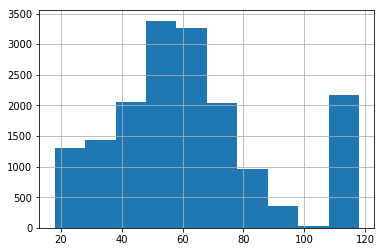

In [18]:
profile.age.hist()

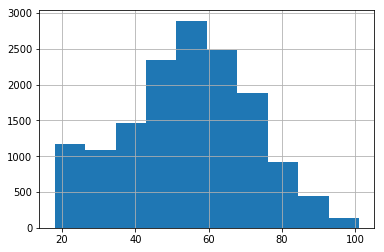

In [19]:
profile[profile.age !=118].age.hist()

In [20]:
profile[profile.age !=118].age.describe()

count    14825.000000
mean     54.393524   
std      17.383705   
min      18.000000   
25%      42.000000   
50%      55.000000   
75%      66.000000   
max      101.000000  
Name: age, dtype: float64

In [21]:
profile[(profile.age < 118) & (profile.age > 66)]

age  became_member_on gender                                id    income
3      75   20170509          F      78afa995795e4d85b5d9ceeca43f5fef  100000.0
5      68   20180426          M      e2127556f4f64592b11af22de27a7932  70000.0 
22     78   20170616          F      c27e0d6ab72c455a8bb66d980963de60  71000.0 
30     67   20140823          M      5917d13f6fa04286abdf95f4d5cefb1e  96000.0 
33     96   20171117          F      868317b9be554cb18e50bc68484749a2  89000.0 
35     69   20160814          F      102e9454054946fda62242d2e176fdce  57000.0 
40     75   20151112          M      6e014185620b49bd98749f728747572f  40000.0 
46     69   20130918          F      8e7c7465e98c43d8a01f51e2b5c29542  37000.0 
50     79   20150415          F      a3b9b4bf115e4564933ea2e4bc936843  48000.0 
58     78   20161009          F      fe8264108d5b4f198453bbb1fa7ca6c9  93000.0 
64     76   20180314          F      ab66a363907e43e9a7cd535f1578245b  47000.0 
65     68   20170823          M      d3f146b615514c6380b168bb3df5f05b  87000.0 
66     75   20151129          M      a5a6ef2b78a04ddc9f374dd7c7f60bff  52000.0 
67     67   20170226          M      2e87ba0fba1a4d1a8614af771f07a94d  76000.0 
68     77   20160730          M      d8af520c4a8a4c77b921098d7d838c4d  51000.0 
69     76   20140831          M      39dbcf43e24d41f4bbf0f134157e0e1e  64000.0 
75     67   20160910          F      5cd6577aca5d4b419e452f9f505ffce7  77000.0 
85     73   20180419          F      a2b7a0b3487a4d779ddf4e11a034e2ee  91000.0 
86     74   20151224          F      2c5c63e5124e417b8504f76c868a4190  107000.0
88     78   20151111          M      571b739ada3041fb8fbd20f23ce034f7  58000.0 
90     70   20180613          F      13b7b2eccf664a329d83d2a238a9a11d  74000.0 
94     89   20171114          F      4264b1d027cc493281bba4f44bfedaca  87000.0 
95     73   20180401          M      0ba6e2ad781c4429afd26cf0b35f2d11  51000.0 
98     90   20151210          F      1c587de019994f93a242c6864fd7bc55  98000.0 
99     68   20160731          F      3f4e408b0b2d4ea89dd16d7437d867c1  84000.0 
107    72   20160811          F      f8aedd0cbea0419c806842b4265b82e5  72000.0 
109    76   20160407          M      a9780228a1d04539afdee8b745e4be10  63000.0 
115    74   20180712          M      e641af076cc54529bec6ab61fc25f4a6  48000.0 
124    71   20170129          M      6747dda08bed46298c23e05b64820a3a  57000.0 
126    83   20180127          M      4c29d22467af4d7faa137c4eedd65340  46000.0 
...    ..        ...         ..                                   ...      ... 
16834  70   20171230          M      6fe3abd5fa1e4914b9e04ba3d8d0de3f  73000.0 
16840  86   20161110          F      d4db6fc5233b415fbb0769bc4575fee5  44000.0 
16841  77   20180625          F      3b61ad3edcab45dd839f15e3fb1727e2  78000.0 
16850  83   20161011          F      348ebeefcf1d407fa9c00ff05255963b  117000.0
16851  73   20170913          F      b9d88b4d7c734c9a83de6350303d9d65  105000.0
16864  101  20171127          F      1593d617fac246ef8e50dbb0ffd77f5f  82000.0 
16866  73   20170212          M      c4e9d8b42d27484484b7077146076448  52000.0 
16873  73   20171005          M      043b6b6be98c412d901f7f376e0548d0  77000.0 
16874  75   20160521          F      6d9ab08312224d7699d7c2a10e01d1d6  83000.0 
16878  77   20170311          F      b0b3af40c94f40c09a9036fe4a19e9c2  78000.0 
16882  72   20170729          F      7789e842ce3842b981e853caf9368d06  70000.0 
16893  75   20170529          M      25d81869d43045c09ebf32a6696908e6  116000.0
16896  74   20140327          F      c95e4b6a0e874a8488624f8f8da3a369  99000.0 
16901  73   20170808          F      435afc43755d4bd5ab56ec38dcc152ff  98000.0 
16902  79   20170813          F      6daa587dc49545a8b0d9d4e61d66cc8c  70000.0 
16914  87   20140920          M      d1c4500ace2e45e9a45d3cd2fccac8d8  59000.0 
16927  74   20160522          F      e4a16683f11241dd849c7172ba85a474  98000.0 
16932  68   20160313          F      91a5f86f02964fa5b6a41b531547815d  63000.0 
16933  

so from the above we notice that even when we remove age values of 118, we still have a maximum value of 101 for the age so to check if this should be considered an outlier i will use the z-score method.  
In this outlier detection method we calculate the z-score values and then we set a thershould for outlier values.

In [22]:
def outliers_z_score(col, thershold = 2):
    """
    detect outliers s
    """
    col_mean = col.mean()
    col_stdev = col.std()
    z_scores = (col - col_mean) / col_stdev
    
    return np.where(np.abs(z_scores) > thershold)
    
outliers_z_score(profile.age)

(array([    0,     2,     4, ..., 16989, 16991, 16994]),)

In [23]:
profile.iloc[outliers_z_score(profile.age)].age.unique()

array([118])

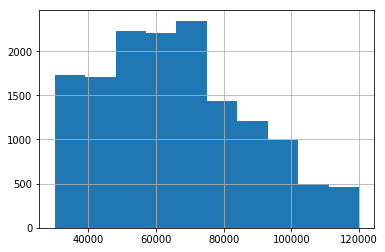

In [24]:
profile.income.hist()

In [25]:
profile.gender.value_counts()

M    8484
F    6129
O    212 
Name: gender, dtype: int64

**From the above we can identify the following cleaning:**

Data Cleaning 
    
    1) Change the became_member_on to the date type instead of the current int value.

    2) Rename id to customer_id
    
    3) handle the gender 0 attribute

Feature Engineering

    1) Label encode the gender attribute to 0 or 1.
    
    2) Handle outliers in the age columns and the missing values in gender and income columns
    
### Transcript dataset 

In [44]:
transcript.head(10)

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   
5  offer received  389bc3fa690240e798340f5a15918d5c     0   
6  offer received  c4863c7985cf408faee930f111475da3     0   
7  offer received  2eeac8d8feae4a8cad5a6af0499a211d     0   
8  offer received  aa4862eba776480b8bb9c68455b8c2e1     0   
9  offer received  31dda685af34476cad5bc968bdb01c53     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  
5  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}  
6  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}  
7  {'offer id': '3f207df678b143eea3cee63160fa8bed'}  
8  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
9  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}

In [46]:
transcript[transcript.event == 'offer completed']

event                            person  time  \
12658   offer completed  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   
12672   offer completed  fe97aa22dd3e48c8b143116a8403dd52     0   
12679   offer completed  629fc02d56414d91bca360decdfa9288     0   
12692   offer completed  676506bad68e4161b9bbaffeb039626b     0   
12697   offer completed  8f7dd3b2afe14c078eb4f6e6fe4ba97d     0   
12717   offer completed  227f2d69e46a4899b70d48182822cff6     0   
12721   offer completed  bb0f25e23a4c4de6a645527c275cd594     0   
12744   offer completed  d72d201be5794279aa716d8ad82b8d90     0   
12764   offer completed  73ffefd41e9a4ca3ab26b2b3697c6eb7     0   
12767   offer completed  3e621194f72e40d7a0b695ee9b7c38b7     0   
12780   offer completed  b860d355ef6e4c66b5d5a837c56ef32d     0   
12784   offer completed  99297ea01107436fa8c2e2bc86f55d89     0   
12786   offer completed  24115a61df25473e84a8a03f3c98de1a     0   
12798   offer completed  afce4cf8194f4e90a3e92da941a23601     0   
12817   offer completed  a2ffc22184d94d6fa21b924eb49c0d06     0   
12826   offer completed  2481f1fcfbcb4b288e5a03af02d95373     0   
12835   offer completed  c3321bc76743445c9103eef0ce9d833b     0   
12841   offer completed  162e7d9c644b438ea4606e337df0d3d1     0   
12862   offer completed  de90515e9f174ddfb8b4c677448286ef     0   
12865   offer completed  5152fa6375184287b06e2fd0d5abed34     0   
12900   offer completed  5d048a36203c483facb5ed09983ab388     0   
12936   offer completed  16dc4306258b4fef90ffe99f53ed7952     0   
12943   offer completed  2c9a9137efff4820a47d56dbf0fa555f     0   
12972   offer completed  bf7a630d566f46f79b855990daf2d0b0     0   
12988   offer completed  3b78a727167b432d8e1935227b286def     0   
12997   offer completed  6d11a027be6c4fac98d27eec516ad2f6     0   
13021   offer completed  0454292436bd4cee98e8ec873e30433e     0   
13036   offer completed  60b8a75638d2461b988ba4f089f8ad24     0   
13043   offer completed  9299c46942f84bb6b5e98fd78fbb9d41     0   
13056   offer completed  69d148898a80483babb0f9b2f2cccf5a     0   
...                 ...                               ...   ...   
306249  offer completed  2c2a1a03e7bf49febd39594ce9eb08bb   714   
306255  offer completed  3a17105cc12e4fc9aabc7c324835ba9c   714   
306260  offer completed  7718656997f3453db0f5aeca9cd35240   714   
306265  offer completed  2a109589d81b49fb891bd526e121c1c9   714   
306284  offer completed  0fa9cb0814914f778995e061d4460e1a   714   
306292  offer completed  8692060470dd472385a617029e19fc91   714   
306295  offer completed  264f1758fc9744a9badd3906364a598a   714   
306306  offer completed  0f1d40baf5fd438ea8d699a721467c1b   714   
306340  offer completed  845c31e647b449479f30b36eac5c5856   714   
306344  offer completed  b73c8d5fe3c84a79bb3432387f0f4fb5   714   
306348  offer completed  087d0fcdbf294f7494a96d8d6a56cf41   714   
306357  offer completed  a3fa9c5ae07348f0ad9c6942a17e063b   714   
306365  offer completed  557e2c8128334f00bbe020595885b9c4   714   
306374  offer completed  2d868dda028f445b8c7f592d33077229   714   
306376  offer completed  0dc85918181e4c3eb0e412d37fa8a552   714   
306404  offer completed  6f3fe50d1f26409f94489a85c766f79e   714   
306407  offer completed  7f0d9541dc284bb5b390c863644f04cd   714   
306410  offer completed  b13eaeb7a91e415a972c9ebc7f63ac57   714   
306423  offer completed  8771f96bc7f947c09a8f78ee2e14a1a7   714   
306430  offer completed  0355c6a5fdbc429ea5b05e8a9ecd2eae   714   
306440  offer completed  f74033a8c6834303bd1b3ef0c98d11d8   714   
306444  offer completed  84ad352984b04b73b6dbff8d719de321   714   
306455  offer completed  f3e801caeafe4899b3b989b586e74ac7   714   
306456  offer completed  f3e801caeafe4899b3b989b586e74ac7   714   
306470  offer completed  452cdae2c68e4732a4177d3929562690   714   
306475  offer completed  0c027f5f34dd4b9eba0a25785c611273   714   
306497  offer completed  a6f84f4e976f44508c358cc9aba6d2b3   714   
306506  offer completed  b895c57e8cd047a8872ce02aa54759d6   714  

In [26]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [27]:
transcript.tail(10)

event                            person  time  \
306524      transaction  d613ca9c59dd42f497bdbf6178da54a7   714   
306525      transaction  eec70ab28af74a22a4aeb889c0317944   714   
306526      transaction  24f56b5e1849462093931b164eb803b5   714   
306527  offer completed  24f56b5e1849462093931b164eb803b5   714   
306528      transaction  5ca2620962114246ab218fc648eb3934   714   
306529      transaction  b3a1272bc9904337b331bf348c3e8c17   714   
306530      transaction  68213b08d99a4ae1b0dcb72aebd9aa35   714   
306531      transaction  a00058cf10334a308c68e7631c529907   714   
306532      transaction  76ddbd6576844afe811f1a3c0fbb5bec   714   
306533      transaction  c02b10e8752c4d8e9b73f918558531f7   714   

                                                    value  
306524                                  {'amount': 25.14}  
306525                                  {'amount': 43.58}  
306526                                  {'amount': 22.64}  
306527  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...  
306528                                    {'amount': 2.2}  
306529                     {'amount': 1.5899999999999999}  
306530                                   {'amount': 9.53}  
306531                                   {'amount': 3.61}  
306532                     {'amount': 3.5300000000000002}  
306533                                   {'amount': 4.05}

In [28]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**From the above we can identify the following cleaning:**

Data Cleaning

    1) handle value column to extract either the transaction value or the offer_id. 

    2) rename person to customer_id

    3) change the time to days instead of hours.
    
Feature Engineering

    1) handle the categorical values for the event column 

    2) proper handling of the different event types in order to validate the completion of offers.

## Data Cleaning

This section handles wrangling the data and solving any apparent exisiting issues as disccused in the previous section.

### Portfolio 
In this section i will handle the cleaning issues while feature engineering related items will be delt with during the during the feature engineering step.

    1) Handle list of values in channels: append a new list of columns correponding to all the existing channel and set 1 when this exist in the row
    2) Rename id into offer_id.

In [5]:
channels_unique = list(set(itertools.chain(*portfolio.channels.tolist())))
print(channels_unique)

for channel in channels_unique:
    portfolio[channel] = portfolio.channels.apply(lambda x:1 if channel in x else 0 )
portfolio.head()

['mobile', 'web', 'social', 'email']


channels  difficulty  duration                                id     offer_type  reward  mobile  web  social  email
0  [email, mobile, social]       10          7         ae264e3637204a6fb9bb56bc8210ddfd  bogo           10      1       0    1       1    
1  [web, email, mobile, social]  10          5         4d5c57ea9a6940dd891ad53e9dbe8da0  bogo           10      1       1    1       1    
2  [web, email, mobile]          0           4         3f207df678b143eea3cee63160fa8bed  informational  0       1       1    0       1    
3  [web, email, mobile]          5           7         9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo           5       1       1    0       1    
4  [web, email]                  20          10        0b1e1539f2cc45b7b9fa7c272da2e1d7  discount       5       0       1    0       1

In [6]:
# drop the channels columns 
portfolio.drop(columns=['channels'], inplace=True)
portfolio.head()

difficulty  duration                                id     offer_type  reward  mobile  web  social  email
0  10          7         ae264e3637204a6fb9bb56bc8210ddfd  bogo           10      1       0    1       1    
1  10          5         4d5c57ea9a6940dd891ad53e9dbe8da0  bogo           10      1       1    1       1    
2  0           4         3f207df678b143eea3cee63160fa8bed  informational  0       1       1    0       1    
3  5           7         9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo           5       1       1    0       1    
4  20          10        0b1e1539f2cc45b7b9fa7c272da2e1d7  discount       5       0       1    0       1

In [7]:
# rename the id to offer id column
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio.head()

difficulty  duration                          offer_id     offer_type  reward  mobile  web  social  email
0  10          7         ae264e3637204a6fb9bb56bc8210ddfd  bogo           10      1       0    1       1    
1  10          5         4d5c57ea9a6940dd891ad53e9dbe8da0  bogo           10      1       1    1       1    
2  0           4         3f207df678b143eea3cee63160fa8bed  informational  0       1       1    0       1    
3  5           7         9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo           5       1       1    0       1    
4  20          10        0b1e1539f2cc45b7b9fa7c272da2e1d7  discount       5       0       1    0       1

### Profile 

Data Cleaning 

    1) Change the became_member_on to the date type instead of the current int value. also extract month, year and day of becoming a member

    2) rename id to customer_id
    
    3) handle 3 values in gender variable.

In [8]:
profile.head()

age  became_member_on gender                                id    income
0  118  20170212          None   68be06ca386d4c31939f3a4f0e3dd783 NaN      
1  55   20170715          F      0610b486422d4921ae7d2bf64640c50b  112000.0
2  118  20180712          None   38fe809add3b4fcf9315a9694bb96ff5 NaN      
3  75   20170509          F      78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118  20170804          None   a03223e636434f42ac4c3df47e8bac43 NaN

In [9]:
# change the became member on field to date
profile.became_member_on = pd.to_datetime(profile.became_member_on, format="%Y%m%d")
profile.head()

age became_member_on gender                                id    income
0  118 2017-02-12        None   68be06ca386d4c31939f3a4f0e3dd783 NaN      
1  55  2017-07-15        F      0610b486422d4921ae7d2bf64640c50b  112000.0
2  118 2018-07-12        None   38fe809add3b4fcf9315a9694bb96ff5 NaN      
3  75  2017-05-09        F      78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118 2017-08-04        None   a03223e636434f42ac4c3df47e8bac43 NaN

In [10]:
# rename id to customer_id
profile.rename(columns={'id':'customer_id'}, inplace=True)
profile.head()

age became_member_on gender                       customer_id    income
0  118 2017-02-12        None   68be06ca386d4c31939f3a4f0e3dd783 NaN      
1  55  2017-07-15        F      0610b486422d4921ae7d2bf64640c50b  112000.0
2  118 2018-07-12        None   38fe809add3b4fcf9315a9694bb96ff5 NaN      
3  75  2017-05-09        F      78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118 2017-08-04        None   a03223e636434f42ac4c3df47e8bac43 NaN

In [11]:
# label encode the gender values :F:1, M:0
# handle gender as nan value
profile.gender.replace({None:np.NaN,'O':np.NaN}, inplace=True)
profile.head()

age became_member_on gender                       customer_id    income
0  118 2017-02-12        NaN    68be06ca386d4c31939f3a4f0e3dd783 NaN      
1  55  2017-07-15        F      0610b486422d4921ae7d2bf64640c50b  112000.0
2  118 2018-07-12        NaN    38fe809add3b4fcf9315a9694bb96ff5 NaN      
3  75  2017-05-09        F      78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118 2017-08-04        NaN    a03223e636434f42ac4c3df47e8bac43 NaN

In [12]:
profile.gender.value_counts()

M    8484
F    6129
Name: gender, dtype: int64

In [13]:
# replace the age with 118 to nan
profile.age.replace({118:np.NaN}, inplace=True)
profile.head()

age became_member_on gender                       customer_id    income
0 NaN   2017-02-12        NaN    68be06ca386d4c31939f3a4f0e3dd783 NaN      
1  55.0 2017-07-15        F      0610b486422d4921ae7d2bf64640c50b  112000.0
2 NaN   2018-07-12        NaN    38fe809add3b4fcf9315a9694bb96ff5 NaN      
3  75.0 2017-05-09        F      78afa995795e4d85b5d9ceeca43f5fef  100000.0
4 NaN   2017-08-04        NaN    a03223e636434f42ac4c3df47e8bac43 NaN

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 14825 non-null float64
became_member_on    17000 non-null datetime64[ns]
gender              14613 non-null object
customer_id         17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 664.1+ KB


In [15]:
profile.gender.head()

0    NaN
1    F  
2    NaN
3    F  
4    NaN
Name: gender, dtype: object

In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 14825 non-null float64
became_member_on    17000 non-null datetime64[ns]
gender              14613 non-null object
customer_id         17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 664.1+ KB


In [17]:
profile.became_member_on.head()

0   2017-02-12
1   2017-07-15
2   2018-07-12
3   2017-05-09
4   2017-08-04
Name: became_member_on, dtype: datetime64[ns]

In [18]:
# extract membership year, month, day
profile['membership_year'] = profile.became_member_on.dt.year
profile['membership_month'] = profile.became_member_on.dt.month
profile['membership_day'] = profile.became_member_on.dt.day
profile.head()

age became_member_on gender                       customer_id    income  membership_year  membership_month  membership_day
0 NaN   2017-02-12        NaN    68be06ca386d4c31939f3a4f0e3dd783 NaN        2017             2                 12            
1  55.0 2017-07-15        F      0610b486422d4921ae7d2bf64640c50b  112000.0  2017             7                 15            
2 NaN   2018-07-12        NaN    38fe809add3b4fcf9315a9694bb96ff5 NaN        2018             7                 12            
3  75.0 2017-05-09        F      78afa995795e4d85b5d9ceeca43f5fef  100000.0  2017             5                 9             
4 NaN   2017-08-04        NaN    a03223e636434f42ac4c3df47e8bac43 NaN        2017             8                 4

### Transcripts

Data Cleaning

    1) handle value column to extract either the transaction value or the offer_id. 

    2) rename person to customer_id

    3) change the time to days instead of hours.

In [75]:
transcript.head()

event                       customer_id  time  amount                          offer_id  time_days
0  offer received  78afa995795e4d85b5d9ceeca43f5fef  0    NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9  0.0      
1  offer received  a03223e636434f42ac4c3df47e8bac43  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7  0.0      
2  offer received  e2127556f4f64592b11af22de27a7932  0    NaN      2906b810c7d4411798c6938adc9daaa5  0.0      
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586  0    NaN      fafdcd668e3743c1bb461111dcafc2a4  0.0      
4  offer received  68617ca6246f4fbc85e91a2a49552598  0    NaN      4d5c57ea9a6940dd891ad53e9dbe8da0  0.0

In [20]:
transcript[transcript.event == 'offer completed'].tail()

event                            person  time                                                          value
306475  offer completed  0c027f5f34dd4b9eba0a25785c611273  714   {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}
306497  offer completed  a6f84f4e976f44508c358cc9aba6d2b3  714   {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}
306506  offer completed  b895c57e8cd047a8872ce02aa54759d6  714   {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}
306509  offer completed  8431c16f8e1d440880db371a68f82dd0  714   {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}
306527  offer completed  24f56b5e1849462093931b164eb803b5  714   {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

In [21]:
#handle value column to extract either the transaction value or the offer_id. 
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', np.nan))
transcript.tail()

event                            person  time                           value  amount
306529  transaction  b3a1272bc9904337b331bf348c3e8c17  714   {'amount': 1.5899999999999999}  1.59  
306530  transaction  68213b08d99a4ae1b0dcb72aebd9aa35  714   {'amount': 9.53}                9.53  
306531  transaction  a00058cf10334a308c68e7631c529907  714   {'amount': 3.61}                3.61  
306532  transaction  76ddbd6576844afe811f1a3c0fbb5bec  714   {'amount': 3.5300000000000002}  3.53  
306533  transaction  c02b10e8752c4d8e9b73f918558531f7  714   {'amount': 4.05}                4.05

In [22]:
# in case of offer completed the value is offer_id 
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id', x.get('offer_id',np.nan)))
transcript.head()

event                            person  time                                             value  amount                          offer_id
0  offer received  78afa995795e4d85b5d9ceeca43f5fef  0     {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'} NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9
1  offer received  a03223e636434f42ac4c3df47e8bac43  0     {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'} NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
2  offer received  e2127556f4f64592b11af22de27a7932  0     {'offer id': '2906b810c7d4411798c6938adc9daaa5'} NaN      2906b810c7d4411798c6938adc9daaa5
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586  0     {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'} NaN      fafdcd668e3743c1bb461111dcafc2a4
4  offer received  68617ca6246f4fbc85e91a2a49552598  0     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'} NaN      4d5c57ea9a6940dd891ad53e9dbe8da0

In [23]:
transcript[transcript.event == 'offer completed'].tail()

event                            person  time                                                          value  amount                          offer_id
306475  offer completed  0c027f5f34dd4b9eba0a25785c611273  714   {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3} NaN      2298d6c36e964ae4a3e7e9706d1fb8c2
306497  offer completed  a6f84f4e976f44508c358cc9aba6d2b3  714   {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3} NaN      2298d6c36e964ae4a3e7e9706d1fb8c2
306506  offer completed  b895c57e8cd047a8872ce02aa54759d6  714   {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2} NaN      fafdcd668e3743c1bb461111dcafc2a4
306509  offer completed  8431c16f8e1d440880db371a68f82dd0  714   {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2} NaN      fafdcd668e3743c1bb461111dcafc2a4
306527  offer completed  24f56b5e1849462093931b164eb803b5  714   {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2} NaN      fafdcd668e3743c1bb461111dcafc2a4

In [24]:
# drop the value column
transcript.drop(columns=['value'],inplace=True)
transcript

event                            person  time  amount                          offer_id
0       offer received   78afa995795e4d85b5d9ceeca43f5fef  0    NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9
1       offer received   a03223e636434f42ac4c3df47e8bac43  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
2       offer received   e2127556f4f64592b11af22de27a7932  0    NaN      2906b810c7d4411798c6938adc9daaa5
3       offer received   8ec6ce2a7e7949b1bf142def7d0e0586  0    NaN      fafdcd668e3743c1bb461111dcafc2a4
4       offer received   68617ca6246f4fbc85e91a2a49552598  0    NaN      4d5c57ea9a6940dd891ad53e9dbe8da0
5       offer received   389bc3fa690240e798340f5a15918d5c  0    NaN      f19421c1d4aa40978ebb69ca19b0e20d
6       offer received   c4863c7985cf408faee930f111475da3  0    NaN      2298d6c36e964ae4a3e7e9706d1fb8c2
7       offer received   2eeac8d8feae4a8cad5a6af0499a211d  0    NaN      3f207df678b143eea3cee63160fa8bed
8       offer received   aa4862eba776480b8bb9c68455b8c2e1  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
9       offer received   31dda685af34476cad5bc968bdb01c53  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
10      offer received   744d603ef08c4f33af5a61c8c7628d1c  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
11      offer received   3d02345581554e81b7b289ab5e288078  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
12      offer received   4b0da7e80e5945209a1fdddfe813dbe0  0    NaN      ae264e3637204a6fb9bb56bc8210ddfd
13      offer received   c27e0d6ab72c455a8bb66d980963de60  0    NaN      3f207df678b143eea3cee63160fa8bed
14      offer received   d53717f5400c4e84affdaeda9dd926b3  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
15      offer received   f806632c011441378d4646567f357a21  0    NaN      fafdcd668e3743c1bb461111dcafc2a4
16      offer received   d058f73bf8674a26a95227db098147b1  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
17      offer received   65aba5c617294649aeb624da249e1ee5  0    NaN      2906b810c7d4411798c6938adc9daaa5
18      offer received   ebe7ef46ea6f4963a7dd49f501b26779  0    NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9
19      offer received   1e9420836d554513ab90eba98552d0a9  0    NaN      ae264e3637204a6fb9bb56bc8210ddfd
20      offer received   868317b9be554cb18e50bc68484749a2  0    NaN      2906b810c7d4411798c6938adc9daaa5
21      offer received   f082d80f0aac47a99173ba8ef8fc1909  0    NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9
22      offer received   102e9454054946fda62242d2e176fdce  0    NaN      4d5c57ea9a6940dd891ad53e9dbe8da0
23      offer received   4beeb3ed64dd4898b0edf2f6b67426d3  0    NaN      2906b810c7d4411798c6938adc9daaa5
24      offer received   9f30b375d7bd4c62a884ffe7034e09ee  0    NaN      2298d6c36e964ae4a3e7e9706d1fb8c2
25      offer received   25c906289d154b66bf579693f89481c9  0    NaN      2906b810c7d4411798c6938adc9daaa5
26      offer received   6e014185620b49bd98749f728747572f  0    NaN      f19421c1d4aa40978ebb69ca19b0e20d
27      offer received   02c083884c7d45b39cc68e1314fec56c  0    NaN      ae264e3637204a6fb9bb56bc8210ddfd
28      offer received   c0d210398dee4a0895b24444a5fcd1d2  0    NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9
29      offer received   8be4463721e14d7fa600686bf8c8b2ed  0    NaN      fafdcd668e3743c1bb461111dcafc2a4
...                ...                                ... ..     ..                                   ...
306504  transaction      8524d450673b4c24869b6c94380006de  714   4.89    NaN                             
306505  transaction      b895c57e8cd047a8872ce02aa54759d6  714   4.48    NaN                             
306506  offer completed  b895c57e8cd047a8872ce02aa54759d6  714  NaN      fafdcd668e3743c1bb461111dcafc2a4
306507  offer viewed     8dda575c2a1d44b9ac8e8b07b93d1f8e  714  NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
306508  transaction      8431c16f8e1d440880db371a68f82dd0  714   1.19    NaN                             
306509  offer completed  8431c16f8e1d440880db371a68f82dd0  714  NaN      fafdcd668e3743c1bb46111

In [25]:
transcript.rename(columns={'person':'customer_id'}, inplace=True)
transcript.head()

event                       customer_id  time  amount                          offer_id
0  offer received  78afa995795e4d85b5d9ceeca43f5fef  0    NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9
1  offer received  a03223e636434f42ac4c3df47e8bac43  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7
2  offer received  e2127556f4f64592b11af22de27a7932  0    NaN      2906b810c7d4411798c6938adc9daaa5
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586  0    NaN      fafdcd668e3743c1bb461111dcafc2a4
4  offer received  68617ca6246f4fbc85e91a2a49552598  0    NaN      4d5c57ea9a6940dd891ad53e9dbe8da0

In [26]:
#3) change the time to days instead of hours.
transcript['time_days'] = transcript.time.apply(lambda x: x/24.0)
transcript.tail()

event                       customer_id  time  amount offer_id  time_days
306529  transaction  b3a1272bc9904337b331bf348c3e8c17  714   1.59    NaN      29.75    
306530  transaction  68213b08d99a4ae1b0dcb72aebd9aa35  714   9.53    NaN      29.75    
306531  transaction  a00058cf10334a308c68e7631c529907  714   3.61    NaN      29.75    
306532  transaction  76ddbd6576844afe811f1a3c0fbb5bec  714   3.53    NaN      29.75    
306533  transaction  c02b10e8752c4d8e9b73f918558531f7  714   4.05    NaN      29.75

In [27]:
transcript.time_days.describe()

count    306534.000000
mean     15.265956    
std      8.346930     
min      0.000000     
25%      7.750000     
50%      17.000000    
75%      22.000000    
max      29.750000    
Name: time_days, dtype: float64

The experiment duration was 29.75 days

## Basic EDA 

In this section we will look into the following basic EDA with the following discussed:

    1) Income Groups distribution 

    2) Gender Distribution 
    
    3) Age Groups Distribution

    3) Members Since Distribution Months

    4) Members Since Distribution years

    5) Offers Distribution 

After the feature engineering section a more advanced EDA will be provided. 

### 1) Income Groups distribution 

    To create the income groups the columns will be divied with a 10000 range starting from the min income of 30000 till the maximum income of 120000.

In [28]:
profile.income.describe()

count    14825.000000 
mean     65404.991568 
std      21598.299410 
min      30000.000000 
25%      49000.000000 
50%      64000.000000 
75%      80000.000000 
max      120000.000000
Name: income, dtype: float64

In [29]:
# to divide the income into different groups
profile.groupby(pd.qcut(profile.income, 10))['customer_id'].count()

income
(29999.999, 37000.0]    1546
(37000.0, 45000.0]      1519
(45000.0, 52000.0]      1518
(52000.0, 57000.0]      1377
(57000.0, 64000.0]      1684
(64000.0, 70000.0]      1396
(70000.0, 75000.0]      1430
(75000.0, 85000.0]      1485
(85000.0, 96000.0]      1418
(96000.0, 120000.0]     1452
Name: customer_id, dtype: int64

In [31]:
# Income Distribution 
Income_groups = profile.groupby(pd.cut(profile['income'], np.arange(profile['income'].min(), profile['income'].max(), 10000)))['customer_id'].count()
Income_groups

income
(30000.0, 40000.0]      2047
(40000.0, 50000.0]      1899
(50000.0, 60000.0]      2659
(60000.0, 70000.0]      2347
(70000.0, 80000.0]      2220
(80000.0, 90000.0]      1371
(90000.0, 100000.0]     1188
(100000.0, 110000.0]    546 
Name: customer_id, dtype: int64

In [30]:
# TODO: move the plot to a seperate function for plotting and a helper function 
def plot_bar_with_annoation(data, title, xlabel, ylabel, figsize=(10,5)):
    """
        This functions plots the bar plot with annoation for the given data
        Args:
            data: pd.Series 
        Returns:
            None
    """
    ax = data.plot.bar(figsize=figsize);
    ax.set_title(title);
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    # add annoation to
    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() * 1.003, p.get_height() * 1.005), size=8)

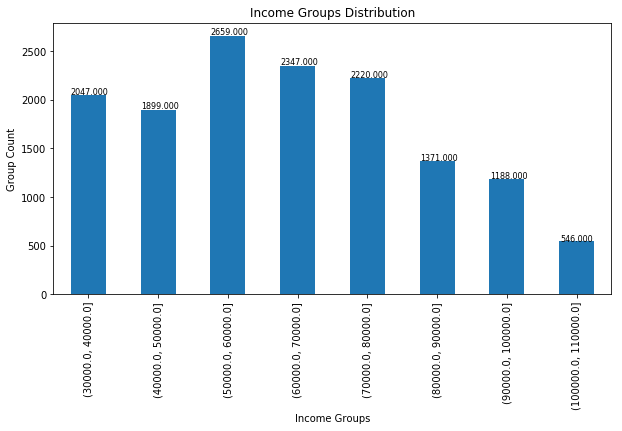

In [32]:
plot_bar_with_annoation(data=Income_groups, title='Income Groups Distribution',xlabel='Income Groups', ylabel='Group Count')

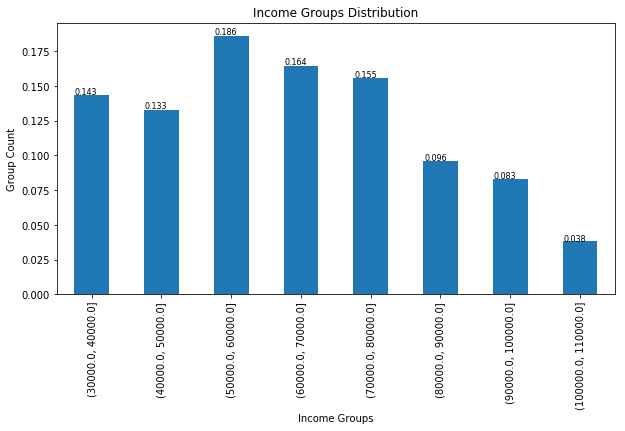

In [33]:
# percentage of each group 
plot_bar_with_annoation(data=Income_groups/Income_groups.sum(), title='Income Groups Distribution',xlabel='Income Groups', ylabel='Group Count')

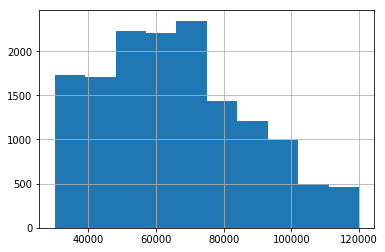

In [56]:
profile.income.hist()

We notice that most people are in 40k-80k income range which seem like the value that divide the income groups. and the smallest group was for the highest earners.
the histogram seems like a left skewed plot.
19% of the earners are in the 50k-60k income range.

### 2) Gender Distribution 
plot the distribution of genders across profiles

In [57]:
profile.gender.value_counts()/profile.gender.value_counts().sum()

M    0.580579
F    0.419421
Name: gender, dtype: float64

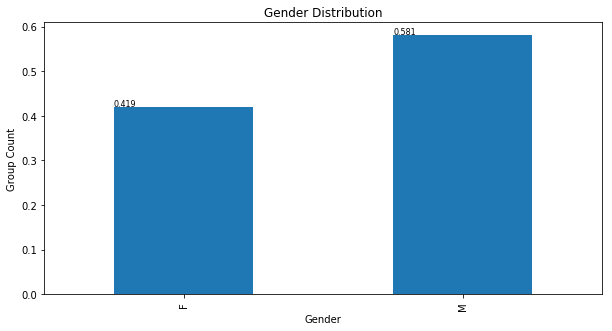

In [58]:
# gender
gender_groups = profile.groupby(['gender'])['customer_id'].count()/profile.gender.value_counts().sum()
plot_bar_with_annoation(data=gender_groups, title='Gender Distribution',xlabel='Gender', ylabel='Group Count')

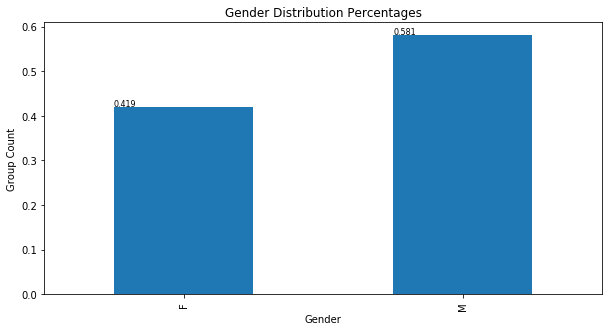

In [59]:
gender_groups = profile.groupby(['gender'])['customer_id'].count()/profile.gender.value_counts().sum()
plot_bar_with_annoation(data=gender_groups, title='Gender Distribution Percentages',xlabel='Gender', ylabel='Group Count')

The Data contains more Males than females in this dataset. we have 58% Males registerd users compared to 42% registered Female users. 

### 3) Age Groups Distribution
    To create the age groups where the columns will be divied with a 10 range starting from the min age of 18 till the maximum age of 101.

In [60]:
profile.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [61]:
# Age  Groups 
age_groups = profile.groupby(pd.cut(profile['age'], np.arange(profile['age'].min(), profile['age'].max(), 10)))['customer_id'].count()
age_groups

age
(18.0, 28.0]    1375
(28.0, 38.0]    1473
(38.0, 48.0]    2170
(48.0, 58.0]    3503
(58.0, 68.0]    3108
(68.0, 78.0]    1907
(78.0, 88.0]     895
(88.0, 98.0]     302
Name: customer_id, dtype: int64

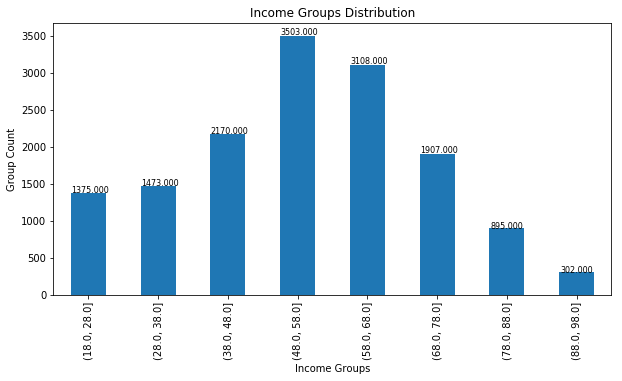

In [62]:
plot_bar_with_annoation(data=age_groups, title='Income Groups Distribution',xlabel='Income Groups', ylabel='Group Count')

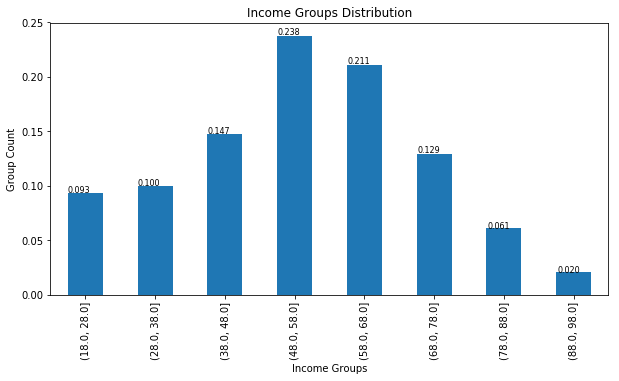

In [63]:
# percentage
plot_bar_with_annoation(data=age_groups/age_groups.sum(), title='Income Groups Distribution',xlabel='Income Groups', ylabel='Group Count')

The age group with the highest percentage in the members is 48-58 with 24%. the age distribution follows a normal distribution curve. and the least group consists of the older generation from 88 - 98 years.

The curve follows a normal distribution.

### 3) Joining date for members

In [64]:
profile.head()

age became_member_on gender                       customer_id    income  \
0   NaN       2017-02-12    NaN  68be06ca386d4c31939f3a4f0e3dd783       NaN   
1  55.0       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
2   NaN       2018-07-12    NaN  38fe809add3b4fcf9315a9694bb96ff5       NaN   
3  75.0       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
4   NaN       2017-08-04    NaN  a03223e636434f42ac4c3df47e8bac43       NaN   

   membership_year  membership_month  membership_day  
0             2017                 2              12  
1             2017                 7              15  
2             2018                 7              12  
3             2017                 5               9  
4             2017                 8               4

In [65]:
membership_year_month_group = profile.groupby(profile['became_member_on'].dt.to_period('M'))['customer_id'].count()
membership_year_month_group

became_member_on
2013-07      5
2013-08     68
2013-09     57
2013-10     56
2013-11     48
2013-12     52
2014-01     64
2014-02     57
2014-03     56
2014-04     64
2014-05     66
2014-06     60
2014-07     56
2014-08     58
2014-09     56
2014-10     49
2014-11     55
2014-12     50
2015-01     64
2015-02     63
2015-03     61
2015-04     58
2015-05     68
2015-06     56
2015-07     69
2015-08    293
2015-09    295
2015-10    271
2015-11    259
2015-12    273
          ... 
2016-02    288
2016-03    308
2016-04    310
2016-05    298
2016-06    289
2016-07    319
2016-08    305
2016-09    271
2016-10    292
2016-11    271
2016-12    281
2017-01    294
2017-02    277
2017-03    286
2017-04    298
2017-05    274
2017-06    298
2017-07    404
2017-08    886
2017-09    836
2017-10    900
2017-11    816
2017-12    900
2018-01    809
2018-02    517
2018-03    618
2018-04    585
2018-05    601
2018-06    562
2018-07    506
Freq: M, Name: customer_id, Length: 61, dtype: int64

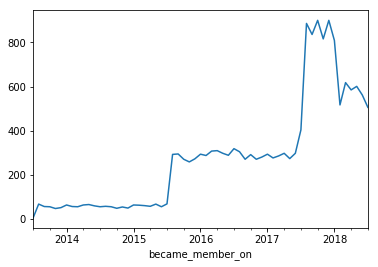

In [66]:
membership_year_month_group.plot.line()

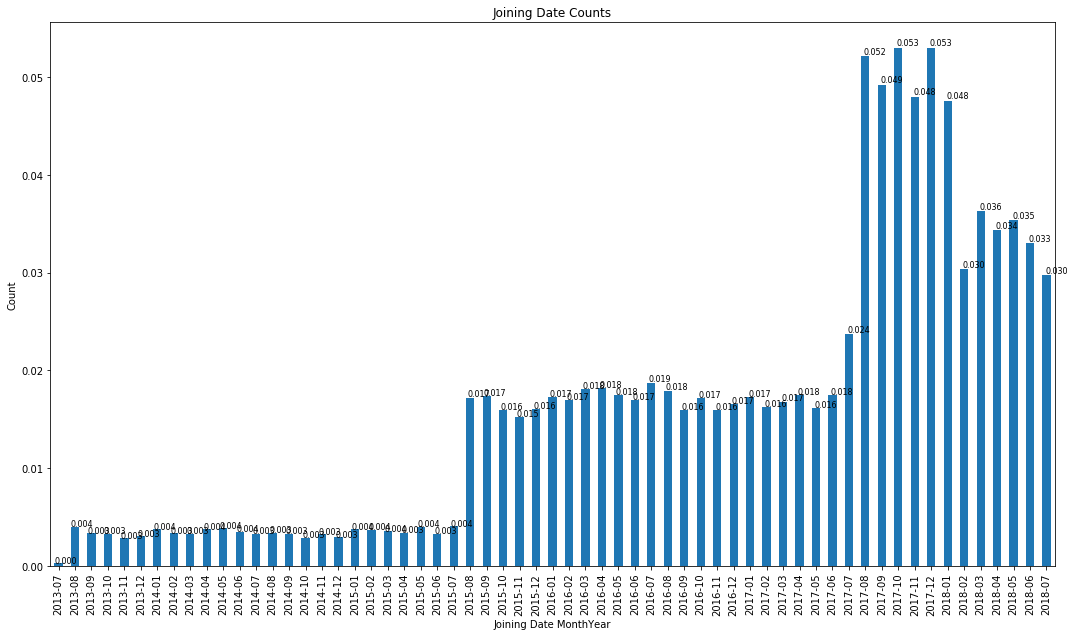

In [67]:
plot_bar_with_annoation(data=membership_year_month_group/membership_year_month_group.sum(), title='Joining Date Counts',xlabel='Joining Date MonthYear', ylabel='Count', figsize=(18,10))

In [68]:
# qurater 
membership_quarterly = profile.groupby(profile['became_member_on'].dt.to_period('Q'))['customer_id'].count()
membership_quarterly

became_member_on
2013Q3     130
2013Q4     156
2014Q1     177
2014Q2     190
2014Q3     170
2014Q4     154
2015Q1     188
2015Q2     182
2015Q3     657
2015Q4     803
2016Q1     890
2016Q2     897
2016Q3     895
2016Q4     844
2017Q1     857
2017Q2     870
2017Q3    2126
2017Q4    2616
2018Q1    1944
2018Q2    1748
2018Q3     506
Freq: Q-DEC, Name: customer_id, dtype: int64

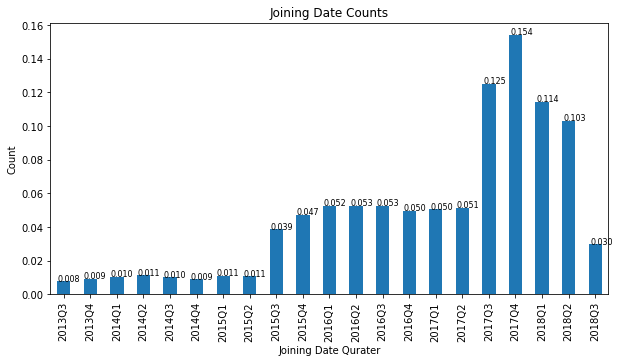

In [69]:
plot_bar_with_annoation(data=membership_quarterly/membership_quarterly.sum(), title='Joining Date Counts',xlabel='Joining Date Qurater', ylabel='Count')

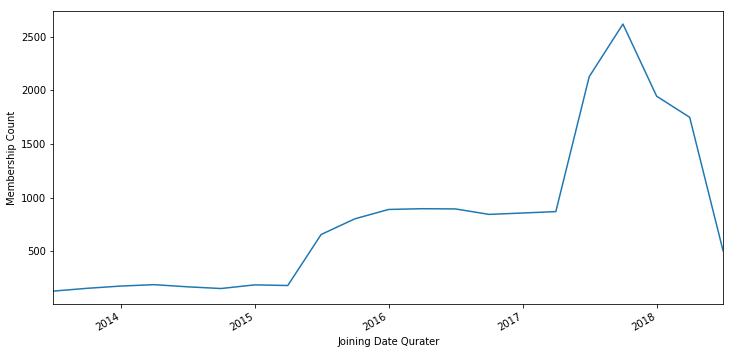

In [70]:
ax = membership_quarterly.plot.line(figsize=(12,6),x_compat=True);

ax.set_ylabel('Membership Count');
ax.set_xlabel('Joining Date Qurater');

From the figures above we can see that there was in boost in the memberships during the third qurater of 2017 and the peak of memberships  at the Q4. from 2017 Q2 to Q3 2017 there was an increase of 160% compared to Q2 of 2017.

The region of the increased memeberships range from August 2017 - Feb 2018.


### Offers Distribution 

In [71]:
transcript.head()

event                       customer_id  time  amount  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0     NaN   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0     NaN   
2  offer received  e2127556f4f64592b11af22de27a7932     0     NaN   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0     NaN   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0     NaN   

                           offer_id  time_days  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9        0.0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7        0.0  
2  2906b810c7d4411798c6938adc9daaa5        0.0  
3  fafdcd668e3743c1bb461111dcafc2a4        0.0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0        0.0

In [72]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [73]:
event_groups = transcript.groupby(['event'])['customer_id'].count()
event_groups.head()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: customer_id, dtype: int64

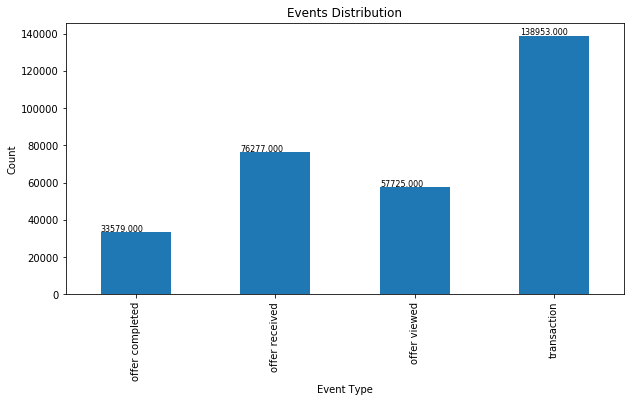

In [74]:
plot_bar_with_annoation(data=event_groups, title='Events Distribution',xlabel='Event Type', ylabel='Count')

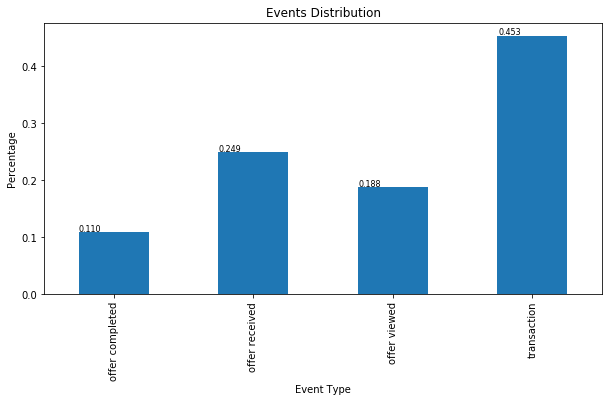

In [75]:
plot_bar_with_annoation(data=event_groups/event_groups.sum(), title='Events Distribution',xlabel='Event Type', ylabel='Percentage')

The events are segmented into 45% transactions, 25% recieved offers, 19% viewed offers and 11% completed offers.

## Feature Engineering

In this section we look into the features that will be used in the analysis.
 
- Validate the viewed, completed and recieved offers and create customer transactions and stats.

- Create RFM Clusters.

- Handle missing values for age, gender and income.

- Handle categorical variables.

- Remove unneccassry columns for the analysis


#### Handling the offers events and the transactions

In this section. we need to validate the transactions that occurred as a result of viewing the offer or it is an independent event.

The issue is that the transaction event is not assoicated with an offer_id only an amount, furthermore the informational offers don't have offer completed with them so this needs to be handled 

The offers is considered effective if it was:

- BOGO and discount offers: 
    offer_time_recieved < offer_time_viewed < transaction_time < offer_time_completed < offer_end_time (within the time validaity)
    
- Informational offers:
    offer_time_recieved < offer_time_viewed < transaction_time < offer_end_time
    
After finding the effective offers. we can split the customers into 4 groups:

    1) people who responded to offers and completed an offer (TR)
    
    2) people who viewed an offer but did not complete the offer(TN)
    
    3) people who have not recieved an offer or have not viewed the offer and have not made a completed the offer(CN)
    
    4) people who have not recieved an offer or have not viewed the offer but have completed the offer(CR)

In [42]:
# merge the offer with offer portofolio 
transcript_df = transcript.merge(portfolio, on ='offer_id', how='left')
transcript_df.head()

event                       customer_id  time  amount                          offer_id  time_days  difficulty  duration offer_type  reward  mobile  web  social  email
0  offer received  78afa995795e4d85b5d9ceeca43f5fef  0    NaN      9b98b8c7a33c4b65b9aebfe6a799e6d9  0.0        5.0         7.0       bogo       5.0     1.0     1.0  0.0     1.0  
1  offer received  a03223e636434f42ac4c3df47e8bac43  0    NaN      0b1e1539f2cc45b7b9fa7c272da2e1d7  0.0        20.0        10.0      discount   5.0     0.0     1.0  0.0     1.0  
2  offer received  e2127556f4f64592b11af22de27a7932  0    NaN      2906b810c7d4411798c6938adc9daaa5  0.0        10.0        7.0       discount   2.0     1.0     1.0  0.0     1.0  
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586  0    NaN      fafdcd668e3743c1bb461111dcafc2a4  0.0        10.0        10.0      discount   2.0     1.0     1.0  1.0     1.0  
4  offer received  68617ca6246f4fbc85e91a2a49552598  0    NaN      4d5c57ea9a6940dd891ad53e9dbe8da0  0.0        10.0        5.0       bogo       10.0    1.0     1.0  1.0     1.0

In [51]:
transcript_df.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

In [52]:
transcript_df[transcript_df.event !='transaction'].sort_values(['customer_id', 'time'])

event                       customer_id  time  amount                          offer_id  time_days  difficulty  duration     offer_type  reward  email  web  mobile  social
55972   offer received   0009655768c64bdeb2e877511632db8f  168  NaN      5a8bc65990b245e5a138643cd4eb9837  7.00       0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0   
77705   offer viewed     0009655768c64bdeb2e877511632db8f  192  NaN      5a8bc65990b245e5a138643cd4eb9837  8.00       0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0   
113605  offer received   0009655768c64bdeb2e877511632db8f  336  NaN      3f207df678b143eea3cee63160fa8bed  14.00      0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
139992  offer viewed     0009655768c64bdeb2e877511632db8f  372  NaN      3f207df678b143eea3cee63160fa8bed  15.50      0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
153401  offer received   0009655768c64bdeb2e877511632db8f  408  NaN      f19421c1d4aa40978ebb69ca19b0e20d  17.00      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
168413  offer completed  0009655768c64bdeb2e877511632db8f  414  NaN      f19421c1d4aa40978ebb69ca19b0e20d  17.25      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
187554  offer viewed     0009655768c64bdeb2e877511632db8f  456  NaN      f19421c1d4aa40978ebb69ca19b0e20d  19.00      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
204340  offer received   0009655768c64bdeb2e877511632db8f  504  NaN      fafdcd668e3743c1bb461111dcafc2a4  21.00      10.0        10.0      discount       2.0     1.0    1.0  1.0     1.0   
228423  offer completed  0009655768c64bdeb2e877511632db8f  528  NaN      fafdcd668e3743c1bb461111dcafc2a4  22.00      10.0        10.0      discount       2.0     1.0    1.0  1.0     1.0   
233413  offer viewed     0009655768c64bdeb2e877511632db8f  540  NaN      fafdcd668e3743c1bb461111dcafc2a4  22.50      10.0        10.0      discount       2.0     1.0    1.0  1.0     1.0   
247879  offer received   0009655768c64bdeb2e877511632db8f  576  NaN      2906b810c7d4411798c6938adc9daaa5  24.00      10.0        7.0       discount       2.0     1.0    1.0  1.0     0.0   
258884  offer completed  0009655768c64bdeb2e877511632db8f  576  NaN      2906b810c7d4411798c6938adc9daaa5  24.00      10.0        7.0       discount       2.0     1.0    1.0  1.0     0.0   
56475   offer received   00116118485d4dfda04fdbaba9a87b5c  168  NaN      f19421c1d4aa40978ebb69ca19b0e20d  7.00       5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
85769   offer viewed     00116118485d4dfda04fdbaba9a87b5c  216  NaN      f19421c1d4aa40978ebb69ca19b0e20d  9.00       5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
248359  offer received   00116118485d4dfda04fdbaba9a87b5c  576  NaN      f19421c1d4aa40978ebb69ca19b0e20d  24.00      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
284472  offer viewed     00116118485d4dfda04fdbaba9a87b5c  630  NaN      f19421c1d4aa40978ebb69ca19b0e20d  26.25      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
3066    offer received   0011e0d4e6b944f998e987f904e8c1e5  0    NaN      3f207df678b143eea3cee63160fa8bed  0.00       0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
16179   offer viewed     0011e0d4e6b944f998e987f904e8c1e5  6    NaN      3f207df678b143eea3cee63160fa8bed  0.25       0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
56298   offer received   0011e0d4e6b944f998e987f904e8c1e5  168  NaN      2298d6c36e964ae4a3e7e9706d1fb8c2  7.00       7.0         7.0       discount       3.0     1.0    1.0  1.0     1.0   
75427   offer viewed     0011e0d4e6b944f998e987f904e8c1e5  186  NaN      2298d6c36e964ae4a3e7e9706d1fb8c2  7.75       7.0         7.0       discount       3.0     1.0    1.0  1.0     1.0   
95422   offer completed  001

In [53]:
# for customer id = '00116118485d4dfda04fdbaba9a87b5c'
transcript_df[(transcript_df.event !='transaction') & (transcript_df.customer_id=='00116118485d4dfda04fdbaba9a87b5c')].sort_values(['customer_id', 'time'])

event                       customer_id  time  amount                          offer_id  time_days  difficulty  duration offer_type  reward  email  web  mobile  social
56475   offer received  00116118485d4dfda04fdbaba9a87b5c  168  NaN      f19421c1d4aa40978ebb69ca19b0e20d  7.00       5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0   
85769   offer viewed    00116118485d4dfda04fdbaba9a87b5c  216  NaN      f19421c1d4aa40978ebb69ca19b0e20d  9.00       5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0   
248359  offer received  00116118485d4dfda04fdbaba9a87b5c  576  NaN      f19421c1d4aa40978ebb69ca19b0e20d  24.00      5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0   
284472  offer viewed    00116118485d4dfda04fdbaba9a87b5c  630  NaN      f19421c1d4aa40978ebb69ca19b0e20d  26.25      5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0

In [54]:
transcript_df[(transcript_df.event !='transaction') & (transcript_df.customer_id=='0009655768c64bdeb2e877511632db8f')].sort_values(['customer_id', 'time'])

event                       customer_id  time  amount                          offer_id  time_days  difficulty  duration     offer_type  reward  email  web  mobile  social
55972   offer received   0009655768c64bdeb2e877511632db8f  168  NaN      5a8bc65990b245e5a138643cd4eb9837  7.00       0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0   
77705   offer viewed     0009655768c64bdeb2e877511632db8f  192  NaN      5a8bc65990b245e5a138643cd4eb9837  8.00       0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0   
113605  offer received   0009655768c64bdeb2e877511632db8f  336  NaN      3f207df678b143eea3cee63160fa8bed  14.00      0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
139992  offer viewed     0009655768c64bdeb2e877511632db8f  372  NaN      3f207df678b143eea3cee63160fa8bed  15.50      0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
153401  offer received   0009655768c64bdeb2e877511632db8f  408  NaN      f19421c1d4aa40978ebb69ca19b0e20d  17.00      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
168413  offer completed  0009655768c64bdeb2e877511632db8f  414  NaN      f19421c1d4aa40978ebb69ca19b0e20d  17.25      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
187554  offer viewed     0009655768c64bdeb2e877511632db8f  456  NaN      f19421c1d4aa40978ebb69ca19b0e20d  19.00      5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0   
204340  offer received   0009655768c64bdeb2e877511632db8f  504  NaN      fafdcd668e3743c1bb461111dcafc2a4  21.00      10.0        10.0      discount       2.0     1.0    1.0  1.0     1.0   
228423  offer completed  0009655768c64bdeb2e877511632db8f  528  NaN      fafdcd668e3743c1bb461111dcafc2a4  22.00      10.0        10.0      discount       2.0     1.0    1.0  1.0     1.0   
233413  offer viewed     0009655768c64bdeb2e877511632db8f  540  NaN      fafdcd668e3743c1bb461111dcafc2a4  22.50      10.0        10.0      discount       2.0     1.0    1.0  1.0     1.0   
247879  offer received   0009655768c64bdeb2e877511632db8f  576  NaN      2906b810c7d4411798c6938adc9daaa5  24.00      10.0        7.0       discount       2.0     1.0    1.0  1.0     0.0   
258884  offer completed  0009655768c64bdeb2e877511632db8f  576  NaN      2906b810c7d4411798c6938adc9daaa5  24.00      10.0        7.0       discount       2.0     1.0    1.0  1.0     0.0

We can see that the above user recieved the same offer twice for customer_id =00116118485d4dfda04fdbaba9a87b5c
and an issue is there for customer '0009655768c64bdeb2e877511632db8f' where for offer fafdcd668e3743c1bb461111dcafc2a4 where he received and completed the offer while the viewed event happend later.     

In [55]:
transcript_df[transcript_df.event !='transaction'].sort_values(['customer_id', 'time']).head()

event                       customer_id  time  amount                          offer_id  time_days  difficulty  duration     offer_type  reward  email  web  mobile  social
55972   offer received  0009655768c64bdeb2e877511632db8f  168  NaN      5a8bc65990b245e5a138643cd4eb9837  7.0        0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0   
77705   offer viewed    0009655768c64bdeb2e877511632db8f  192  NaN      5a8bc65990b245e5a138643cd4eb9837  8.0        0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0   
113605  offer received  0009655768c64bdeb2e877511632db8f  336  NaN      3f207df678b143eea3cee63160fa8bed  14.0       0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
139992  offer viewed    0009655768c64bdeb2e877511632db8f  372  NaN      3f207df678b143eea3cee63160fa8bed  15.5       0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0   
153401  offer received  0009655768c64bdeb2e877511632db8f  408  NaN      f19421c1d4aa40978ebb69ca19b0e20d  17.0       5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0

In [43]:
all_offers = transcript_df.sort_values(['customer_id', 'time'])
all_offers.head()

event                       customer_id  time  amount                          offer_id  time_days  difficulty  duration     offer_type  reward  mobile  web  social  email
55972   offer received  0009655768c64bdeb2e877511632db8f  168  NaN      5a8bc65990b245e5a138643cd4eb9837  7.0        0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0  
77705   offer viewed    0009655768c64bdeb2e877511632db8f  192  NaN      5a8bc65990b245e5a138643cd4eb9837  8.0        0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0  
89291   transaction     0009655768c64bdeb2e877511632db8f  228   22.16   NaN                               9.5       NaN         NaN        NaN           NaN     NaN     NaN  NaN     NaN   
113605  offer received  0009655768c64bdeb2e877511632db8f  336  NaN      3f207df678b143eea3cee63160fa8bed  14.0       0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0  
139992  offer viewed    0009655768c64bdeb2e877511632db8f  372  NaN      3f207df678b143eea3cee63160fa8bed  15.5       0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0

In [57]:
all_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 55972 to 289924
Data columns (total 14 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
amount         138953 non-null float64
offer_id       167581 non-null object
time_days      306534 non-null float64
difficulty     167581 non-null float64
duration       167581 non-null float64
offer_type     167581 non-null object
reward         167581 non-null float64
email          167581 non-null float64
web            167581 non-null float64
mobile         167581 non-null float64
social         167581 non-null float64
dtypes: float64(9), int64(1), object(4)
memory usage: 35.1+ MB


In [58]:
all_offers[(all_offers.customer_id=='00116118485d4dfda04fdbaba9a87b5c') & (all_offers.event!='transaction')]

event                       customer_id  time  amount                          offer_id  time_days  difficulty  duration offer_type  reward  email  web  mobile  social
56475   offer received  00116118485d4dfda04fdbaba9a87b5c  168  NaN      f19421c1d4aa40978ebb69ca19b0e20d  7.00       5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0   
85769   offer viewed    00116118485d4dfda04fdbaba9a87b5c  216  NaN      f19421c1d4aa40978ebb69ca19b0e20d  9.00       5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0   
248359  offer received  00116118485d4dfda04fdbaba9a87b5c  576  NaN      f19421c1d4aa40978ebb69ca19b0e20d  24.00      5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0   
284472  offer viewed    00116118485d4dfda04fdbaba9a87b5c  630  NaN      f19421c1d4aa40978ebb69ca19b0e20d  26.25      5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0

So in order to get the customers groups and create the uplift modeling. The following steps will be followed for each customer_id:

    1) Split each customer assoicated transcripts dataframe on the event type into received, viewed, completed and transactions.
    2) Find the offers that has been recieved and completed --> create 2 columns; the completion and offer finish time (by the user)
    3) Get the viewed and successful offers --> viewed and successful flag plus the offer view time
    4) handle informational offers since the offer completion is not available as mentioned before.
    5) get the transactions summary(amount spent during the offer, profit, non offer spent)
    6) get each user stats: number of offers completed. number of completed offer for each offer type
    7) assign to a group 

In [34]:
def split_transcripts_on_offer_type(transcript):
    """
        This Method splits the transcripts dataframe into 4 dataframes based on the event type
        Args:
            transcript(pd.DataFrame): Dataframe for the transcripts
        Returns:
            transactions(pd.DataFrame): contains the transaction events 
            viewed_offers(pd.DataFrame): contains the viewed events 
            recieved_offers(pd.DataFrame): contains the recieved events 
            completed_offers(pd.DataFrame): contains the completed events 
    """
    received = transcript[transcript.event == 'offer received']
    completed = transcript[transcript.event == 'offer completed']
    viewed = transcript[transcript.event == 'offer viewed']
    transactions = transcript[transcript.event == 'transaction']
    
    return received, completed, viewed, transactions

def create_split_offers_df(transcript):
    """
    
        split the offers, add and remove redundent columns from dataframes
    """
    received, completed, viewed, transactions = split_transcripts_on_offer_type(transcript)
    
    received.rename(columns={'time':'time_received'}, inplace=True)
    
    received.drop(columns=['event', 'amount','time_days'], inplace=True, axis =1)
    
    # add expected finish time to the received data frame
    # duration is in days while time is in hours
    received['expected_finish'] = received.time_received + received.duration * 24
    
    drop_cols = ['event', 'difficulty', 'duration', 'offer_type', 'reward',\
                'email', 'mobile', 'social', 'web', 'amount','time_days']
    viewed.rename(columns={'time':'time_viewed'}, inplace=True)
    viewed.drop(columns=drop_cols, inplace=True, axis =1)

    
    drop_cols = ['event', 'difficulty', 'duration', 'offer_type', 'reward',\
                'email', 'mobile', 'social', 'web', 'amount','time_days']
    completed.rename(columns={'time':'time_completed'}, inplace=True)
    completed.drop(columns=drop_cols, inplace=True, axis =1)
    drop_cols = ['event', 'difficulty', 'duration', 'offer_type', 'reward',\
                'email', 'mobile', 'social', 'web','offer_id','time_days'] 
    transactions.rename(columns={'time':'transaction_time'}, inplace=True)
    transactions.drop(columns=drop_cols, inplace=True, axis =1)

    return received, completed, viewed, transactions

In [54]:
def get_completed_set(recieved_row, completed):
    """
        This method returns completed and the offer time completion time
        Args:
            recieved_row: dataframe containing received events
            completed: dataframe containing completed events
        Returns:
            completed_flag : 1 if the offer was completed on time
            expected_finish: offer completion time
        
    """
    completed_flag = 0
    finish_time_flag = recieved_row.expected_finish
    
    completed_set = completed[(completed.offer_id == recieved_row.offer_id) &
                               (completed.time_completed >= recieved_row.time_received) &
                               (completed.time_completed <= recieved_row.expected_finish)]
    if(len(completed_set)>0):
        completed_flag = 1
        finish_time_flag = completed_set.time_completed.iloc[0]
    return pd.Series([completed_flag, finish_time_flag], index=['completed','finish'])

def get_viewed_set(row_received ,  viewed):
    """
        This method returns viewed, offer view time and success 
        A transaction is considered successful if it was completed and viewed within the offer duration
        if it was viewed before the time it was compelted (finish) that mean it was completed before being viewed 
        Args:
            recieved_row: dataframe containing completed events
            completed: dataframe containing completed events
        Returns:
            viewed : 1 if the offer was viewed
            view_time: offer view time
            success: succesful offer
    """
    viewed_flag = 0
    view_time = np.nan
    success = 0
    
    viewed_set = viewed[(viewed.offer_id == row_received.offer_id) &
                   (viewed.time_viewed >= row_received.time_received) &
                   (viewed.time_viewed <= row_received.finish)]
    if(len(viewed_set)>0):
        viewed_flag = 1
        view_time = viewed_set.time_viewed.iloc[0]
        success = 1 if row_received.completed else 0
        
    return pd.Series([viewed_flag, success, view_time], index=['viewed','success', 'view_time'])     

def handle_completed_recieved(received, completed):
    """
        This Method takes the recieved offers and the compeleted offers 
        then returns completed an finish time 
        Args:
            recieved: dataframe containing received events
            completed: dataframe containing completed events
        Returns:
            recieved dataframe updated with the completed and offer finish time
    """
    
    recieved_updated = received.copy()
    recieved_updated[['completed','finish']] = recieved_updated.apply(lambda row: get_completed_set(row, completed), axis=1)
    return recieved_updated

def handle_viewed_completed(received_modified, viewed):
    """
        This Method takes the updated recieved dataframe and the viewed offers 
        then returns successful offers, viewed, and offer view time
        Args:
            recieved: dataframe containing received events
            completed: dataframe containing completed events
        Returns:
            recieved dataframe updated with the completed and offer finish time
    """
    viewed_updated = received_modified.copy()
    viewed_updated[['viewed','success', 'view_time']] = viewed_updated.apply(lambda row: get_viewed_set(row, viewed), axis=1)
    
    return viewed_updated

def handle_completed_not_viewed(viewed):
    """
        This Method takes the updated recieved dataframe 
        then returns completed_not viewed offers
        (offers that have been completed but are not viewed nor successful)
        Args:
            recieved: dataframe containing received events
            completed: dataframe containing completed events
        Returns:
            recieved dataframe updated with the completed and offer finish time
    """
    viewed_modified = viewed.copy()
    viewed_modified['completed_not_viewed'] = 0
    condition = (viewed_modified.completed==1) & (viewed_modified.viewed==0) & (viewed_modified.success==0)
    viewed_modified.loc[condition,'completed_not_viewed'] = 1
    
    return viewed_modified

def get_successful_informational_transactions(row, transactions):
    """
      This Method takes the updated merged recieved and the viewed for informational offers 
        then find completed offers from these
        Args:
            row: merged received and viewed offers 
            transactions: dataframe containing transactions
        Returns:
            success if the transaction was compeleted during the promotion period
    """  
    transaction_condition = (transactions.transaction_time >=row.time_received) & ((transactions.transaction_time <=row.expected_finish))
    success = 1 if len(transactions[transaction_condition] ) > 0 else 0
    return pd.Series([success],index =['success'] )
        
def handle_informational_offers(transactions, data):
    """
    This function handles the case of informational offers since it does not have offer completed event
    viewed offers and transaction within the 
    Args:
            transactions customer transactions dataframe
            received offers dataframe 
            viewed offers dataframe
    Returns:
        viewed , success  
    """
    
    
    # we want informational offers that conform with the following condition
    # time_received <= time_viewed <= offer duration
    data_modified = data.copy()
    validation_condition = (data_modified.viewed == 1)&\
                           (data_modified.offer_type=='informational')
    
    # get the transactions within the condition time 
    data_modified.loc[validation_condition,'success'] = data_modified[validation_condition].apply(lambda row: get_successful_informational_transactions(row, transactions), axis=1)
    
    data_modified.loc[validation_condition,'completed'] = data_modified.loc[validation_condition,'success']
    
    return data_modified

def get_transaction_stats(row, transactions):
    """
        This function gets the summary for each offer 
        - sums all amount of transactions during the offer time 
        - get the offer_profit of offer
        - non offer transactions sum
        - assume for non offer transaction that the amount of profit ==non offer sum
    """     
    total_spent_offer = 0
    total_spent_non_offer = 0
    profit = 0
    # non offer profit is the amount spent 
    # if the offer is success the spent sum transactions from view_time till expected finish
    if row.viewed == 1:
        transactions_offer = transactions[(transactions.transaction_time>= row.view_time ) & (transactions.transaction_time<= row.expected_finish )]
        total_spent_offer =  transactions_offer.amount.sum()
        transactions_non_offer = transactions[(transactions.transaction_time < row.view_time ) & (transactions.transaction_time >= row.time_received )]
        total_spent_non_offer =  transactions_non_offer.amount.sum()
        cost = row.reward if row.completed == 1 else 0
        profit = total_spent_offer - cost
    else:
        transactions_non_offer = transactions[(transactions.transaction_time>= row.time_received ) & (transactions.transaction_time<= row.expected_finish )]
        total_spent_non_offer =  transactions_non_offer.amount.sum()
        cost = row.reward if row.completed == 1 else 0
        profit = total_spent_non_offer - cost
        
    total_spent = total_spent_non_offer + total_spent_offer            
    return pd.Series([total_spent_offer, total_spent_non_offer, profit, total_spent],index =['total_spent_offer','total_spent_non_offer','profit', 'total_spent'] )

def enhance_transaction_df(transactions, offers):
    """
        This function calculates the customer amount spent during offer, profit_offer, non_offer perios
        
    """
    transaction_updated = offers.copy()
    transaction_updated[['total_spent_offer','total_spent_non_offer','profit', 'total_spent']] = transaction_updated.apply(lambda row: get_transaction_stats(row, transactions), axis=1)    
    return transaction_updated

def get_has_profit(row):
    """
        This method returns if this transaction has profit or no 
    """
    has_profit = 1 if (( row.viewed == 1 and row.profit > 0) or (row.viewed == 0 and row.total_spent_non_offer > 0)) else 0
    return pd.Series([has_profit],index =['has_profit'] )

def get_completed_offer(row):
    """
        This method returns if this offer was completed or not 
    """
    completed_offer = 1 if (( row.completed == 1 ) or (row.completed_not_viewed == 1)) else 0
    return pd.Series([completed_offer],index =['completed_offer'] )

def get_user_stats(offers):
    """
        This function gets the summary for each offer 
        - get the number of bogo completed, num of completed offers, num of compelted discounts
        - has_profit if the profit more than 0 for non offer if it is more than 1 then it an offer
    """
    offers_modified = offers.copy()
    offers_modified['num_bogo_completed'] = [offers_modified[offers_modified.offer_type=='bogo']['completed'].sum()] * len(offers_modified)
    offers_modified['num_discount_completed'] = [offers_modified[offers_modified.offer_type=='discount']['completed'].sum()] * len(offers_modified)    
    offers_modified['num_informational_completed'] = [offers_modified[offers_modified.offer_type=='informational']['completed'].sum()] * len(offers_modified)
    offers_modified['successful_offers'] = [offers_modified['success'].sum()] * len(offers_modified)
    offers_modified['non_successful_offers'] = [offers_modified[offers_modified.success == 0]['success'].count()] * len(offers_modified)
    offers_modified['completed_offer'] = offers_modified.apply(lambda row: get_completed_offer(row), axis=1)
    return offers_modified
    
def get_user_group(offers):
    """
        This functions divides the customers into TR, TN, CN, CR. the group we will be assumed as fo
        TR: customers who viewed and completed an offer (success = 1)
        TN: customers who viewed the offer did not complete it 
        CR: Customers who compelted the offer without viewing the offer (will assume those who have spent more before viewing the offer in this group)
        CN: Customers who did not compelted the offer nor viewed it.
    """
    offers_modified = offers.copy()
    TR_CONDITION = (offers_modified.success == 1.0 ) | ((offers_modified.viewed == 1.0) & (offers_modified.completed == 1.0)) & (offers_modified.total_spent_offer>offers_modified.total_spent_non_offer)
    TN_CONDITION = ((offers_modified.viewed == 1.0) & (offers_modified.completed == 0))
    CR_CONDITION = (offers_modified.completed_not_viewed == 1) | ((offers_modified.viewed == 1.0) & (offers_modified.completed == 1.0) & (offers_modified.total_spent_offer<offers_modified.total_spent_non_offer))
    offers_modified['segment'] = ['CN'] * len(offers_modified)    
    offers_modified.loc[TR_CONDITION,'segment'] =  'TR'
    offers_modified.loc[TN_CONDITION,'segment'] =  'TN'
    offers_modified.loc[CR_CONDITION,'segment'] =  'CR'
    return offers_modified

def get_user_group_purchase(offers):
    """
    # assume those who spend more on the total_spent_non_offer than spent_offer are CR not TR 
        This functions divides the customers into TR, TN, CN, CR. the group we will be assumed as fo
        TR: customers who viewed and purchased an offer (success = 1)
        TN: customers who viewed the offer did not purchase anything after the offer 
        CR: Customers who purchased without viewing the offer
        CN: Customers who did not compelted the offer nor purchased it.
    """
    offers_modified = offers.copy()
    TR_CONDITION = (offers_modified.success == 1.0 ) | ((offers_modified.viewed == 1.0) & (offers_modified.completed == 1.0)) | ((offers_modified.viewed == 1.0) & (offers_modified.total_spent_offer>0))
    TN_CONDITION = ((offers_modified.viewed == 1.0) & (offers_modified.total_spent_offer == 0))
    CR_CONDITION = (offers_modified.completed_not_viewed == 1) | (((offers_modified.viewed == 0.0) & (offers_modified.total_spent_non_offer>0)))
    offers_modified['segment'] = ['CN'] * len(offers_modified)    
    offers_modified.loc[TR_CONDITION,'segment'] =  'TR'
    offers_modified.loc[TN_CONDITION,'segment'] =  'TN'
    offers_modified.loc[CR_CONDITION,'segment'] =  'CR'
    return offers_modified

In [61]:
def offer_analysis(transcript):
    """
    This functions looks into offers and create the following columns
    viewed_offer, sucessful_offer(recieved,viewed and completed), tried_offer(received, viewed & not completed), 
    
    """
    received, completed, viewed, transactions = create_split_offers_df(transcript)
    # skip when the user has only transactions:
    customer_offers_modified = received
    if len(received) > 0:
            # handle the recieved completed offers completed, finish 
            customer_offers_modified = handle_completed_recieved(received, completed)
            # handle viewed & completed --> sucess and we get finish time [if success TR group 1 else TN]
            customer_offers_modified = handle_viewed_completed(customer_offers_modified, viewed)

            # handle informational offers for completed offers
            customer_offers_modified = handle_informational_offers(transactions, customer_offers_modified)

            # handle not viewed & completed  --> does not need a special handle it is accounted using existening columns
            # this might be redundet (viewed & complete but not successful which means not an offer)
            customer_offers_modified = handle_completed_not_viewed(customer_offers_modified)

            # get the transactions amount and offer id 
            customer_offers_modified = enhance_transaction_df(transactions, customer_offers_modified)

            #[num of offers completed for each offer id, num of offers viewed depending on type, num of all offers completed ]
            customer_offers_modified = get_user_stats(customer_offers_modified)

            #segment groups 
            customer_offers_modified = get_user_group(customer_offers_modified)

            return customer_offers_modified

    else:
        return None


def get_offer_df(all_offers):
    """
        This function creates the offer dataframe for all customers 
    """
    tqdm.pandas()
    return all_offers.groupby('customer_id').progress_apply(offer_analysis).reset_index(drop=True)

def test1(all_offers):
    """
        Test function to show the results for a subset for one customer
    """
    tqdm.pandas()
    customers_transactions_test = pd.DataFrame()
    customers_list = list(all_offers.customer_id.unique())
    for customer in customers_list[:50]:
        customer_transcripts = all_offers[all_offers.customer_id == customer]
        offer_test = offer_analysis(customer_transcripts)
        customers_transactions_test = pd.concat([customers_transactions_test, offer_test])
    return customers_transactions_test

def test2(all_offers):
    tqdm.pandas()
    all_offers_subset = all_offers[all_offers.customer_id.isin(all_offers.customer_id.unique()[:50])]   
    return all_offers_subset.groupby('customer_id').progress_apply(offer_analysis).reset_index(drop=True)

In [64]:
test2(all_offers)









  0%|          | 0/50 [00:00<?, ?it/s]







  6%|▌         | 3/50 [00:00<00:02, 16.86it/s]







 10%|█         | 5/50 [00:00<00:02, 15.01it/s]







 14%|█▍        | 7/50 [00:00<00:03, 13.77it/s]







 18%|█▊        | 9/50 [00:00<00:03, 12.71it/s]







 22%|██▏       | 11/50 [00:00<00:03, 12.66it/s]







 26%|██▌       | 13/50 [00:01<00:02, 12.39it/s]







 30%|███       | 15/50 [00:01<00:02, 12.16it/s]







 34%|███▍      | 17/50 [00:01<00:02, 11.73it/s]







 38%|███▊      | 19/50 [00:01<00:02, 11.45it/s]






  0%|          | 41/17000 [00:18<23:27, 12.05it/s]







 42%|████▏     | 21/50 [00:01<00:02, 11.03it/s]







 46%|████▌     | 23/50 [00:01<00:02, 10.89it/s]







 50%|█████     | 25/50 [00:02<00:02, 10.70it/s]







 54%|█████▍    | 27/50 [00:02<00:02, 10.55it/s]







 58%|█████▊    | 29/50 [00:02<00:01, 11.02it/s]







 62%|██████▏   | 31/50 [00:02<00:01, 11.37it/s]







 66%|██████▌   | 33/50 [00:02<00:01, 11.90it/s]







 70%|███████ 

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer segment
0    0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                TR    
1    0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                TR    
2    0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0     NaN         1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                CR    
3    0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0     NaN         1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                CR    
4    0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0     NaN         1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                      1                CR    
5    00116118485d4dfda04fdbaba9a87b5c  168            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    288.0            0.0        288.0   1.0     0.0      216.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0.0                2                      0                TN    
6    00116118485d4dfda04fdbaba9a87b5c  576            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    696.0            0.0        696.0   1.0     0.0      630.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0.0                2                      0                TN    
7    0011e0d4e6b944f998e987f904e8c1e5  0              3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    96.0             0.0        96.0    1.0     0.0      6.0        0                     0.00               0.00                   0.00    0.00         1.0                 2.0                     0.0                          3.0                2                      0        

**In the above i tried two approaches to iterate through the transcripts dataframe to create customer transaction summary and the fastest approach was acheived using groupby and apply**

In [68]:
#get all the customer offers dataframe 
customers_transactions_df = get_offer_df(all_offers)
customers_transactions_df.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer segment
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                TR    
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                TR    
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0     NaN         1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                CR    
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0     NaN         1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                CR    
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0     NaN         1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                      1                CR

In [69]:
customers_transactions_df.to_csv('analyzed_transactions_offers.csv', index = None, header=True)

In [70]:
customers_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 29 columns):
customer_id                    76277 non-null object
time_received                  76277 non-null int64
offer_id                       76277 non-null object
difficulty                     76277 non-null float64
duration                       76277 non-null float64
offer_type                     76277 non-null object
reward                         76277 non-null float64
mobile                         76277 non-null float64
web                            76277 non-null float64
social                         76277 non-null float64
email                          76277 non-null float64
expected_finish                76277 non-null float64
completed                      76277 non-null float64
finish                         76277 non-null float64
viewed                         76277 non-null float64
success                        76277 non-null float64
view_time                      5

In [396]:
customers_transactions_df.segment.value_counts()

TR    29249
TN    22270
CN    13648
CR    11110
Name: segment, dtype: int64

### Create RFM Clusters

RFM is an abbreviation for Recency, Frequency, and Monetary Value. It is a method used for customer clustering(segementation) techinque that is used for targeted marketing. This method helps in targeted marketing by examining how recentaly did the customer purchase(recency), how often they purchase(frequency), and how much they spend(monetary). These attributes will provide customer segements as follows:

    - Low value: customers who are the less active, not very frequent buyer and generates very low or negative 
    revenue.
    
    - Mid value: in between customers 
    
    - High value: customers who have bought recently, frequntly and spend the most compared to other customers.
 
So the steps to create these clusters are as follows:

    - Step 1: calculate the recency, frequency and monetary value for each customer.
    
    - Step 2: Create cluster for each of the attributes (recency, frequency and monetary).
    
    - Step 3: Create the combined RFM clusters.
    
#### Recency

In [72]:
# we need to extract the transactions then we merge this with the customers transactions_df
transactions = transcript[transcript.event == 'transaction']

In [78]:
def calculate_recency(transactions):
    '''
        This method calculates a customer recency score based on purchase and transaction history
        Args:
            transaction(pd.DataFrame): dataframe containing the customers transactions
        Returns:
            Recency dataframe for each customer
    '''
    #get the last transaction 
    max_purchase = transactions.groupby('customer_id').time.max().reset_index()
    max_purchase.columns = ['customer_id','max_purchase_date']
    
    max_purchase['recency'] = (max_purchase['max_purchase_date'].max() - max_purchase['max_purchase_date'])
    
    return max_purchase[['customer_id','recency']]

def create_clusters(clusters_num, df, target_field_name, ascending=False):
    """
        This method creates clusters for the given attribute 
        Args:
            df(pd.DataFrame): dataframe 
            clusters_num: number of clusters
            target_field_name: clusters sorting field
            ascending: ordering 
        Returns:
            a dataframe with the clusters numbers added to the dataframe 
    """
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(df[[target_field_name]])
    df['{}_cluster'.format(target_field_name)] = kmeans.predict(df[[target_field_name]])
    # order the created clustered
    df_final = order_clusters('{}_cluster'.format(target_field_name), target_field_name, df, ascending)
    return df_final
    
def order_clusters(cluster_field_name, target_field_name, df, ascending=False):  
    """
         This method orders the cluster numbers based on field
        Args:
            transaction(pd.DataFrame): dataframe containing the customers transactions
            cluster_field_name : field of interest for segmentation
            target_field_name: clusters sorting field
        Returns:
            Recency dataframe for each customer
    """
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [99]:
customer_recency = calculate_recency(transactions)
customer_recency.head()

customer_id  recency
0  0009655768c64bdeb2e877511632db8f  18     
1  00116118485d4dfda04fdbaba9a87b5c  240    
2  0011e0d4e6b944f998e987f904e8c1e5  60     
3  0020c2b971eb4e9188eac86d93036a77  6      
4  0020ccbbb6d84e358d3414a3ff76cffd  42

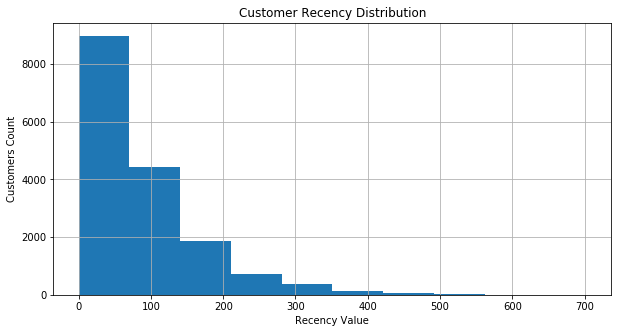

In [80]:
customer_recency.recency.hist(figsize=(10,5));
plt.title('Customer Recency Distribution');
plt.xlabel('Recency Value');
plt.ylabel('Customers Count');

The distribution of the recency of the customers is left skewed meaning that most of the customers seem to have made recent purchases.

After calculting the recency now we need to create the clusters for the recency. So i will use the elbow method to decide the number of clusters needed. then we need to order the clusters based on the recency values.

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

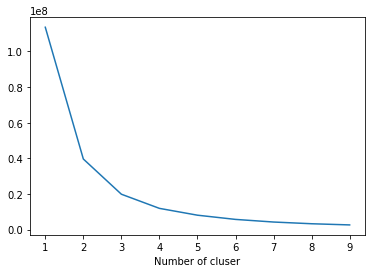

In [101]:
# second step now is to create the cluster of the customer recency
sse = {}
customer_recency_temp = customer_recency[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(customer_recency_temp)
    customer_recency_temp["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # center of kmean cluster
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluser")
plt.show()

In [100]:
clusterd_customer_recency = create_clusters(clusters_num=4, target_field_name='recency', df=customer_recency,ascending=False)
clusterd_customer_recency.head()

customer_id  recency  recency_cluster
0  0009655768c64bdeb2e877511632db8f  18       3              
1  0020c2b971eb4e9188eac86d93036a77  6        3              
2  0020ccbbb6d84e358d3414a3ff76cffd  42       3              
3  003d66b6608740288d6cc97a6903f4f0  18       3              
4  00426fe3ffde4c6b9cb9ad6d077a13ea  18       3

In [83]:
clusterd_customer_recency.groupby('recency_cluster')['recency'].describe()

count        mean        std    min    25%    50%    75%    max
recency_cluster                                                                  
0                693.0   344.199134  72.270051  270.0  294.0  324.0  372.0  702.0
1                2493.0  188.214200  34.685572  144.0  156.0  180.0  216.0  264.0
2                5562.0  92.237325   23.338478  60.0   72.0   90.0   108.0  138.0
3                7830.0  24.956322   17.066089  0.0    12.0   24.0   42.0   54.0

**Observing the descriptive statistics of the created recency clusters we can see that the clusters are ordered with the smaller clusters numbers corresponding to customers with less old mean recency values compared to the cluster 3 that had a mean recency of 25 days.**
#### Frequency
The Frequency attribute corresponds to how often the customer buys(activity of the customer). the higher the value the better. 
I will only need to create a new function that calculates the frequency which only count the number of transactions for the user.

In [84]:
def calculate_frequency(transactions):
    '''
        This method calculates a customer frequency score based on the number of transactions
        Args:
            transaction(pd.DataFrame): dataframe containing the customers transactions
        Returns:
            Frequency dataframe for each customer
    '''
    #get the last transaction 
    tx_frequency = transactions.groupby('customer_id').amount.count().reset_index()
    tx_frequency.columns = ['customer_id','frequency']
    
    return tx_frequency

In [85]:
customer_fq = calculate_frequency(transactions)
customer_fq.head()

customer_id  frequency
0  0009655768c64bdeb2e877511632db8f  8        
1  00116118485d4dfda04fdbaba9a87b5c  3        
2  0011e0d4e6b944f998e987f904e8c1e5  5        
3  0020c2b971eb4e9188eac86d93036a77  8        
4  0020ccbbb6d84e358d3414a3ff76cffd  12

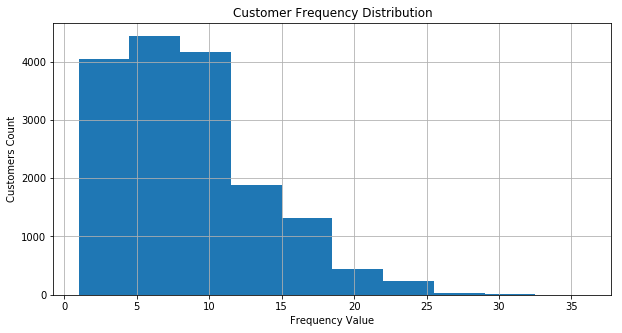

In [86]:
customer_fq.frequency.hist(figsize=(10,5))
plt.title('Customer Frequency Distribution');
plt.xlabel('Frequency Value');
plt.ylabel('Customers Count');

In [87]:
customer_fq.frequency.describe()

count    16578.000000
mean     8.381771    
std      5.009822    
min      1.000000    
25%      5.000000    
50%      7.000000    
75%      11.000000   
max      36.000000   
Name: frequency, dtype: float64

The frequnecy distribution also has left skewed distribution with most customer having small number of transactions.
Next we will create ordered clusters with the highest cluster having the higher frequency and we will 4 clusters.

In [88]:
# create ordered clusters of the customer frequency
clusterd_customer_fq = create_clusters(clusters_num=4, target_field_name='frequency', df=customer_fq,ascending=True)
clusterd_customer_fq.head()

customer_id  frequency  frequency_cluster
0  0009655768c64bdeb2e877511632db8f  8          1                
1  0020c2b971eb4e9188eac86d93036a77  8          1                
2  004b041fbfe44859945daa2c7f79ee64  6          1                
3  0082fd87c18f45f2be70dbcbb0fb8aad  7          1                
4  008d7088107b468893889da0ede0df5c  7          1

In [89]:
clusterd_customer_fq.groupby('frequency_cluster')['frequency'].describe()

count       mean       std   min   25%   50%   75%   max
frequency_cluster                                                           
0                  5623.0  3.545261   1.240562  1.0   3.0   4.0   5.0   5.0 
1                  5150.0  7.354563   1.092584  6.0   6.0   7.0   8.0   9.0 
2                  4159.0  12.008175  1.647635  10.0  11.0  12.0  13.0  15.0
3                  1646.0  18.955043  2.947842  16.0  17.0  18.0  21.0  36.0

**Observing the descriptive statistics of the created frequency clusters we can see that the clusters are ordered with the smaller clusters numbers corresponding to less active customers with a mean frequency of 3 compared to the cluster 3 that had a mean frequency of 18.**

#### Monetary 
The Monetary(Revenue) attribute corresponds to how much the customer buys(purchases of the customer). the higher the value the better. 
I will only need to create a new function that calculates the revenue which only sums the amount of transactions for the user.

In [90]:
def calculate_revenue(transactions):
    '''
        This method calculates a customer revenue score based on the amount of transactions
        Args:
            transaction(pd.DataFrame): dataframe containing the customers transactions
        Returns:
            Revenue dataframe for each customer
    '''
    #get the last transaction 
    tx_revenue = transactions.groupby('customer_id').amount.sum().reset_index()
    tx_revenue.columns = ['customer_id','revenue']
    
    return tx_revenue

In [91]:
customer_revenue = calculate_revenue(transactions)
customer_revenue.head()

customer_id  revenue
0  0009655768c64bdeb2e877511632db8f  127.60 
1  00116118485d4dfda04fdbaba9a87b5c  4.09   
2  0011e0d4e6b944f998e987f904e8c1e5  79.46  
3  0020c2b971eb4e9188eac86d93036a77  196.86 
4  0020ccbbb6d84e358d3414a3ff76cffd  154.05

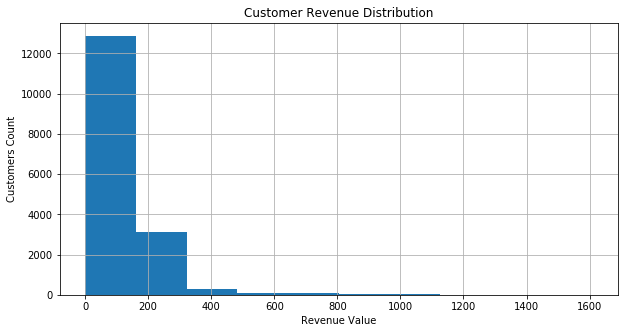

In [92]:
customer_revenue.revenue.hist(figsize=(10,5))
plt.title('Customer Revenue Distribution');
plt.xlabel('Revenue Value');
plt.ylabel('Customers Count');

In [93]:
customer_revenue.revenue.describe()

count    16578.000000
mean     107.096874  
std      126.393939  
min      0.050000    
25%      23.682500   
50%      72.410000   
75%      150.937500  
max      1608.690000 
Name: revenue, dtype: float64

The customer revenue is a left skewed distribution. 

In [94]:
# create ordered clusters of the customer frequency
clusterd_customer_revenue = create_clusters(clusters_num=4, target_field_name='revenue', df=customer_revenue,ascending=True)
clusterd_customer_revenue.head()

customer_id  revenue  revenue_cluster
0  0009655768c64bdeb2e877511632db8f  127.60   1              
1  0020c2b971eb4e9188eac86d93036a77  196.86   1              
2  0020ccbbb6d84e358d3414a3ff76cffd  154.05   1              
3  004b041fbfe44859945daa2c7f79ee64  138.36   1              
4  0056df74b63b4298809f0b375a304cf4  144.14   1

In [95]:
clusterd_customer_revenue.groupby('revenue_cluster')['revenue'].describe()

count        mean         std     min     25%     50%      75%      max
revenue_cluster                                                                          
0                9252.0  34.130976   24.192898   0.05    14.29   26.95   51.990   89.02  
1                5409.0  144.253261  35.121188   89.07   113.95  141.02  172.330  215.94 
2                1687.0  287.872839  69.943301   216.17  237.76  266.11  313.245  563.13 
3                230.0   842.455696  189.939498  567.97  683.24  810.88  976.710  1608.69

**Observing the descriptive statistics of the created revenue clusters we can see that the clusters are ordered with the smaller clusters numbers corresponding to customers who spend less with a mean revenue of 34 compared to the cluster 3 that had a mean frequency of 842.**

### Combine RFM segments

Next I will combine the dataframes from the previous steps, sum all the clusters to create the customer overall score, finally create the customer segments of low,mid and high value customers.

In [102]:
# merge the dataframes 
combined_rfm = pd.merge(clusterd_customer_revenue, clusterd_customer_recency, on='customer_id')
combined_rfm.head()

customer_id  revenue  revenue_cluster  recency  recency_cluster
0  0009655768c64bdeb2e877511632db8f  127.60   1                18       3              
1  0020c2b971eb4e9188eac86d93036a77  196.86   1                6        3              
2  0020ccbbb6d84e358d3414a3ff76cffd  154.05   1                42       3              
3  004b041fbfe44859945daa2c7f79ee64  138.36   1                0        3              
4  0056df74b63b4298809f0b375a304cf4  144.14   1                42       3

In [103]:
combined_rfm = pd.merge(combined_rfm, clusterd_customer_fq, on='customer_id')
combined_rfm.head()

customer_id  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster
0  0009655768c64bdeb2e877511632db8f  127.60   1                18       3                8          1                
1  0020c2b971eb4e9188eac86d93036a77  196.86   1                6        3                8          1                
2  0020ccbbb6d84e358d3414a3ff76cffd  154.05   1                42       3                12         2                
3  004b041fbfe44859945daa2c7f79ee64  138.36   1                0        3                6          1                
4  0056df74b63b4298809f0b375a304cf4  144.14   1                42       3                5          0

In [104]:
# overall score 
combined_rfm['overall_score'] = combined_rfm['recency_cluster'] + combined_rfm['frequency_cluster']+combined_rfm['revenue_cluster']
combined_rfm.head()

customer_id  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score
0  0009655768c64bdeb2e877511632db8f  127.60   1                18       3                8          1                  5            
1  0020c2b971eb4e9188eac86d93036a77  196.86   1                6        3                8          1                  5            
2  0020ccbbb6d84e358d3414a3ff76cffd  154.05   1                42       3                12         2                  6            
3  004b041fbfe44859945daa2c7f79ee64  138.36   1                0        3                6          1                  5            
4  0056df74b63b4298809f0b375a304cf4  144.14   1                42       3                5          0                  4

In [105]:
combined_rfm.groupby('overall_score')['recency','frequency','revenue'].mean()

recency  frequency     revenue
overall_score                                   
0              347.228426  2.532995   30.298782 
1              196.069900  3.356633   34.801277 
2              124.146718  4.375000   41.993031 
3              77.476779   5.503842   55.921931 
4              62.766529   7.909091   86.245899 
5              46.245226   10.455946  122.273092
6              38.447653   14.053249  169.702947
7              30.872195   14.635122  287.833493
8              25.362162   17.559459  412.101405
9              20.700000   19.650000  767.912500

In [106]:
combined_rfm.describe()

revenue  revenue_cluster       recency  recency_cluster     frequency  frequency_cluster  overall_score
count  16578.000000  16578.000000     16578.000000  16578.000000     16578.000000  16578.000000       16578.000000 
mean   107.096874    0.571420         85.425262     2.219689         8.381771      1.110267           3.901375     
std    126.393939    0.729175         82.766010     0.875969         5.009822      0.987478           1.913364     
min    0.050000      0.000000         0.000000      0.000000         1.000000      0.000000           0.000000     
25%    23.682500     0.000000         24.000000     2.000000         5.000000      0.000000           3.000000     
50%    72.410000     0.000000         60.000000     2.000000         7.000000      1.000000           4.000000     
75%    150.937500    1.000000         120.000000    3.000000         11.000000     2.000000           5.000000     
max    1608.690000   3.000000         702.000000    3.000000         36.000000     3.000000           9.000000

In [107]:
combined_rfm.groupby('overall_score')['recency','frequency','revenue'].count()

recency  frequency  revenue
overall_score                             
0              591      591        591    
1              1402     1402       1402   
2              2072     2072       2072   
3              2993     2993       2993   
4              2904     2904       2904   
5              2985     2985       2985   
6              2216     2216       2216   
7              1025     1025       1025   
8              370      370        370    
9              20       20         20

Observing the overall score we can see that customer had a lower overall_score: had older purchases, least frequent purchases and smallest revenue compared to the customers with a score of 9. 

In [108]:
# create segments 
combined_rfm['RFM_segement'] = pd.qcut(combined_rfm['overall_score'], 3, labels=['Low-Value','Mid-Value', 'High-Value' ])
combined_rfm.head()

customer_id  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score RFM_segement
0  0009655768c64bdeb2e877511632db8f  127.60   1                18       3                8          1                  5              Mid-Value  
1  0020c2b971eb4e9188eac86d93036a77  196.86   1                6        3                8          1                  5              Mid-Value  
2  0020ccbbb6d84e358d3414a3ff76cffd  154.05   1                42       3                12         2                  6              High-Value 
3  004b041fbfe44859945daa2c7f79ee64  138.36   1                0        3                6          1                  5              Mid-Value  
4  0056df74b63b4298809f0b375a304cf4  144.14   1                42       3                5          0                  4              Mid-Value

In [109]:
#revenue vs frequency
tx_graph = combined_rfm.query("revenue < 50000 and frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("RFM_segement == 'Low-Value'")['frequency'],
        y=tx_graph.query("RFM_segement == 'Low-Value'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("RFM_segement == 'Mid-Value'")['frequency'],
        y=tx_graph.query("RFM_segement == 'Mid-Value'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("RFM_segement == 'High-Value'")['frequency'],
        y=tx_graph.query("RFM_segement == 'High-Value'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "revenue"},
        xaxis= {'title': "frequency"},
        title='segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#revenue recency

tx_graph = combined_rfm.query("revenue < 50000 and frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("RFM_segement == 'Low-Value'")['recency'],
        y=tx_graph.query("RFM_segement == 'Low-Value'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("RFM_segement == 'Mid-Value'")['recency'],
        y=tx_graph.query("RFM_segement == 'Mid-Value'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("RFM_segement == 'High-Value'")['recency'],
        y=tx_graph.query("RFM_segement == 'High-Value'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "revenue"},
        xaxis= {'title': "recency"},
        title='segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# revenue vs frequency
tx_graph = combined_rfm.query("revenue < 50000 and frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("RFM_segement == 'Low-Value'")['recency'],
        y=tx_graph.query("RFM_segement == 'Low-Value'")['frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("RFM_segement == 'Mid-Value'")['recency'],
        y=tx_graph.query("RFM_segement == 'Mid-Value'")['frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("RFM_segement == 'High-Value'")['recency'],
        y=tx_graph.query("RFM_segement == 'High-Value'")['frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "frequency"},
        xaxis= {'title': "recency"},
        title='segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [110]:
combined_rfm.head()

customer_id  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score RFM_segement
0  0009655768c64bdeb2e877511632db8f  127.60   1                18       3                8          1                  5              Mid-Value  
1  0020c2b971eb4e9188eac86d93036a77  196.86   1                6        3                8          1                  5              Mid-Value  
2  0020ccbbb6d84e358d3414a3ff76cffd  154.05   1                42       3                12         2                  6              High-Value 
3  004b041fbfe44859945daa2c7f79ee64  138.36   1                0        3                6          1                  5              Mid-Value  
4  0056df74b63b4298809f0b375a304cf4  144.14   1                42       3                5          0                  4              Mid-Value

In [111]:
combined_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16578 entries, 0 to 16577
Data columns (total 9 columns):
customer_id          16578 non-null object
revenue              16578 non-null float64
revenue_cluster      16578 non-null int64
recency              16578 non-null int64
recency_cluster      16578 non-null int64
frequency            16578 non-null int64
frequency_cluster    16578 non-null int64
overall_score        16578 non-null int64
RFM_segement         16578 non-null category
dtypes: category(1), float64(1), int64(6), object(1)
memory usage: 1.2+ MB


In [112]:
combined_rfm.isnull().sum()

customer_id          0
revenue              0
revenue_cluster      0
recency              0
recency_cluster      0
frequency            0
frequency_cluster    0
overall_score        0
RFM_segement         0
dtype: int64

In [113]:
# final transaction dataframe 
final_transactions_df = pd.merge(customers_transactions_df, combined_rfm, on='customer_id', how='inner')
final_transactions_df.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score RFM_segement
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value  
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value  
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0     NaN         1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value  
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0     NaN         1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value  
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0     NaN         1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value

In [114]:
final_transactions_df.isnull().sum()

customer_id                    0    
time_received                  0    
offer_id                       0    
difficulty                     0    
duration                       0    
offer_type                     0    
reward                         0    
mobile                         0    
web                            0    
social                         0    
email                          0    
expected_finish                0    
completed                      0    
finish                         0    
viewed                         0    
success                        0    
view_time                      23192
completed_not_viewed           0    
total_spent_offer              0    
total_spent_non_offer          0    
profit                         0    
total_spent                    0    
num_bogo_completed             0    
num_discount_completed         0    
num_informational_completed    0    
successful_offers              0    
non_successful_offers          0    
c

In [115]:
final_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74396 entries, 0 to 74395
Data columns (total 37 columns):
customer_id                    74396 non-null object
time_received                  74396 non-null int64
offer_id                       74396 non-null object
difficulty                     74396 non-null float64
duration                       74396 non-null float64
offer_type                     74396 non-null object
reward                         74396 non-null float64
mobile                         74396 non-null float64
web                            74396 non-null float64
social                         74396 non-null float64
email                          74396 non-null float64
expected_finish                74396 non-null float64
completed                      74396 non-null float64
finish                         74396 non-null float64
viewed                         74396 non-null float64
success                        74396 non-null float64
view_time                      5

In [116]:
final_transactions_df.to_csv('analyzed_transactions_offers_RFM.csv', index = None, header=True)

In [28]:
#final_transactions_df = pd.read_csv('analyzed_transactions_offers_RFM.csv')

In [29]:
#final_transactions_df.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score RFM_segement
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          1           2.0                3                      TR      127.6    1                18       3                8          1                  5              Mid-Value  
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          1           2.0                3                      TR      127.6    1                18       3                8          1                  5              Mid-Value  
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0    1.0  1.0     1.0     528.0            1.0        414.0   0.0     0.0     NaN         1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          1           2.0                3                      CR      127.6    1                18       3                8          1                  5              Mid-Value  
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0    1.0  1.0     1.0     744.0            1.0        528.0   0.0     0.0     NaN         1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          1           2.0                3                      CR      127.6    1                18       3                8          1                  5              Mid-Value  
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0    1.0  1.0     0.0     744.0            1.0        576.0   0.0     0.0     NaN         1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          1           2.0                3                      CR      127.6    1                18       3                8          1                  5              Mid-Value

### Handle missing values for age, gender and income 
- Handle missing values for age, gender and income.
- I found a helper function on stackoverflow and used it to replace the missing values. (ref)[https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn] 
- fill view_time with 0 instead of nan

In [117]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [118]:
missing_values_cols = ['gender','income','age']
profile_subset_imputed = DataFrameImputer().fit_transform(profile[missing_values_cols])

cleaned_profile = profile.copy()
cleaned_profile[missing_values_cols] = profile_subset_imputed
cleaned_profile.head()

age became_member_on gender                       customer_id         income  membership_year  membership_month  membership_day
0  54.393524 2017-02-12        M      68be06ca386d4c31939f3a4f0e3dd783  65404.991568   2017             2                 12            
1  55.000000 2017-07-15        F      0610b486422d4921ae7d2bf64640c50b  112000.000000  2017             7                 15            
2  54.393524 2018-07-12        M      38fe809add3b4fcf9315a9694bb96ff5  65404.991568   2018             7                 12            
3  75.000000 2017-05-09        F      78afa995795e4d85b5d9ceeca43f5fef  100000.000000  2017             5                 9             
4  54.393524 2017-08-04        M      a03223e636434f42ac4c3df47e8bac43  65404.991568   2017             8                 4

In [119]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
age                 17000 non-null float64
became_member_on    17000 non-null datetime64[ns]
gender              17000 non-null object
customer_id         17000 non-null object
income              17000 non-null float64
membership_year     17000 non-null int64
membership_month    17000 non-null int64
membership_day      17000 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.0+ MB


In [120]:
cleaned_profile.describe()

age         income  membership_year  membership_month  membership_day
count  17000.000000  17000.000000   17000.000000     17000.000000      17000.000000  
mean   54.393524     65404.991568   2016.635000      6.683529          15.881176     
std    16.233545     20169.288288   1.177624         3.487098          8.775390      
min    18.000000     30000.000000   2013.000000      1.000000          1.000000      
25%    45.000000     51000.000000   2016.000000      4.000000          8.000000      
50%    54.393524     65404.991568   2017.000000      7.000000          16.000000     
75%    65.000000     76000.000000   2017.000000      10.000000         23.000000     
max    101.000000    120000.000000  2018.000000      12.000000         31.000000

In [121]:
# combine the cleaned profile with the final transactions data frame
offers_tx_profile_merged = final_transactions_df.merge(cleaned_profile,on='customer_id', how='left')
offers_tx_profile_merged.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score RFM_segement   age became_member_on gender   income  membership_year  membership_month  membership_day
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0     NaN         1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0     NaN         1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0     NaN         1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21

In [122]:
offers_tx_profile_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74396 entries, 0 to 74395
Data columns (total 44 columns):
customer_id                    74396 non-null object
time_received                  74396 non-null int64
offer_id                       74396 non-null object
difficulty                     74396 non-null float64
duration                       74396 non-null float64
offer_type                     74396 non-null object
reward                         74396 non-null float64
mobile                         74396 non-null float64
web                            74396 non-null float64
social                         74396 non-null float64
email                          74396 non-null float64
expected_finish                74396 non-null float64
completed                      74396 non-null float64
finish                         74396 non-null float64
viewed                         74396 non-null float64
success                        74396 non-null float64
view_time                      5

In [123]:
offers_tx_profile_merged.isnull().sum()

customer_id                    0    
time_received                  0    
offer_id                       0    
difficulty                     0    
duration                       0    
offer_type                     0    
reward                         0    
mobile                         0    
web                            0    
social                         0    
email                          0    
expected_finish                0    
completed                      0    
finish                         0    
viewed                         0    
success                        0    
view_time                      23192
completed_not_viewed           0    
total_spent_offer              0    
total_spent_non_offer          0    
profit                         0    
total_spent                    0    
num_bogo_completed             0    
num_discount_completed         0    
num_informational_completed    0    
successful_offers              0    
non_successful_offers          0    
c

In [124]:
# fill nan with 0 for viewtime column
offers_tx_profile_merged['view_time'].fillna(0, inplace=True)
offers_tx_profile_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74396 entries, 0 to 74395
Data columns (total 44 columns):
customer_id                    74396 non-null object
time_received                  74396 non-null int64
offer_id                       74396 non-null object
difficulty                     74396 non-null float64
duration                       74396 non-null float64
offer_type                     74396 non-null object
reward                         74396 non-null float64
mobile                         74396 non-null float64
web                            74396 non-null float64
social                         74396 non-null float64
email                          74396 non-null float64
expected_finish                74396 non-null float64
completed                      74396 non-null float64
finish                         74396 non-null float64
viewed                         74396 non-null float64
success                        74396 non-null float64
view_time                      7

Now we can see that the missing values have been replaced with the most frequent value for the gender while the mean was used for the numeric variables another option was to create a simple model to predict the missing values based on the user profile

In [125]:
offers_tx_profile_merged.to_csv('analyzed_tx_offers_RFM_profile.csv', index = None, header=True)

### Handle Categorical Variables

In this part all the categorical variables need to be transformed using label encoding and pandas get dummies.
The columns that will be transformed are: 

    1) The segment we can label encode each segment 

    2) encode the RFM segment 

    3) Gender 
    

In [126]:
offers_tx_profile_merged.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score RFM_segement   age became_member_on gender   income  membership_year  membership_month  membership_day
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0      0.0        1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0      0.0        1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0      0.0        1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21

In [127]:
categorical_columns_to_handle = ['gender', 'RFM_segement']
offers_tx_profile_merged_categorical = pd.get_dummies(data= offers_tx_profile_merged,columns=categorical_columns_to_handle)
offers_tx_profile_merged_categorical.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0      0.0        1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0      0.0        1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0      0.0        1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                      1

In [128]:
offers_tx_profile_merged_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74396 entries, 0 to 74395
Data columns (total 47 columns):
customer_id                    74396 non-null object
time_received                  74396 non-null int64
offer_id                       74396 non-null object
difficulty                     74396 non-null float64
duration                       74396 non-null float64
offer_type                     74396 non-null object
reward                         74396 non-null float64
mobile                         74396 non-null float64
web                            74396 non-null float64
social                         74396 non-null float64
email                          74396 non-null float64
expected_finish                74396 non-null float64
completed                      74396 non-null float64
finish                         74396 non-null float64
viewed                         74396 non-null float64
success                        74396 non-null float64
view_time                      7

In [129]:
# map the segment as follows: TR --> 0, CR --> 1, TN -->3, CN-->3
segment_dict = {'TR':0, 'CR':1, 'TN':2, 'CN':3}
offers_tx_profile_merged_categorical.segment.replace(segment_dict, inplace=True)
offers_tx_profile_merged_categorical.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                0        127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                0        127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0      0.0        1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                1        127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0      0.0        1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                1        127.6    1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0      0.0        1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                  

In [130]:
offers_tx_profile_merged_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74396 entries, 0 to 74395
Data columns (total 47 columns):
customer_id                    74396 non-null object
time_received                  74396 non-null int64
offer_id                       74396 non-null object
difficulty                     74396 non-null float64
duration                       74396 non-null float64
offer_type                     74396 non-null object
reward                         74396 non-null float64
mobile                         74396 non-null float64
web                            74396 non-null float64
social                         74396 non-null float64
email                          74396 non-null float64
expected_finish                74396 non-null float64
completed                      74396 non-null float64
finish                         74396 non-null float64
viewed                         74396 non-null float64
success                        74396 non-null float64
view_time                      7

### Extra EDA 

Before splitting the dataframe based on offer_id. i will do further EDA analysis to answers few questions and understand some of the existent relations in the data.

**Univarite Exploration**
- RFM segment distributions
- Customer groups (TR, TN, CR, CN)

**Bivariate Exploration**

- The attributes of people in high, mid or low RFM cluster such as:
    - Age groups 
    - Income groups
    - Joining month and year
    - Gender
    
- The purchasing behavior in high, mid or low RFM cluster terms such as:
    - Total Spent
    - Profit
    - Number of completed offers
    - Segment (TR, TN, CR, CN)
    
**Multivariate Exploration**

- Total_spent vs RFM vs Customer Group
- Age vs RFM vs Customer Group
- Gender vs RFM vs Customer Group
- Income vs RFM vs Customer Group

will use the resulting data from combining the RFM and cleaned offers 

In [204]:
exploration_df = final_transactions_df.merge(cleaned_profile,on='customer_id', how='left')
exploration_df.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  mobile  web  social  email  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  successful_offers  non_successful_offers  completed_offer segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score RFM_segement   age became_member_on gender   income  membership_year  membership_month  membership_day
0  0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0     0.0  1.0     1.0    240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.00                   22.16   22.16        1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
1  0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0     1.0  0.0     1.0    432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          2.0                3                      1                TR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
2  0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo           5.0     1.0     1.0  1.0     1.0    528.0            1.0        414.0   0.0     0.0     NaN         1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
3  0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount       2.0     1.0     1.0  1.0     1.0    744.0            1.0        528.0   0.0     0.0     NaN         1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21            
4  0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount       2.0     1.0     1.0  0.0     1.0    744.0            1.0        576.0   0.0     0.0     NaN         1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          2.0                3                      1                CR      127.6    1                18       3                8          1                  5              Mid-Value    33.0 2017-04-21        M      72000.0  2017             4                 21

In [132]:
exploration_df.RFM_segement.value_counts()

Low-Value     30669
Mid-Value     26391
High-Value    17336
Name: RFM_segement, dtype: int64

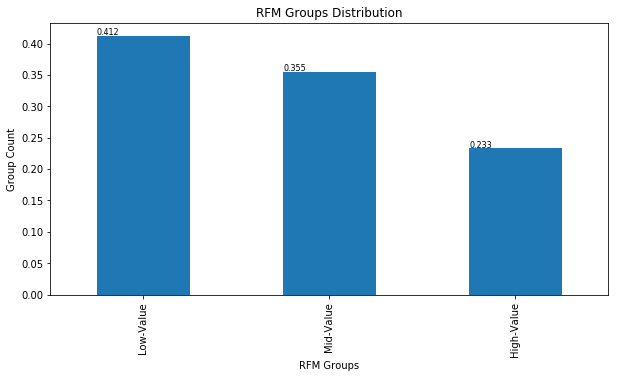

In [146]:
#RFM segment Distribution 
plot_bar_with_annoation(data=exploration_df.RFM_segement.value_counts()/exploration_df.RFM_segement.value_counts().sum(), title='RFM Groups Distribution',xlabel='RFM Groups', ylabel='Group Count')

So from the distribution we see that the customers are mostly in the Low value RFM group(low frequency, low revenue and the least recent interactions) with 41% though this percentage is close to the Mid value RFM group while the High RFM group had 23%.

In [147]:
exploration_df.segment.value_counts()

TR    29249
TN    20799
CN    13238
CR    11110
Name: segment, dtype: int64

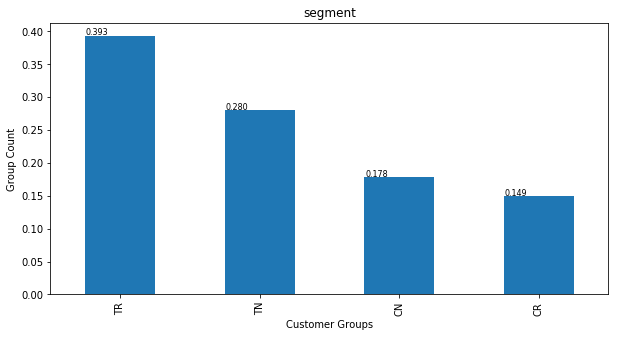

In [148]:
plot_bar_with_annoation(data=exploration_df.segment.value_counts()/exploration_df.segment.value_counts().sum(), title='segment',xlabel='Customer Groups', ylabel='Group Count')

**Summary**
- 40% of the customers are in the Treatment response group 
- CR had 14.9% of the customers

**Bivariate Exploration**

- The demographics of RFM segments such as:
    - Age groups 
    - Income groups
    - Gender   

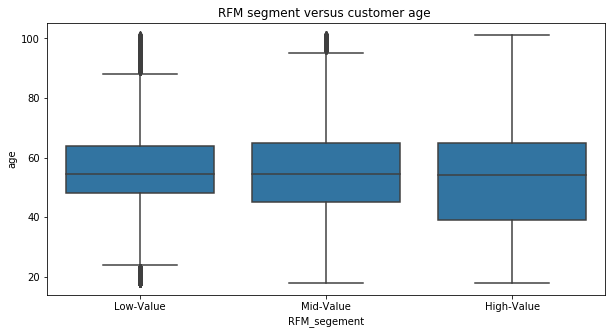

In [174]:
plt.figure(figsize = [10, 5])
base_color = sns.color_palette()[0]
sns.boxplot(data = exploration_df, y = 'age', x = 'RFM_segement', color = base_color);
plt.title('RFM segment versus customer age ');
exploration_df.groupby('RFM_segement');

In [176]:
exploration_df.groupby('RFM_segement')['age'].describe()

count       mean        std   min   25%        50%   75%    max
RFM_segement                                                                   
Low-Value     30669.0  55.054469  15.549562  18.0  48.0  54.393524  64.0  101.0
Mid-Value     26391.0  54.473243  16.230015  18.0  45.0  54.393524  65.0  101.0
High-Value    17336.0  52.666811  17.589208  18.0  39.0  54.000000  65.0  101.0

The age is not a factor in the RFM segmenet it seems. though the RFM segment with low value seem to contain the smallest age group from 48 - 64 (quratile range)

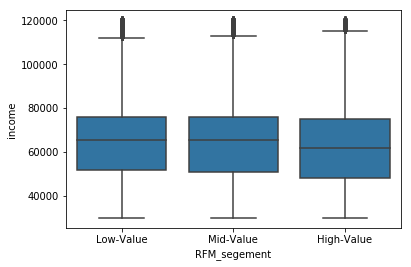

In [152]:
# income vs RFM
sns.boxplot(data = exploration_df, y = 'income', x = 'RFM_segement', color = base_color);

In [177]:
exploration_df.groupby('RFM_segement')['income'].describe()

count          mean           std      min      25%           50%      75%       max
RFM_segement                                                                                        
Low-Value     30669.0  65776.158793  19774.698217  30000.0  52000.0  65404.991568  76000.0  120000.0
Mid-Value     26391.0  65444.765649  20278.841596  30000.0  51000.0  65404.991568  76000.0  120000.0
High-Value    17336.0  63843.641939  20826.325773  30000.0  48000.0  62000.000000  75000.0  120000.0

The income of the different groups is very similar across the different groups.

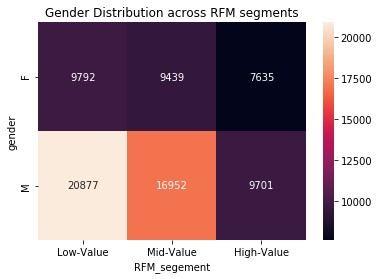

In [172]:
# Gender Count
ct_counts = exploration_df.groupby(['RFM_segement', 'gender']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'gender', columns = 'RFM_segement', values = 'count')
sns.heatmap(ct_counts, annot = True, fmt = 'd');
plt.title('Gender Distribution across RFM segments');

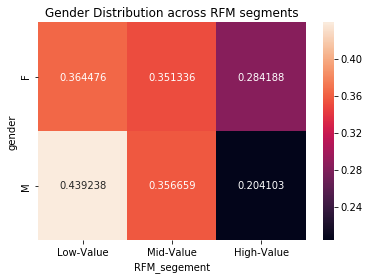

In [179]:
# RFM group Gender 
ct_counts = exploration_df.groupby(['RFM_segement', 'gender']).size()/exploration_df.groupby(['gender']).size()
ct_counts = ct_counts.reset_index(name = 'percentage')
ct_counts = ct_counts.pivot(index = 'gender', columns = 'RFM_segement', values = 'percentage')
sns.heatmap(ct_counts, annot = True, fmt = 'g');
plt.title('Gender Distribution across RFM segments');

Since this dataset contain more males than females i normalize the counts by the gender to compare the RFM segment distribution. the Males are in the low value RFM and mid-value RFM with the females having a higher percentage in high value. 

- The purchasing behavior in RFM clusters:
    - Total Spent
    - Profit
    - Number of completed offers
    - Segment (TR, TN, CR, CN)

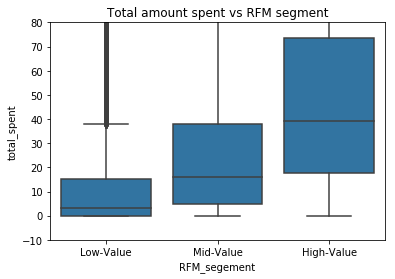

In [190]:
# total spent vs RFM segment
sns.boxplot(data = exploration_df, y = 'total_spent', x = 'RFM_segement', color = base_color);
plt.title('Total amount spent vs RFM segment');
plt.ylim((-10,80));

In [186]:
exploration_df.groupby('RFM_segement')['total_spent'].describe()

count       mean        std  min      25%    50%    75%      max
RFM_segement                                                                    
Low-Value     30669.0  11.190205  19.555984  0.0  0.0000   3.22   15.22  573.81 
Mid-Value     26391.0  26.781895  40.184951  0.0  4.9900   15.90  37.86  1074.78
High-Value    17336.0  59.827518  91.942656  0.0  17.8725  39.33  73.58  1200.99

As expected the high value RFM have the highest amount spent by observing the upper and lower limit. The Q3 for the low value segment is around 15 dollar compared to 37 in the mid value while the high RFM cluster had 74 dollar spent.

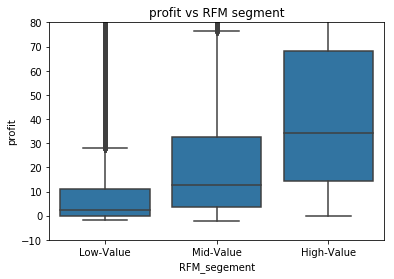

In [191]:
sns.boxplot(data = exploration_df, y = 'profit', x = 'RFM_segement', color = base_color);
plt.title('profit vs RFM segment');
plt.ylim((-10,80));

In [192]:
exploration_df.groupby('RFM_segement')['profit'].describe()

count       mean        std   min      25%    50%    75%      max
RFM_segement                                                                     
Low-Value     30669.0  9.520463   18.220402 -1.85  0.0000   2.46   11.25  571.81 
Mid-Value     26391.0  23.781743  39.245773 -2.05  3.7350   12.53  32.76  1072.78
High-Value    17336.0  55.513608  91.298193  0.00  14.4175  34.15  68.12  1198.99

The Low and Mid value groups contain negative profit and the groups have distinct groups ranges.

In [210]:
# Customer segments vs RFM clusters 
exploration_df.groupby(['RFM_segement', 'segment']).size() /exploration_df.groupby(['RFM_segement']).size()

RFM_segement  segment
Low-Value     CN         0.242134
              CR         0.100525
              TN         0.421761
              TR         0.235580
Mid-Value     CN         0.164791
              CR         0.162025
              TN         0.232428
              TR         0.440756
High-Value    CN         0.084391
              CR         0.216371
              TN         0.099792
              TR         0.599446
dtype: float64

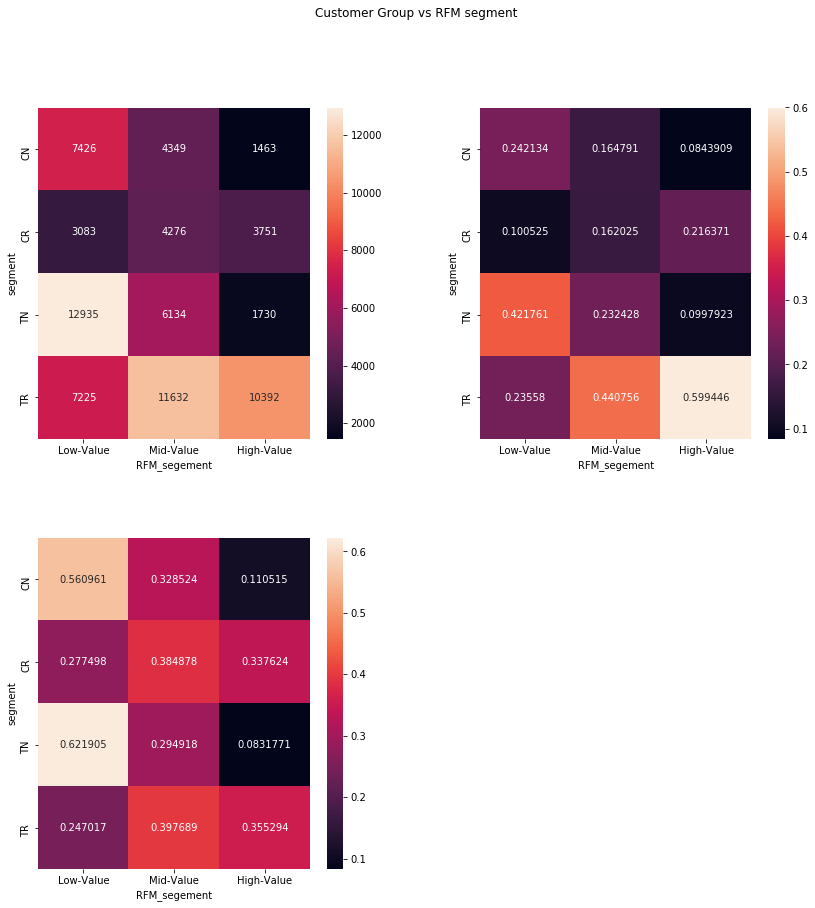

In [228]:
#  Segment (TR, TN, CR, CN) vs RFM
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=.3, wspace = 0.3)

plt.subplot(2, 2, 1)
ct_counts = exploration_df.groupby(['RFM_segement', 'segment']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'segment', columns = 'RFM_segement', values = 'count')
sns.heatmap(ct_counts, annot = True, fmt = 'g');

plt.subplot(2, 2, 2)
ct_counts = exploration_df.groupby(['RFM_segement', 'segment']).size()/exploration_df.groupby([ 'RFM_segement']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'segment', columns = 'RFM_segement', values = 'count')
sns.heatmap(ct_counts, annot = True, fmt = 'g');

plt.subplot(2, 2, 3)
ct_counts = exploration_df.groupby(['RFM_segement', 'segment']).size()/exploration_df.groupby([ 'segment']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'segment', columns = 'RFM_segement', values = 'count')
sns.heatmap(ct_counts, annot = True, fmt = 'g');

fig.suptitle('Customer Group vs RFM segment');


In terms of the segments the RFM clusters are distributed as follows:

    - CN comprise of 56% of the Low value RFM clusters segments, followed by Mid value RFM clusters.
    - CR mostly in the Mid Value segment with 38.5% followed by 33.7% in the high value RFM cluster.
    - TN comprise of 62% low value RFM clusters. and below 10% from the high value RFM cluster.
    - TR: highest portion comes from the mid value RFM cluster with 40% followed by high value with 35.6%

Compring with respect to the RFM cluster:

    -  Low value have 42% in the TN segment and similar percentages for CN and TR.
    - Mid Value RFM cluster comprise of 40% for the TR segment which is double the other RFM clusters.
    - High Value comprise of 60% of TR then 44% of Mid value Customers.

The above figures makes sense since The high value customers are the ones who are most frequnt, spent the most and had the most recent interactions. This indicates that high and mid value customers are responsive to targeted marketing while it did not make difference in the Low values. 

Next, I will compared the number of compelted offers across different segments.

In [208]:
exploration_df['num_completed_offers'] = exploration_df['num_informational_completed'] + exploration_df['num_discount_completed'] + exploration_df['num_bogo_completed'] 

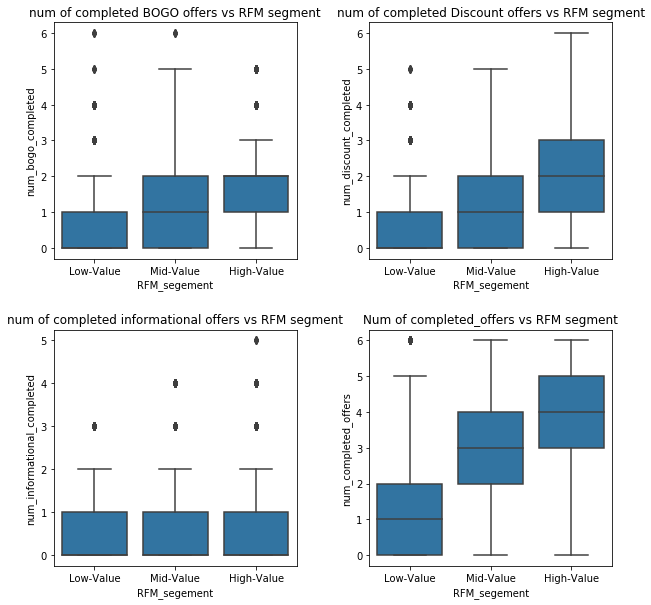

In [219]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=.3, wspace = 0.3)

plt.subplot(2, 2, 1)
sns.boxplot(data = exploration_df, y = 'num_bogo_completed', x = 'RFM_segement', color = base_color);
plt.title('num of completed BOGO offers vs RFM segment');

plt.subplot(2, 2, 2)
sns.boxplot(data = exploration_df, y = 'num_discount_completed', x = 'RFM_segement', color = base_color);
plt.title('num of completed Discount offers vs RFM segment');

plt.subplot(2, 2, 3)
sns.boxplot(data = exploration_df, y = 'num_informational_completed', x = 'RFM_segement', color = base_color);
plt.title('num of completed informational offers vs RFM segment');


plt.subplot(2, 2, 4)
sns.boxplot(data = exploration_df, y = 'num_completed_offers', x = 'RFM_segement', color = base_color);
plt.title('Num of completed_offers vs RFM segment');

fig.suptitle('Number of completed offers vs RFM segment');


As expected the number of completed offers for the High value Cluster is the highest compared followed by mid value and RFM clusters.

**Multivariate Exploration**

- Total_spent vs RFM vs Customer Group
- Age vs RFM vs Customer Group
- Gender vs RFM vs Customer Group
- Income vs RFM vs Customer Group

### Split Different DataFrames based on offer_id
we have 10 offer types and we will create for each offer_type a seperate dataframe.

    1) B3_10_7_10 as part BOGO: sent to 3 channels (email, mobile, social), difficulty 10, duration 7 days and a reward of 10

    2) B4_10_5_10:

    3) B3_5_7_5

    4) B4_5_5_5: 

    5) D2_20_10_5

    6) D4_7_7_3

    7) D4_10_10_2

    8) D3_10_7_2

    9) I3_0_4_0

    10) I3_0_3_0

In [856]:
B3_10_7_10_df = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='ae264e3637204a6fb9bb56bc8210ddfd']
B3_10_7_10_df.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
13  0020c2b971eb4e9188eac86d93036a77  168            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     336.0            0.0        336.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 2.0                     0.0                          0           2.0                3                      3        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
35  004c5799adbf42868b9cff0396190900  336            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     504.0            1.0        336.0   0.0     0.0      0.0        1                     0.00               107.07                 97.07   107.07       3.0                 2.0                     0.0                          1           3.0                2                      1        347.38   2                24       3                12         2                  7              54.0 2016-03-31        99000.0  2016             3                 31              0         1         0                       0                       1                      
39  005500a7188546ff8a767329a2f7c76a  0              ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     168.0            0.0        168.0   1.0     0.0      60.0       0                     0.00               0.00                   0.00    0.00         1.0                 0.0                     0.0                          0           0.0                5                      2        20.36    0                126      2                4          0                  2              56.0 2017-12-09        47000.0  2017             12                9               0         1         1                       0                       0                      
40  005500a7188546ff8a767329a2f7c76a  168            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     336.0            0.0        336.0   1.0     0.0      186.0      0                     9.71               0.00                   9.71    9.71         1.0                 0.0                     0.0                          1           0.0                5                      2        20.36    0                126      2                4          0                  2              56.0 2017-12-09        47000.0  2017             12                9               0         1         1                       0                       0                      
43  005500a7188546ff8a767329a2f7c76a  576            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     744.0            0.0        744.0   1.0     0.0      576.0      0                     10.65              0.00                   10.65   10.65        1.0                 0.0                     0.0                          1           0.0                5                      2        20.36    0         

In [857]:
B4_10_5_10 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='4d5c57ea9a6940dd891ad53e9dbe8da0']
B4_10_5_10.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on    income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
15  0020c2b971eb4e9188eac86d93036a77  408            4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     528.0            1.0        510.0   1.0     1.0      426.0      0                     17.24              0.00                   7.24    17.24        1.0                 2.0                     0.0                          1           2.0                3                      0        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0   2016             3                 4               1         0         0                       1                       0                      
59  00715b6e55c3431cb56ff7307eb19675  336            4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     456.0            1.0        342.0   0.0     0.0      0.0        1                     0.00               60.55                  50.55   60.55        2.0                 3.0                     0.0                          1           0.0                6                      1        375.12   2                12       3                15         2                  7              58.0 2017-12-07        119000.0  2017             12                7               1         0         0                       0                       1                      
74  00857b24b13f4fe0ad17b605f00357f5  0              4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     120.0            0.0        120.0   1.0     0.0      0.0        0                     1.61               0.00                   1.61    1.61         0.0                 0.0                     0.0                          1           0.0                5                      2        6.26     0                90       2                4          0                  2              71.0 2017-10-23        41000.0   2017             10                23              0         1         1                       0                       0                      
83  008d7088107b468893889da0ede0df5c  504            4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     624.0            0.0        624.0   1.0     0.0      558.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                6                      2        16.18    0                264      0                7          1                  1              24.0 2017-09-10        42000.0   2017             9                 10              0         1         1                       0                       0                      
85  0091d2b6a5ea4defaa8393e4e816db60  0              4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     120.0            1.0        6.0     1.0     1.0      6.0        0                     46.00              0.00                   36.00   46.00        3.0                 1.0                     0.0                          1           4.0                1                      0        279.16   2    

In [858]:
B3_5_7_5 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='9b98b8c7a33c4b65b9aebfe6a799e6d9']
B3_5_7_5.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
11  0011e0d4e6b944f998e987f904e8c1e5  504            9b98b8c7a33c4b65b9aebfe6a799e6d9  5.0         7.0       bogo       5.0     1.0    1.0  1.0     0.0     672.0            1.0        576.0   1.0     1.0      516.0      0                     54.04              0.00                   49.04   54.04        1.0                 2.0                     0.0                          1           3.0                2                      0        79.46    0                60       2                5          0                  2              40.000000 2018-01-09        57000.000000  2018             1                 9               0         1         1                       0                       0                      
20  0020ccbbb6d84e358d3414a3ff76cffd  504            9b98b8c7a33c4b65b9aebfe6a799e6d9  5.0         7.0       bogo       5.0     1.0    1.0  1.0     0.0     672.0            1.0        600.0   1.0     1.0      582.0      0                     17.79              0.00                   12.79   17.79        2.0                 1.0                     1.0                          1           4.0                0                      0        154.05   1                42       3                12         2                  6              24.000000 2016-11-11        60000.000000  2016             11                11              1         0         0                       0                       1                      
42  005500a7188546ff8a767329a2f7c76a  504            9b98b8c7a33c4b65b9aebfe6a799e6d9  5.0         7.0       bogo       5.0     1.0    1.0  1.0     0.0     672.0            1.0        582.0   0.0     0.0      0.0        1                     0.00               10.65                  5.65    10.65        1.0                 0.0                     0.0                          1           0.0                5                      1        20.36    0                126      2                4          0                  2              56.000000 2017-12-09        47000.000000  2017             12                9               0         1         1                       0                       0                      
44  0056df74b63b4298809f0b375a304cf4  0              9b98b8c7a33c4b65b9aebfe6a799e6d9  5.0         7.0       bogo       5.0     1.0    1.0  1.0     0.0     168.0            1.0        132.0   1.0     1.0      24.0       0                     27.86              0.00                   22.86   27.86        1.0                 2.0                     1.0                          1           2.0                2                      0        144.14   1                42       3                5          0                  4              54.000000 2016-08-21        91000.000000  2016             8                 21              0         1         0                       1                       0                      
50  0063def0f9c14bc4805322a488839b32  408            9b98b8c7a33c4b65b9aebfe6a799e6d9  5.0         7.0       bogo       5.0     1.0    1.0  1.0     0.0     576.0            0.0        576.0   1.0     0.0      414.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                5

In [859]:
B4_5_5_5 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='f19421c1d4aa40978ebb69ca19b0e20d']
B4_5_5_5.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
2   0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     528.0            1.0        414.0   0.0     0.0      0.0        1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          1           2.0                3                      1        127.60   1                18       3                8          1                  5              33.000000 2017-04-21        72000.000000  2017             4                 21              0         1         0                       1                       0                      
5   00116118485d4dfda04fdbaba9a87b5c  168            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     288.0            0.0        288.0   1.0     0.0      216.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                2                      2        4.09     0                240      1                3          0                  1              54.393524 2018-04-25        65404.991568  2018             4                 25              0         1         1                       0                       0                      
6   00116118485d4dfda04fdbaba9a87b5c  576            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     696.0            0.0        696.0   1.0     0.0      630.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                2                      2        4.09     0                240      1                3          0                  1              54.393524 2018-04-25        65404.991568  2018             4                 25              0         1         1                       0                       0                      
18  0020ccbbb6d84e358d3414a3ff76cffd  336            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     456.0            1.0        378.0   1.0     1.0      348.0      0                     54.30              0.00                   49.30   54.30        2.0                 1.0                     1.0                          1           4.0                0                      0        154.05   1                42       3                12         2                  6              24.000000 2016-11-11        60000.000000  2016             11                11              1         0         0                       0                       1                      
32  004b041fbfe44859945daa2c7f79ee64  504            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     624.0            1.0        534.0   1.0     1.0      510.0      0                     27.92              0.00                   22.92   27.92        1.0                 1.0                     0.0                          1           2.0                1

In [860]:
D2_20_10_5 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='0b1e1539f2cc45b7b9fa7c272da2e1d7']
D2_20_10_5.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
10  0011e0d4e6b944f998e987f904e8c1e5  408            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     648.0            1.0        576.0   1.0     1.0      432.0      0                     45.08              0.00                   40.08   45.08        1.0                 2.0                     0.0                          1           3.0                2                      0        79.46    0                60       2                5          0                  2              40.000000 2018-01-09        57000.000000  2018             1                 9               0         1         1                       0                       0                      
25  003d66b6608740288d6cc97a6903f4f0  504            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     744.0            1.0        696.0   0.0     0.0      0.0        1                     0.00               20.95                  15.95   20.95        0.0                 3.0                     2.0                          1           4.0                1                      1        48.34    0                18       3                18         3                  6              26.000000 2017-06-21        73000.000000  2017             6                 21              1         0         0                       0                       1                      
28  00426fe3ffde4c6b9cb9ad6d077a13ea  336            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               6.62                   6.62    6.62         0.0                 1.0                     1.0                          1           2.0                3                      3        68.51    0                18       3                17         3                  6              19.000000 2016-08-09        65000.000000  2016             8                 9               1         0         0                       0                       1                      
45  0056df74b63b4298809f0b375a304cf4  408            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     648.0            1.0        414.0   0.0     0.0      0.0        1                     0.00               86.39                  81.39   86.39        1.0                 2.0                     1.0                          1           2.0                2                      1        144.14   1                42       3                5          0                  4              54.000000 2016-08-21        91000.000000  2016             8                 21              0         1         0                       1                       0                      
52  0063def0f9c14bc4805322a488839b32  576            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     816.0            0.0        816.0   1.0     0.0      576.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                5

In [861]:
D4_7_7_3 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='2298d6c36e964ae4a3e7e9706d1fb8c2']
D4_7_7_3.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
8   0011e0d4e6b944f998e987f904e8c1e5  168            2298d6c36e964ae4a3e7e9706d1fb8c2  7.0         7.0       discount   3.0     1.0    1.0  1.0     1.0     336.0            1.0        252.0   1.0     1.0      186.0      0                     11.93              0.00                   8.93    11.93        1.0                 2.0                     0.0                          1           3.0                2                      0        79.46    0                60       2                5          0                  2              40.000000 2018-01-09        57000.000000  2018             1                 9               0         1         1                       0                       0                      
17  0020ccbbb6d84e358d3414a3ff76cffd  168            2298d6c36e964ae4a3e7e9706d1fb8c2  7.0         7.0       discount   3.0     1.0    1.0  1.0     1.0     336.0            1.0        222.0   1.0     1.0      168.0      0                     46.59              0.00                   43.59   46.59        2.0                 1.0                     1.0                          1           4.0                0                      0        154.05   1                42       3                12         2                  6              24.000000 2016-11-11        60000.000000  2016             11                11              1         0         0                       0                       1                      
47  0056df74b63b4298809f0b375a304cf4  576            2298d6c36e964ae4a3e7e9706d1fb8c2  7.0         7.0       discount   3.0     1.0    1.0  1.0     1.0     744.0            1.0        576.0   0.0     0.0      0.0        1                     0.00               59.66                  56.66   59.66        1.0                 2.0                     1.0                          1           2.0                2                      1        144.14   1                42       3                5          0                  4              54.000000 2016-08-21        91000.000000  2016             8                 21              0         1         0                       1                       0                      
49  0063def0f9c14bc4805322a488839b32  336            2298d6c36e964ae4a3e7e9706d1fb8c2  7.0         7.0       discount   3.0     1.0    1.0  1.0     1.0     504.0            0.0        504.0   1.0     0.0      342.0      0                     2.39               0.00                   2.39    2.39         0.0                 0.0                     0.0                          1           0.0                5                      2        7.21     0                324      0                3          0                  0              54.393524 2018-06-15        65404.991568  2018             6                 15              0         1         1                       0                       0                      
92  0092a132ead946ceb30d11a1ed513d20  336            2298d6c36e964ae4a3e7e9706d1fb8c2  7.0         7.0       discount   3.0     1.0    1.0  1.0     1.0     504.0            0.0        504.0   1.0     0.0      336.0      0                     0.48               0.00                   0.48    0.48         0.0                 0.0                     1.0                          1           1.0                5

In [862]:
D4_10_10_2 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='fafdcd668e3743c1bb461111dcafc2a4']
D4_10_10_2.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
3   0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     744.0            1.0        528.0   0.0     0.0      0.0        1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          1           2.0                3                      1        127.60   1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
12  0020c2b971eb4e9188eac86d93036a77  0              fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     240.0            1.0        54.0    1.0     1.0      12.0       0                     98.33              0.00                   96.33   98.33        1.0                 2.0                     0.0                          1           2.0                3                      0        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
14  0020c2b971eb4e9188eac86d93036a77  336            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     576.0            1.0        510.0   0.0     0.0      0.0        1                     0.00               51.10                  49.10   51.10        1.0                 2.0                     0.0                          1           2.0                3                      1        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
22  003d66b6608740288d6cc97a6903f4f0  168            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     408.0            1.0        384.0   1.0     1.0      300.0      0                     14.97              1.48                   12.97   16.45        0.0                 3.0                     2.0                          1           4.0                1                      0        48.34    0                18       3                18         3                  6              26.0 2017-06-21        73000.0  2017             6                 21              1         0         0                       0                       1                      
24  003d66b6608740288d6cc97a6903f4f0  408            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     648.0            1.0        504.0   1.0     1.0      420.0      0                     24.45              0.00                   22.45   24.45        0.0                 3.0                     2.0                          1           4.0                1                      0        48.34    0         

In [863]:
D3_10_7_2 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='2906b810c7d4411798c6938adc9daaa5']
D3_10_7_2.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
4   0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     744.0            1.0        576.0   0.0     0.0      0.0        1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          1           2.0                3                      1        127.60   1                18       3                8          1                  5              33.000000 2017-04-21        72000.000000  2017             4                 21              0         1         0                       1                       0                      
29  00426fe3ffde4c6b9cb9ad6d077a13ea  408            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               1.90                   1.90    1.90         0.0                 1.0                     1.0                          1           2.0                3                      3        68.51    0                18       3                17         3                  6              19.000000 2016-08-09        65000.000000  2016             8                 9               1         0         0                       0                       1                      
30  00426fe3ffde4c6b9cb9ad6d077a13ea  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     744.0            0.0        744.0   0.0     0.0      0.0        0                     0.00               5.94                   5.94    5.94         0.0                 1.0                     1.0                          1           2.0                3                      3        68.51    0                18       3                17         3                  6              19.000000 2016-08-09        65000.000000  2016             8                 9               1         0         0                       0                       1                      
41  005500a7188546ff8a767329a2f7c76a  408            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 0.0                     0.0                          0           0.0                5                      3        20.36    0                126      2                4          0                  2              56.000000 2017-12-09        47000.000000  2017             12                9               0         1         1                       0                       0                      
55  0069a50874d846438e58acff5e594725  504            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     672.0            0.0        672.0   1.0     0.0      552.0      0                     5.12               0.00                   5.12    5.12         0.0                 1.0                     0.0                          1           0.0                4

In [864]:
I3_0_4_0 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='3f207df678b143eea3cee63160fa8bed']
I3_0_4_0.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
1   0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          1           2.0                3                      0        127.60   1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
7   0011e0d4e6b944f998e987f904e8c1e5  0              3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     96.0             0.0        96.0    1.0     0.0      6.0        0                     0.00               0.00                   0.00    0.00         1.0                 2.0                     0.0                          0           3.0                2                      2        79.46    0                60       2                5          0                  2              40.0 2018-01-09        57000.0  2018             1                 9               0         1         1                       0                       0                      
23  003d66b6608740288d6cc97a6903f4f0  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     432.0            1.0        432.0   1.0     1.0      372.0      0                     10.08              2.19                   10.08   12.27        0.0                 3.0                     2.0                          1           4.0                1                      0        48.34    0                18       3                18         3                  6              26.0 2017-06-21        73000.0  2017             6                 21              1         0         0                       0                       1                      
31  004b041fbfe44859945daa2c7f79ee64  168            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     264.0            0.0        264.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 1.0                     0.0                          0           2.0                1                      3        138.36   1                0        3                6          1                  5              55.0 2018-05-08        74000.0  2018             5                 8               1         0         0                       1                       0                      
46  0056df74b63b4298809f0b375a304cf4  504            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     600.0            1.0        600.0   1.0     1.0      528.0      0                     58.80              0.00                   58.80   58.80        1.0                 2.0                     1.0                          1           2.0                2                      0   

In [865]:
I3_0_3_0 = offers_tx_profile_merged_categorical[offers_tx_profile_merged_categorical.offer_id =='5a8bc65990b245e5a138643cd4eb9837']
I3_0_3_0.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
0   0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.0                    22.16   22.16        1.0                 2.0                     2.0                          1           2.0                3                      0        127.60   1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
9   0011e0d4e6b944f998e987f904e8c1e5  336            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     408.0            0.0        408.0   1.0     0.0      354.0      0                     0.00               0.0                    0.00    0.00         1.0                 2.0                     0.0                          0           3.0                2                      2        79.46    0                60       2                5          0                  2              40.0 2018-01-09        57000.0  2018             1                 9               0         1         1                       0                       0                      
16  0020c2b971eb4e9188eac86d93036a77  504            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               51.1                   51.10   51.10        1.0                 2.0                     0.0                          1           2.0                3                      3        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
19  0020ccbbb6d84e358d3414a3ff76cffd  408            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     480.0            1.0        480.0   1.0     1.0      408.0      0                     58.87              0.0                    58.87   58.87        2.0                 1.0                     1.0                          1           4.0                0                      0        154.05   1                42       3                12         2                  6              24.0 2016-11-11        60000.0  2016             11                11              1         0         0                       0                       1                      
21  003d66b6608740288d6cc97a6903f4f0  0              5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     72.0             1.0        72.0    1.0     1.0      36.0       0                     2.51               0.0                    2.51    2.51         0.0                 3.0                     2.0                          1           4.0                1                      0   

# Data Modeling

In this section we will use uplift modeling for the analysis. we will create a model for one of the offers while the model for the rest of the offers will be in a seperate notebook.

Uplift modeling is an incremental modeling techinque that models the incremental impact of a treatment such as a campagin.

This type of modeling help us in finding to which group the customer belongs for more profitable promotion strategy.

There are several apporaches for uplift modeling:

    1) Traditional one model approach: This method predicts only customers who received promotions and completed the offer or purchased. The issue with this approach is that it discards the control group data
    
    2) Two model approach: create 2 models to predict the purchases from the treatment and the control group respectively. The difference in the predicated probabilities of these models represent the lift value which can be used as a cutoff point for the customers responsive to promotions. The issue with this model is that lifts indirectly.  
    
    3) Four quadrannt appraoch: split the customers into 4 Groups(treatment response:TR, treatment no response TN, control response CR, control no response CN). then build a model to predict the label the customer belongs to. The promotions can be either sent to only TR(sure thing to respond to promotion) or we can create an uplift score to divide the customer based on the probability of belonging to certain group and use cut off to decide when to send a promotion or no. (we are going to send promotion to TR)  
    
The metrics that will be used to track the performance is:

- NIR(net incremental revenue): NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

    NIR = treatment_revenue - control_revenue
    
- IRR: How many customers purhcased the product with promotion compared to those who did not recieve.
    IRR = num_treatment_compelted_offers /num_treatment - num_control_purchase /num_control 

**Handling Imbalanched Data **

The SMOTE (Synthetic Minority Over-Sampling Technique)will allow us to handle the domnination of one class in the training dataset by creating synthetic features to oversampling the minority classes in the data.

**Xgboost algorithm**

Xgboost stands for eXtreme Gradient Boosting. It is an implementation of gradient boosted decision trees but with boosting (ensemble techinque) that use models that corrects errors made by previous models. This algorithm offers speed and model performance. RandomGridsearch will be used to tune the parameters to get the best model.

I will look at each offer model seperatly and then evaulate the best appraoch for each. 

## B3_10_7_10:
This is a BOGO offer that group is sent through 3 channels (email, mobile, social), difficulty 10, duration 7 days and a reward of 10. 

### Four Quadrant approach 


- create a model that predicts the cusomter segment 
- two promotion startgies will be studied. the first looks into sending the promotion only to the customer predicated in the treatment repsonse group. while the second strategy use an uplift forumla to predict the promotion target group.

In [875]:
def create_uplift_model_4quad(dataframe, model_features):
    """
        This Method creates and build an uplift model using Xgboost
            - drop unnecassry data
            - split the data into training and test data 
            - smote 
            - train the model
            - plot the confusion matrix and the features importance
    Args:
        Offer DataFrame
    Returns:
      Trained model model
    """
    df = dataframe.copy()
    df.drop(columns=['offer_id', 'customer_id'], inplace=True)
    
    # create train, validation, test dataset
    X = df.drop('segment', axis=1)
    y = df['segment']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    X_train = X_train[model_features]
    X_val = X_val[model_features]

    # SMOTE analysis
    sm = SMOTE({0:max(df.segment.value_counts()[:]), 1:max(df.segment.value_counts()[:]), 2:max(df.segment.value_counts()[:]), 3:max(df.segment.value_counts()[:])}, random_state=42)

    X_train_upsamp, y_train_upsamp = sm.fit_sample(X_train, y_train)

    X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=model_features)

    y_train_upsamp = pd.Series(y_train_upsamp)

    # Tune parameter model
    eval_set = [(X_train_upsamp, y_train_upsamp), (X_val, y_val)]
    model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  num_class=4,\
                                      max_depth = 7,\
                                      min_child_weight = 5,\
                                      objective = 'multi:softmax',\
                                      seed = 42,\
                                      gamma = 0.1,\
                                      silent = True)

    model.fit(X_train_upsamp, y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)
    
   
    
    # create confusion matrix heat map 
    valid_pred = model.predict(X_val[model_features], ntree_limit=model.best_ntree_limit)
    
     # print the accuracy score for the validation data    
    accuracy = classification_report(y_val, valid_pred, target_names=['TR', 'CR', 'TN', 'CN'])
    print(accuracy, 'accuracy')
    
    cm = confusion_matrix(y_val, valid_pred)

    fig, ax= plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
    ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

    # features importance 
    plot_importance(model)
    return model


In [730]:
# model that will be used
B3_10_7_10_df.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
13  0020c2b971eb4e9188eac86d93036a77  168            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     336.0            0.0        336.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 2.0                     0.0                          0           2.0                3                      3        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
35  004c5799adbf42868b9cff0396190900  336            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     504.0            1.0        336.0   0.0     0.0      0.0        1                     0.00               107.07                 97.07   107.07       3.0                 2.0                     0.0                          1           3.0                2                      1        347.38   2                24       3                12         2                  7              54.0 2016-03-31        99000.0  2016             3                 31              0         1         0                       0                       1                      
39  005500a7188546ff8a767329a2f7c76a  0              ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     168.0            0.0        168.0   1.0     0.0      60.0       0                     0.00               0.00                   0.00    0.00         1.0                 0.0                     0.0                          0           0.0                5                      2        20.36    0                126      2                4          0                  2              56.0 2017-12-09        47000.0  2017             12                9               0         1         1                       0                       0                      
40  005500a7188546ff8a767329a2f7c76a  168            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     336.0            0.0        336.0   1.0     0.0      186.0      0                     9.71               0.00                   9.71    9.71         1.0                 0.0                     0.0                          1           0.0                5                      2        20.36    0                126      2                4          0                  2              56.0 2017-12-09        47000.0  2017             12                9               0         1         1                       0                       0                      
43  005500a7188546ff8a767329a2f7c76a  576            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     744.0            0.0        744.0   1.0     0.0      576.0      0                     10.65              0.00                   10.65   10.65        1.0                 0.0                     0.0                          1           0.0                5                      2        20.36    0         

In [731]:
B3_10_7_10_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7467 entries, 13 to 74380
Data columns (total 47 columns):
customer_id                    7467 non-null object
time_received                  7467 non-null int64
offer_id                       7467 non-null object
difficulty                     7467 non-null float64
duration                       7467 non-null float64
offer_type                     7467 non-null object
reward                         7467 non-null float64
email                          7467 non-null float64
web                            7467 non-null float64
mobile                         7467 non-null float64
social                         7467 non-null float64
expected_finish                7467 non-null float64
completed                      7467 non-null float64
finish                         7467 non-null float64
viewed                         7467 non-null float64
success                        7467 non-null float64
view_time                      7467 non-null flo

In [648]:
B3_10_7_10_df.segment.value_counts()

2    3322
0    2630
1    1058
3    457 
Name: segment, dtype: int64

We notice that the data we have is imbalanced so this needs to be handled to acheive a better accuracy thus SMOTE will be Used.

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 0 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 1 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 2 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 3 will be larger than the number of samples in the majority class (class #2 -> 2002)



[0]	validation_0-mlogloss:1.26998	validation_1-mlogloss:1.2804
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.17226	validation_1-mlogloss:1.19041
[2]	validation_0-mlogloss:1.08822	validation_1-mlogloss:1.11328
[3]	validation_0-mlogloss:1.01604	validation_1-mlogloss:1.04882
[4]	validation_0-mlogloss:0.95208	validation_1-mlogloss:0.992762
[5]	validation_0-mlogloss:0.896118	validation_1-mlogloss:0.943233
[6]	validation_0-mlogloss:0.846593	validation_1-mlogloss:0.899433
[7]	validation_0-mlogloss:0.802241	validation_1-mlogloss:0.859913
[8]	validation_0-mlogloss:0.762821	validation_1-mlogloss:0.825378
[9]	validation_0-mlogloss:0.726927	validation_1-mlogloss:0.793278
[10]	validation_0-mlogloss:0.693763	validation_1-mlogloss:0.763975
[11]	validation_0-mlogloss:0.663874	validation_1-mlogloss:0.737088
[12]	validation_0-mlogloss:0.636788	validation_1-

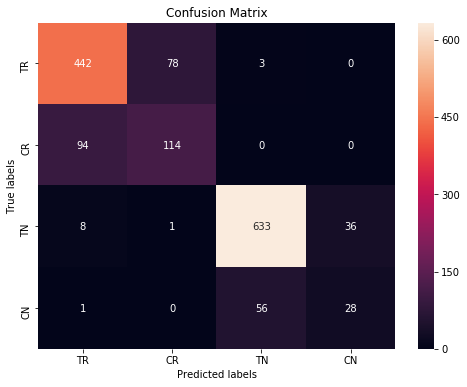

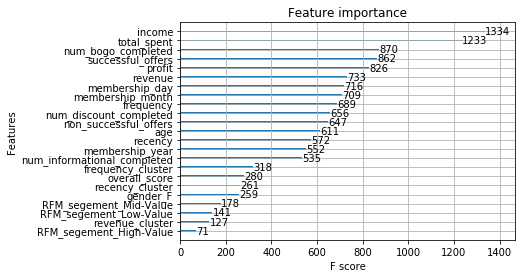

In [876]:
# full features 
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']

model = create_uplift_model_4quad(B3_10_7_10_df, model_features)

**Summary**

- The classification report provides a summary for the metrics for the model so the avg accuracy acheived was 0.81, recall 0.66, f1-score: 0.67. The model was able to identify best the TN class followed by TR compared to the control segments CR and CN.

**Next Steps:**

- Try to tune the parameters and use top features from the features importance and get the accuracy

- Tune the xgboost parameters 

- Create the promotion stratgey that give us a flag to whether to send a customer a promotion or no. 
- This will be tested against sending promotion to customers that fall in the Treatment response group and sending the promotion to customers with uplift score > 0. Also, will compare the NIR and IRR when sending for all the customers compared to the current model.

In [885]:
# list for the features importance
pd.Series(model.feature_importances_, index=model_features)

email                          0.000000
web                            0.000000
mobile                         0.000000
social                         0.000000
profit                         0.018911
total_spent                    0.195313
num_bogo_completed             0.046328
num_discount_completed         0.017325
num_informational_completed    0.020407
successful_offers              0.040160
non_successful_offers          0.066033
revenue                        0.014554
revenue_cluster                0.292751
recency                        0.012018
recency_cluster                0.020946
frequency                      0.013974
frequency_cluster              0.019629
overall_score                  0.011326
age                            0.014002
income                         0.018444
membership_year                0.034026
membership_month               0.013321
membership_day                 0.012387
gender_F                       0.013255
gender_M                       0.000000


[0]	validation_0-mlogloss:1.27507	validation_1-mlogloss:1.28653
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.18189	validation_1-mlogloss:1.2031


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 0 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 1 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 2 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 3 will be larger than the number of samples in the majority class (class #2 -> 2002)



[2]	validation_0-mlogloss:1.10332	validation_1-mlogloss:1.1333
[3]	validation_0-mlogloss:1.03473	validation_1-mlogloss:1.07275
[4]	validation_0-mlogloss:0.975058	validation_1-mlogloss:1.01927
[5]	validation_0-mlogloss:0.922444	validation_1-mlogloss:0.972906
[6]	validation_0-mlogloss:0.875517	validation_1-mlogloss:0.932737
[7]	validation_0-mlogloss:0.834445	validation_1-mlogloss:0.897043
[8]	validation_0-mlogloss:0.796961	validation_1-mlogloss:0.864688
[9]	validation_0-mlogloss:0.763768	validation_1-mlogloss:0.836135
[10]	validation_0-mlogloss:0.732602	validation_1-mlogloss:0.809057
[11]	validation_0-mlogloss:0.70465	validation_1-mlogloss:0.785326
[12]	validation_0-mlogloss:0.679119	validation_1-mlogloss:0.76417
[13]	validation_0-mlogloss:0.655697	validation_1-mlogloss:0.745139
[14]	validation_0-mlogloss:0.634431	validation_1-mlogloss:0.72734
[15]	validation_0-mlogloss:0.615335	validation_1-mlogloss:0.712083
[16]	validation_0-mlogloss:0.597893	validation_1-mlogloss:0.697294
[17]	validat

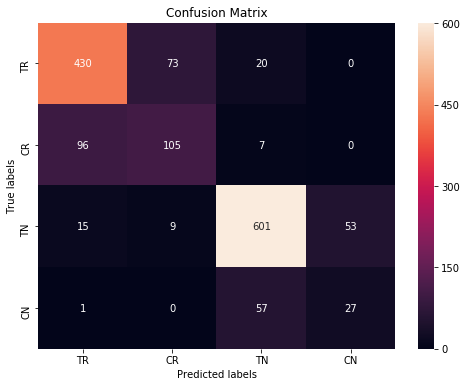

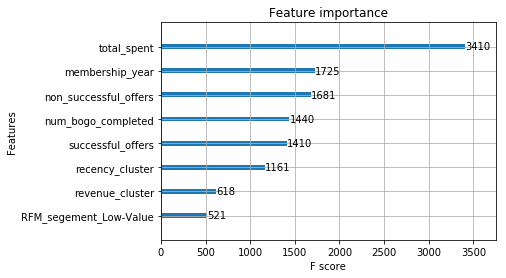

In [898]:
# subset of features (top 5 features)
model_features = np.array(['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value'])
importances = model.feature_importances_
subset_features = model_features[(np.argsort(importances)[::-1])[:8]]
second_model = create_uplift_model_4quad(B3_10_7_10_df, subset_features)

** say sth**

### Tune the Xgboost model parameters 

The parameters that can be optimized:

    - max_depth which is the max number of different features used in each tree
    
    - learning rate: the model learning rate (the update of parameters rate) this can help in combatting the overfitting of the model. the values range from 0.1 - 0.01
    
    - subsample : which is for each tree the % of rows taken to build the tree [0.8 - 1]
    
    - colsample_bytree: number of columns used by each tree. [0.3 - 0.8 ] or [0.8 - 1] for few columns
    
    - gamma: regularization  parameter [0,1, 5]
    
    - n_estimators = 100 (depending on the size of the data)
    
RandomGrid Search will be used to tune the model parameters and find the best parameters

In [991]:
def get_model_best_params(X_train, y_train, clf):
    """
        This Method use Random Grid search to find the best parameters for the model
        Args:
            X_train: training features
            y_train: target 
            clf: classifier model
        Returns:
            model with the best parameters
    """

    param_grid = {
        'n_estimators': [25, 50, 100, 200, 500],
        'max_depth': [3, 5, 8 ,10],
        'gamma': [0.01, 0.1, 0.5, 1, 1.5, 2, 6],
        'subsample':[0.5,  0.8,  1.0],
        'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
        'learning_rate': [0.01, 0.05, 0.1, 0.2], 
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 10.0],
        'silent': [False]
    }
    fit_params = {
        "verbose":True,
        "eval_set":eval_set
    }
    rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                           scoring='f1_weighted',  random_state=42)


    print("Randomized search..")
    rs_clf.fit(X_train, y_train)

    best_score = rs_clf.best_score_
    best_params = rs_clf.best_params_

    print("Best params: ")
    for param_name in sorted(best_params.keys()):
        print('%s: %r' % (param_name, best_params[param_name]))
    
    model = rs_clf.best_estimator_

    return model

In [1002]:
def create_uplift_model_4quad_tuned(dataframe, model_features):
    """
        This Method creates and build an uplift model using Xgboost
            - drop unnecassry data
            - split the data into training and test data 
            - smote 
            - train the model
            - plot the confusion matrix and the features importance
    Args:
        Offer DataFrame
    Returns:
      Trained model model
    """
    df = dataframe.copy()
    df.drop(columns=['offer_id', 'customer_id'], inplace=True)
    
    # create train, validation, test dataset
    X = df.drop('segment', axis=1)
    y = df['segment']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    X_train = X_train[model_features]
    X_val = X_val[model_features]

    # SMOTE analysis
    sm = SMOTE({0:max(df.segment.value_counts()[:]), 1:max(df.segment.value_counts()[:]), 2:max(df.segment.value_counts()[:]), 3:max(df.segment.value_counts()[:])}, random_state=42)

    X_train_upsamp, y_train_upsamp = sm.fit_sample(X_train, y_train)

    X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=model_features)

    y_train_upsamp = pd.Series(y_train_upsamp)

    # Tune parameter model
    eval_set = [(X_train_upsamp, y_train_upsamp), (X_val, y_val)]
    
    eval_set = [(X_train_upsamp, y_train_upsamp), (X_val, y_val)]

    clf= xgb.XGBClassifier(num_class=4, objective = 'multi:softmax')

    # use the best parameters 
    model = get_model_best_params(X_train_upsamp, y_train_upsamp, clf)
    # create confusion matrix heat map 
    
    valid_pred = model.predict(X_val[model_features])
    
     # print the accuracy score for the validation data    
    accuracy = classification_report(y_val, valid_pred, target_names=['TR', 'CR', 'TN', 'CN'])
    print(accuracy, 'accuracy')
    
    cm = confusion_matrix(y_val, valid_pred)

    fig, ax= plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
    ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

    # features importance 
    plot_importance(model)
    return model


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 0 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 1 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 2 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 3 will be larger than the number of samples in the majority class (class #2 -> 2002)

/home/nisreen/an

Best params: 
colsample_bytree: 0.8
gamma: 1.5
learning_rate: 0.1
max_depth: 10
min_child_weight: 3.0
n_estimators: 500
reg_alpha: 0
reg_lambda: 2
silent: False
subsample: 0.5
              precision    recall  f1-score   support

          TR       0.81      0.82      0.81       523
          CR       0.56      0.54      0.55       208
          TN       0.91      0.95      0.93       678
          CN       0.52      0.29      0.38        85

    accuracy                           0.81      1494
   macro avg       0.70      0.65      0.67      1494
weighted avg       0.80      0.81      0.81      1494
 accuracy


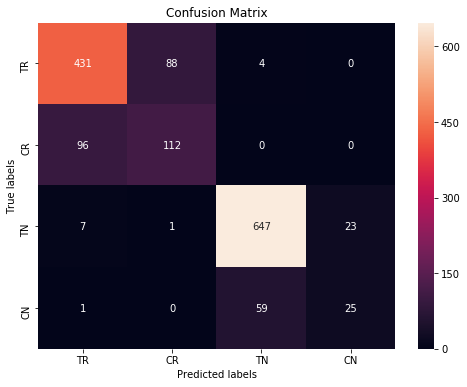

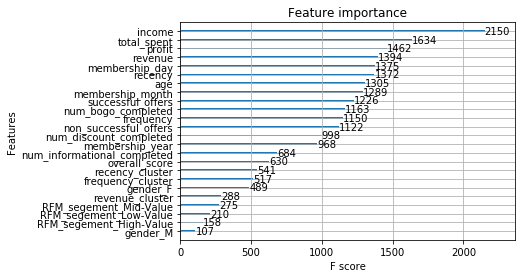

In [956]:
# full features 
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
%time
model = create_uplift_model_4quad_tuned(B3_10_7_10_df, model_features)

**comment about tunning**

In [980]:
#def base_promotion(mode)
def promotion_strategy_simple_4QD(model, test, base=False):
    """
    This method computes when the promotion shall be sent to the customer.
    Args:
        df: test dataframe without label
    Returns:
        promotion indicator
    """
    
    if base:
        promotion = np.array([1] * test.shape[0])
        return promotion
    else:
        pred = model.predict(test)#, ntree_limit=model.best_ntree_limit)
        promotion = []
        for pred in pred:
            if pred == 0:
                promotion.append(1)
            else:
                promotion.append(0)

        promotion = np.array(promotion)

        return promotion
    
def promotion_strategy_4QD(model, test, base=False):
    """
    This method computes uplift score based on the forumla 
     uplift = P_TR + P_CN - P_TN - P_CR (higher score means higher uplift and more responsive
     to promotion) will assume if uplift > 0 send a promotion
    Args:
        df: test dataframe without label
     Returns:
        promotion indicator
    """
    if base:
        promotion = np.array([1] * test.shape[0])
        return promotion
    else:
        class_probs = model.predict_proba(test)#, ntree_limit=model.best_ntree_limit)
        uplift_score = class_probs[:,0] + class_probs[:,3] - class_probs[:,1] - class_probs[:,2]
        promotion = []
        
        for pred in uplift_score:
            if pred > 0 :
                promotion.append(1)
            else:
                promotion.append(0)

        promotion = np.array(promotion)
        return promotion

In [979]:
def test_results(promotion_strategy, X_test, y_test, model, base=False):
    """
        This functions prints the IRR and NIR acheived by the current model
        from the given data
        
        - treatment groups are under segment 0 and 2
        - control groups are 1 and 3
        -  net revenue earned by company after running the promotional campaign so for the treatment,
        we can use the profit column summed to take into account the cost while 
        - control revenue is the sum of the total spent by the control groups 
        Args:
        
        Returns:
            None
    """
    # for yes i need to count how many completed 
    # for no how many are completed so i need complete
    model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']

    data = pd.concat([X_test, y_test], axis=1)

    promos = promotion_strategy(model, X_test[model_features], base)
    # we get the data that is labeled promotion and get the score for the data
    promotions_df = data.iloc[np.where(promos == 1)]

    n_treat = promotions_df[promotions_df.segment.isin([0,2])].shape[0]
    
    n_control = promotions_df[promotions_df.segment.isin([1,3])].shape[0]
    
    n_treatment_complete = promotions_df[promotions_df.segment.isin([0])].shape[0]
    n_control_complete = promotions_df[promotions_df.segment.isin([1])].shape[0]
    
    #revenue is total spent for each group
     
    treatment_revenue = promotions_df[promotions_df.segment.isin([0,2])].profit.sum()
    control_revenue = promotions_df[promotions_df.segment.isin([1,3])].total_spent_non_offer.sum()
    
    irr = (n_treatment_complete / n_treat) - (n_control_complete/ n_control)
    
    nir = (treatment_revenue ) - control_revenue 
    
    print('Your irr with this strategy is {:0.2f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

**comment**

In [959]:
test_results(promotion_strategy_4QD, X_test, y_test, model)

[-0.9798712  -0.9139423   0.97679406 ... -0.19231564  0.90224016
 -0.41633266] uplift_scores
Your irr with this strategy is 0.14.

Your nir with this strategy is 14716.45.


(0.13573424796747968, 14716.45)

In [963]:
test_results(promotion_strategy_simple_4QD, X_test, y_test, model)

Your irr with this strategy is -0.00.

Your nir with this strategy is 14716.76.


(-0.004366812227074246, 14716.759999999998)

In [964]:
test_results(promotion_strategy_simple_4QD, X_test, y_test, model, base =True)

Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.


(-0.2491075534920391, 17256.690000000002)

**Summary**
### Two model approach 
two models that predicts the completion of the promotion with one for the treamtment group and another for the control group.
Then an uplift score will be calculated and promotion will be sent to the top 3 percentile

In [969]:
#treatment group model group model 
B3_10_7_10_df_control = B3_10_7_10_df[B3_10_7_10_df.segment.isin([1,3])]
B3_10_7_10_df_treatment = B3_10_7_10_df[B3_10_7_10_df.segment.isin([0,2])]

In [970]:
B3_10_7_10_df_control.completed.value_counts()

1.0    1058
0.0    457 
Name: completed, dtype: int64

In [976]:
def create_uplift_2model(dataframe, model_features, target_column='segment'):
    """
        This Method creates and build an uplift model using Xgboost
            - drop unnecassry data
            - split the data into training and test data 
            - smote 
            - train the model
            - plot the confusion matrix and the features importance
    Args:
        Offer DataFrame
    Returns:
      Trained model model
    """
    df = dataframe.copy()
    df.drop(columns=['offer_id', 'customer_id'], inplace=True)
    
    # create train, validation, test dataset
    X = df.drop(target_column, axis=1)
    y = df[target_column]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    X_train = X_train[model_features]
    X_val = X_val[model_features]

    # SMOTE analysis
    sm = SMOTE({0:max(df[target_column].value_counts()[:]), 1:max(df[target_column].value_counts()[:])}, random_state=42)

    X_train_upsamp, y_train_upsamp = sm.fit_sample(X_train, y_train)

    X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=model_features)

    y_train_upsamp = pd.Series(y_train_upsamp)

    # Tune parameter model
    eval_set = [(X_train_upsamp, y_train_upsamp), (X_val, y_val)]
    
    eval_set = [(X_train_upsamp, y_train_upsamp), (X_val, y_val)]

    clf= xgb.XGBClassifier(objective = 'binary:logistic')

    # use the best parameters 
    model = get_model_best_params(X_train_upsamp, y_train_upsamp, clf)
    # create confusion matrix heat map 
    
    valid_pred = model.predict(X_val[model_features])
    
     # print the accuracy score for the validation data    
    accuracy = classification_report(y_val, valid_pred, target_names=['Not Completed Offer', 'Completed Offer'])
    print(accuracy, 'accuracy')
    
    cm = confusion_matrix(y_val, valid_pred)

    fig, ax= plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not Completed Offer', 'Completed Offer']); 
    ax.yaxis.set_ticklabels(['Not Completed Offer', 'Completed Offer']);

    # features importance 
    plot_importance(model)
    return model

def get_model_best_params(X_train, y_train, clf):
     """
        This Method use Random Grid search to find the best parameters for the model
        Args:
            X_train: training features
            y_train: target 
            clf: classifier model
        Returns:
            model with the best parameters
    """

    param_grid = {
        'n_estimators': [25, 50, 100, 200, 500],
        'max_depth': [3, 5, 8 ,10],
        'gamma': [0.01, 0.1, 0.5, 1, 1.5, 2, 6],
        'subsample':[0.5,  0.8,  1.0],
        'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
        'learning_rate': [0.01, 0.05, 0.1, 0.2], 
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 10.0],
        'silent': [False]
    }
    fit_params = {
        "verbose":True,
        "eval_set":eval_set
    }
    rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                           scoring='f1_weighted',  random_state=42)


    print("Randomized search..")
    rs_clf.fit(X_train, y_train)

    best_score = rs_clf.best_score_
    best_params = rs_clf.best_params_

    print("Best params: ")
    for param_name in sorted(best_params.keys()):
        print('%s: %r' % (param_name, best_params[param_name]))
    
    model = rs_clf.best_estimator_

    return model

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (1058) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 636)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (1058) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 636)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.01
learning_rate: 0.05
max_depth: 8
min_child_weight: 0.5
n_estimators: 100
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      0.99      0.99        88
    Completed Offer       1.00      1.00      1.00       215

           accuracy                           1.00       303
          macro avg       1.00      0.99      1.00       303
       weighted avg       1.00      1.00      1.00       303
 accuracy


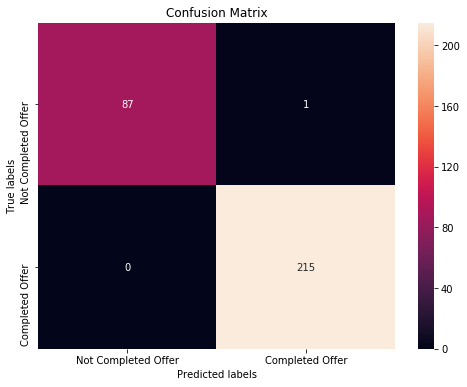

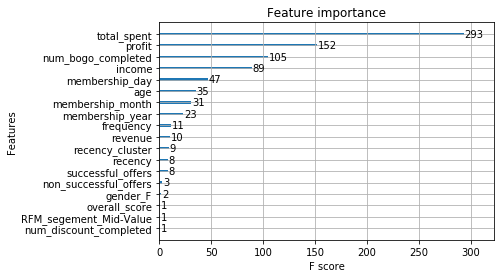

In [977]:
B3_10_7_10_control_model = create_uplift_2model(B3_10_7_10_df_control, model_features, target_column='completed')

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 0 will be larger than the number of samples in the majority class (class #0.0 -> 1991)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3322) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 1991)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       1.00      0.99      0.99       640
    Completed Offer       0.99      0.99      0.99       551

           accuracy                           0.99      1191
          macro avg       0.99      0.99      0.99      1191
       weighted avg       0.99      0.99      0.99      1191
 accuracy


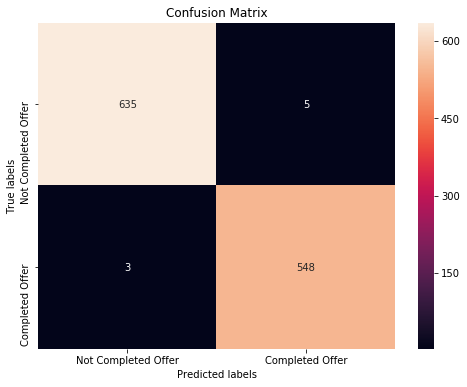

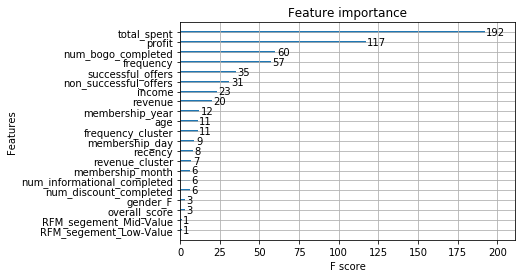

In [978]:
B3_10_7_10_treatment_model = create_uplift_2model(B3_10_7_10_df_treatment, model_features, target_column='completed')

**comment**

In [988]:
# promotion staretgy
def promotion_strategy_2models(model_control, model_treatment, test, base=False):
    """
    This method computes lift score based on the forumla 
     uplift = prob_offer_completion_treatment - prob_offer_completion_control
     promotion will be sent to the highest 3rd percentile
    Args:
        df: test dataframe without label
     Returns:
        promotion indicator
    """
    if base:
        promotion = np.array([1] * test.shape[0])
        return promotion
    else:

        pred_probs_contol = model_control.predict_proba(test)

        pred_probs_exper = model_treatment.predict_proba(test)

        # get difference in probabilities between experimental and control model for purchase = 1 label
        lift = pred_probs_exper[:,1] - pred_probs_contol[:,1]
        promotion = []

        # Only send promotions to top 3 percentile of probabilities
        cutoff_lift = np.percentile(lift, 97)
    
        for prob in lift:
            if prob > 0  and prob > cutoff_lift:
                promotion.append(1)
            else:
                promotion.append(0)

        promotion = np.array(promotion)
        return promotion
def test_results_2(promotion_strategy, X_test, y_test, model_control, model_treatment,base=False):
    """
        This functions prints the IRR and NIR acheived by the current model
        from the given data
        
        - treatment groups are under segment 0 and 2
        - control groups are 1 and 3
        -  net revenue earned by company after running the promotional campaign so for the treatment,
        we can use the profit column summed to take into account the cost while 
        - control revenue is the sum of the total spent by the control groups 
        Args:
        
        Returns:
            None
    """
    # for yes i need to count how many completed 
    # for no how many are completed so i need complete
    model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']

    data = pd.concat([X_test, y_test], axis=1)

    promos = promotion_strategy(model_control, model_treatment, X_test[model_features], base)
    # we get the data that is labeled promotion and get the score for the data
    promotions_df = data.iloc[np.where(promos == 1)]

    n_treat = promotions_df[promotions_df.segment.isin([0,2])].shape[0]
    
    n_control = promotions_df[promotions_df.segment.isin([1,3])].shape[0]
    
    n_treatment_complete = promotions_df[promotions_df.segment.isin([0])].shape[0]
    n_control_complete = promotions_df[promotions_df.segment.isin([1])].shape[0]
    
    #revenue is total spent for each group
     
    treatment_revenue = promotions_df[promotions_df.segment.isin([0,2])].profit.sum()
    control_revenue = promotions_df[promotions_df.segment.isin([1,3])].total_spent.sum()
    
    irr = (n_treatment_complete / n_treat) - (n_control_complete/ n_control)
    
    nir = (treatment_revenue ) - control_revenue 
    
    print('Your irr with this strategy is {:0.2f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

In [989]:
test_results_2(promotion_strategy_2models, X_test, y_test, B3_10_7_10_control_model, B3_10_7_10_treatment_model)

Your irr with this strategy is -0.03.

Your nir with this strategy is 1063.22.


(-0.025000000000000022, 1063.2199999999998)

In [990]:
test_results_2(promotion_strategy_2models, X_test, y_test, B3_10_7_10_control_model, B3_10_7_10_treatment_model, base= True)

Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.


(-0.2491075534920391, 17256.690000000002)

**Summary**
## One model approach 

This approach use one model that assign 1 to treatment and completed offer group the rest of the groups gets 0.

In [993]:
# create target column
B3_10_7_10_df['response'] = B3_10_7_10_df.segment.apply(lambda x:1 if x== 0 else 0)
B3_10_7_10_df

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on         income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value  response
13     0020c2b971eb4e9188eac86d93036a77  168            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     336.0            0.0        336.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 2.0                     0.0                          0           2.0                3                      3        196.86   1                6        3                8          1                  5              59.000000 2016-03-04        90000.000000   2016             3                 4               1         0         0                       1                       0                        0       
35     004c5799adbf42868b9cff0396190900  336            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     504.0            1.0        336.0   0.0     0.0      0.0        1                     0.00               107.07                 97.07   107.07       3.0                 2.0                     0.0                          1           3.0                2                      1        347.38   2                24       3                12         2                  7              54.000000 2016-03-31        99000.000000   2016             3                 31              0         1         0                       0                       1                        0       
39     005500a7188546ff8a767329a2f7c76a  0              ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     168.0            0.0        168.0   1.0     0.0      60.0       0                     0.00               0.00                   0.00    0.00         1.0                 0.0                     0.0                          0           0.0                5                      2        20.36    0                126      2                4          0                  2              56.000000 2017-12-09        47000.000000   2017             12                9               0         1         1                       0                       0                        0       
40     005500a7188546ff8a767329a2f7c76a  168            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     336.0            0.0        336.0   1.0     0.0      186.0      0                     9.71               0.00                   9.71    9.71         1.0                 0.0                     0.0                          1           0.0                5                      2        20.36    0                126      2                4          0                  2              56.000000 2017-12-09        47000.000000   2017             12                9               0         1         1                       0                       0                        0       
43     005500a7188546ff8a767329a2f7c76a  576            ae264e3637204a6fb9bb56bc8210ddfd  10.0        7.0       bogo       10.0    1.0    0.0  1.0     1.0     744.0            0.0        744.0   1.0     0.0      576.0      0                     10.65              0.00                   10.65   10.65        1.0                 0.0            

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4837) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2916)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4837) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2916)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.90      0.89      0.90       971
    Completed Offer       0.81      0.81      0.81       523

           accuracy                           0.86      1494
          macro avg       0.85      0.85      0.85      1494
       weighted avg       0.86      0.86      0.86      1494
 accuracy


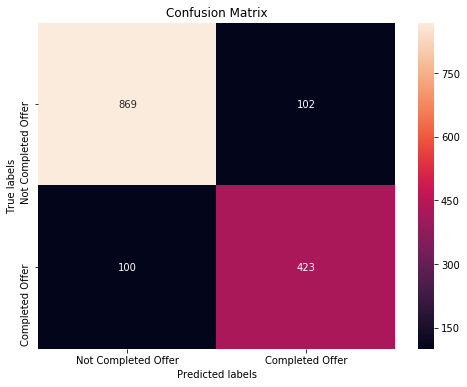

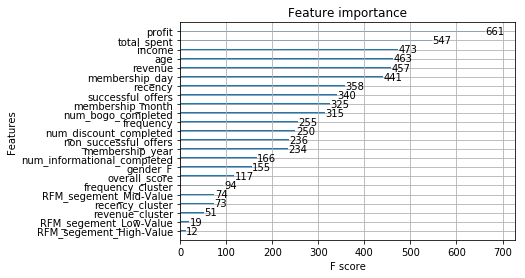

In [994]:
# use the same function used in the 2 model 
B3_10_7_10_one_model = create_uplift_2model(B3_10_7_10_df, model_features, target_column='response')

**comment**

In [996]:
#promotion startgy --> same test results 
def promotion_strategy_1D(model, test, base=False):
    """
    This method computes when the promotion shall be sent to the customer.
    Args:
        df: test dataframe without label
    Returns:
        promotion indicator
    """
    
    if base:
        promotion = np.array([1] * test.shape[0])
        return promotion
    else:
        pred = model.predict(test)
        promotion = []
        for pred in pred:
            if pred == 1:
                promotion.append(1)
            else:
                promotion.append(0)

        promotion = np.array(promotion)

        return promotion

In [997]:
test_results(promotion_strategy_1D, X_test, y_test, B3_10_7_10_one_model)

Your irr with this strategy is 0.00.

Your nir with this strategy is 13964.77.


(0.0, 13964.77)

In [998]:
test_results(promotion_strategy_1D, X_test, y_test, B3_10_7_10_one_model, base=True)

Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.


(-0.2491075534920391, 17256.690000000002)

### B4_10_5_10:
This is a BOGO offer that group is sent through 4 channels, difficulty 10, duration 5 days and a reward of 10. 
 
### Four Quadrant approach 

In [999]:
B4_10_5_10.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on    income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
15  0020c2b971eb4e9188eac86d93036a77  408            4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     528.0            1.0        510.0   1.0     1.0      426.0      0                     17.24              0.00                   7.24    17.24        1.0                 2.0                     0.0                          1           2.0                3                      0        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0   2016             3                 4               1         0         0                       1                       0                      
59  00715b6e55c3431cb56ff7307eb19675  336            4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     456.0            1.0        342.0   0.0     0.0      0.0        1                     0.00               60.55                  50.55   60.55        2.0                 3.0                     0.0                          1           0.0                6                      1        375.12   2                12       3                15         2                  7              58.0 2017-12-07        119000.0  2017             12                7               1         0         0                       0                       1                      
74  00857b24b13f4fe0ad17b605f00357f5  0              4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     120.0            0.0        120.0   1.0     0.0      0.0        0                     1.61               0.00                   1.61    1.61         0.0                 0.0                     0.0                          1           0.0                5                      2        6.26     0                90       2                4          0                  2              71.0 2017-10-23        41000.0   2017             10                23              0         1         1                       0                       0                      
83  008d7088107b468893889da0ede0df5c  504            4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     624.0            0.0        624.0   1.0     0.0      558.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                6                      2        16.18    0                264      0                7          1                  1              24.0 2017-09-10        42000.0   2017             9                 10              0         1         1                       0                       0                      
85  0091d2b6a5ea4defaa8393e4e816db60  0              4d5c57ea9a6940dd891ad53e9dbe8da0  10.0        5.0       bogo       10.0    1.0    1.0  1.0     1.0     120.0            1.0        6.0     1.0     1.0      6.0        0                     46.00              0.00                   36.00   46.00        3.0                 1.0                     0.0                          1           4.0                1                      0        279.16   2    

In [1000]:
B4_10_5_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7413 entries, 15 to 74385
Data columns (total 47 columns):
customer_id                    7413 non-null object
time_received                  7413 non-null int64
offer_id                       7413 non-null object
difficulty                     7413 non-null float64
duration                       7413 non-null float64
offer_type                     7413 non-null object
reward                         7413 non-null float64
email                          7413 non-null float64
web                            7413 non-null float64
mobile                         7413 non-null float64
social                         7413 non-null float64
expected_finish                7413 non-null float64
completed                      7413 non-null float64
finish                         7413 non-null float64
viewed                         7413 non-null float64
success                        7413 non-null float64
view_time                      7413 non-null flo

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3846) in class 0 will be larger than the number of samples in the majority class (class #2 -> 2295)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3846) in class 1 will be larger than the number of samples in the majority class (class #2 -> 2295)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3846) in class 2 will be larger than the number of samples in the majority class (class #2 -> 2295)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3846) in class 3 will be larger than the number of samples in the majority class (class #2 -> 2295)

/home/nisreen/an

Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.85      0.93      0.89       538
          CR       0.54      0.36      0.43       124
          TN       0.93      0.97      0.95       766
          CN       0.12      0.04      0.06        55

    accuracy                           0.87      1483
   macro avg       0.61      0.57      0.58      1483
weighted avg       0.84      0.87      0.85      1483
 accuracy


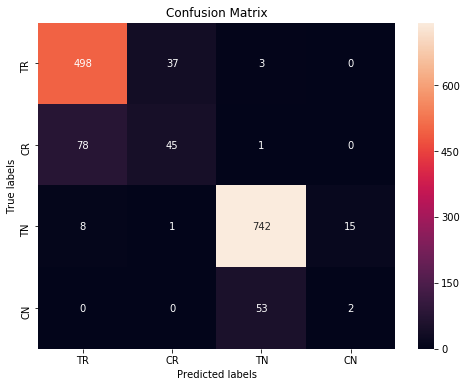

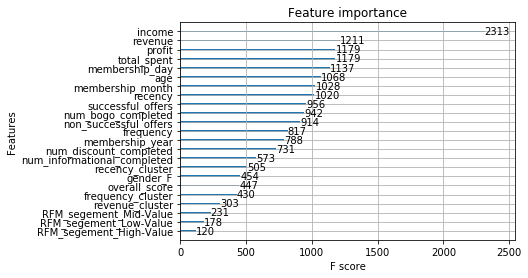

In [1003]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
get_ipython().run_line_magic('time', '')
model = create_uplift_model_4quad_tuned(B4_10_5_10, model_features)

**comment**

In [1004]:
print(test_results(promotion_strategy_4QD, X_test, y_test, model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, model, base =True),'base strategy results')

Your irr with this strategy is 0.00.

Your nir with this strategy is 13359.21.
(0.00339726027397258, 13359.21) using the uplift forumla strategy results
Your irr with this strategy is -0.01.

Your nir with this strategy is 13351.23.
(-0.007148407148407143, 13351.230000000003) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


**comment**
### Two model approach 

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (564) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 343)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (564) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 343)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.01
learning_rate: 0.05
max_depth: 8
min_child_weight: 0.5
n_estimators: 100
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      0.98      0.99        58
    Completed Offer       0.99      1.00      1.00       102

           accuracy                           0.99       160
          macro avg       1.00      0.99      0.99       160
       weighted avg       0.99      0.99      0.99       160
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3846) in class 0 will be larger than the number of samples in the majority class (class #0.0 -> 2346)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3846) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 2346)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 0.8
gamma: 0.5
learning_rate: 0.05
max_depth: 10
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      0.99      0.99       765
    Completed Offer       0.98      0.99      0.99       558

           accuracy                           0.99      1323
          macro avg       0.99      0.99      0.99      1323
       weighted avg       0.99      0.99      0.99      1323
 accuracy
Your irr with this strategy is -0.12.

Your nir with this strategy is 749.26.
(-0.125, 749.26) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


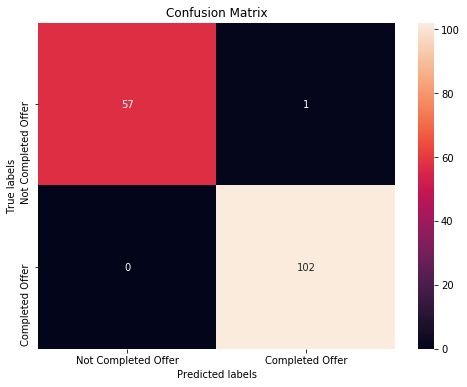

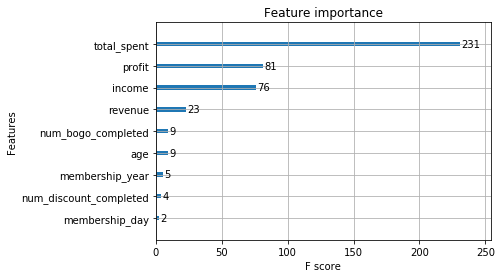

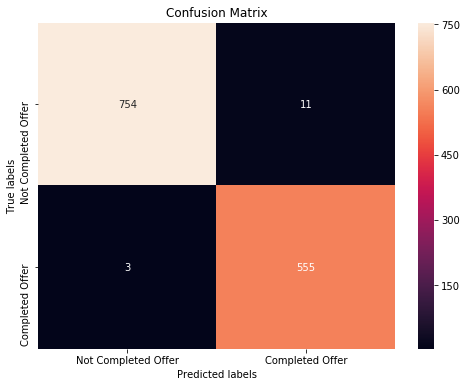

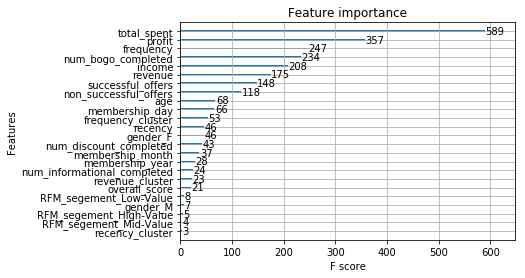

In [1030]:
# 2 models approach 
#2 model approach 
B4_10_5_10_control = B4_10_5_10[B4_10_5_10.segment.isin([1,3])]
B4_10_5_10_treatment = B4_10_5_10[B4_10_5_10.segment.isin([0,2])]



B4_10_5_10_control_model = create_uplift_2model(B4_10_5_10_control, model_features, target_column='completed')

B4_10_5_10_treatment_model = create_uplift_2model(B4_10_5_10_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, B4_10_5_10_control_model, B4_10_5_10_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, B4_10_5_10_control_model, B4_10_5_10_treatment_model, base= True),'base strategy results')


**summary**


### B3_5_7_5
This is a BOGO offer that group is sent through 3 channels, difficulty 5, duration 7 days and a reward of 5. 

In [1031]:
B3_5_7_5.head()

B3_5_7_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7496 entries, 11 to 74394
Data columns (total 48 columns):
customer_id                    7496 non-null object
time_received                  7496 non-null int64
offer_id                       7496 non-null object
difficulty                     7496 non-null float64
duration                       7496 non-null float64
offer_type                     7496 non-null object
reward                         7496 non-null float64
email                          7496 non-null float64
web                            7496 non-null float64
mobile                         7496 non-null float64
social                         7496 non-null float64
expected_finish                7496 non-null float64
completed                      7496 non-null float64
finish                         7496 non-null float64
viewed                         7496 non-null float64
success                        7496 non-null float64
view_time                      7496 non-null flo

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2220) in class 0 will be larger than the number of samples in the majority class (class #1 -> 1352)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2220) in class 1 will be larger than the number of samples in the majority class (class #1 -> 1352)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2220) in class 2 will be larger than the number of samples in the majority class (class #1 -> 1352)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2220) in class 3 will be larger than the number of samples in the majority class (class #1 -> 1352)

/home/nisreen/an

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.79      0.78      0.78       441
          CR       0.78      0.79      0.78       443
          TN       0.74      0.64      0.68       258
          CN       0.77      0.84      0.80       357

    accuracy                           0.77      1499
   macro avg       0.77      0.76      0.76      1499
weighted avg       0.77      0.77      0.77      1499
 accuracy
Your irr with this strategy is -0.04.

Your nir with this strategy is 15303.19.
(-0.03883038183208798, 15303.19) using the uplift forumla strategy results
Your irr with this strategy is -0.05.

Your nir with this strategy is 13598.12.
(-0.04749908725812346, 13598.120000000003) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69

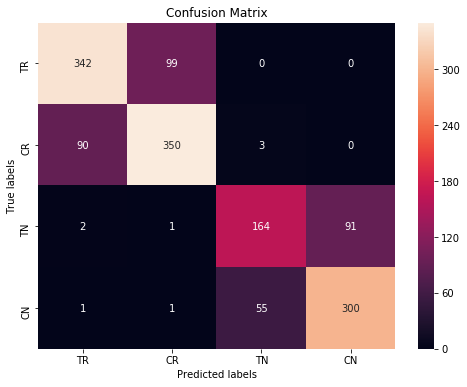

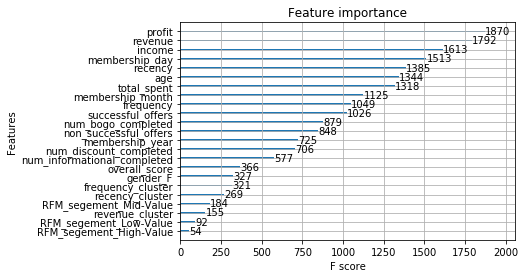

In [1013]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
B3_5_7_5_model = create_uplift_model_4quad_tuned(B3_5_7_5, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, B3_5_7_5_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, B3_5_7_5_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, B3_5_7_5_model, base =True),'base strategy results')

**comment**

### Two model approach

Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2220) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 1317)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2220) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 1317)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 0.8
gamma: 0.5
learning_rate: 0.05
max_depth: 10
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       364
    Completed Offer       1.00      1.00      1.00       448

           accuracy                           1.00       812
          macro avg       1.00      1.00      1.00       812
       weighted avg       1.00      1.00      1.00       812
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2134) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 1275)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2134) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 1275)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 1.0
gamma: 0.01
learning_rate: 0.05
max_depth: 8
min_child_weight: 0.5
n_estimators: 100
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      0.99      0.99       258
    Completed Offer       0.99      1.00      1.00       430

           accuracy                           0.99       688
          macro avg       0.99      0.99      0.99       688
       weighted avg       0.99      0.99      0.99       688
 accuracy
Your irr with this strategy is 0.00.

Your nir with this strategy is 127.35.
(0.0, 127.35000000000001) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


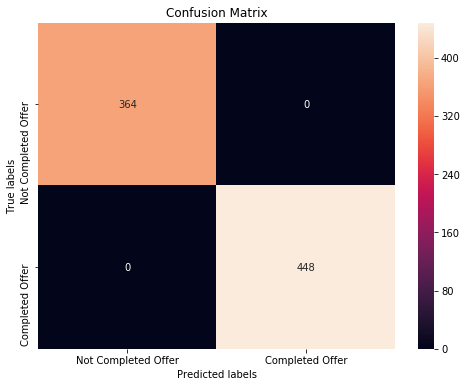

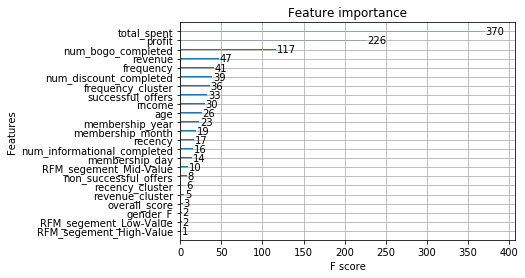

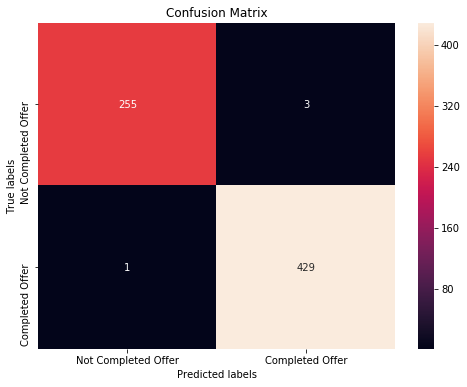

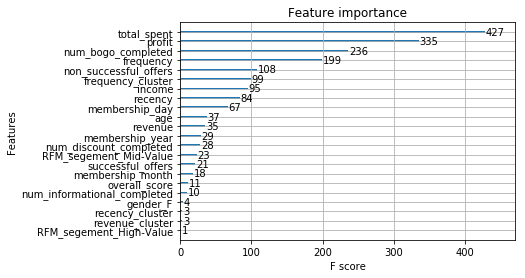

In [1032]:
B3_5_7_5_control = B3_5_7_5[B3_5_7_5.segment.isin([1,3])]
B3_5_7_5_treatment = B3_5_7_5[B3_5_7_5.segment.isin([0,2])]



B3_5_7_5_control_model = create_uplift_2model(B3_5_7_5_control, model_features, target_column='completed')

B3_5_7_5_treatment_model = create_uplift_2model(B3_5_7_5_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, B3_5_7_5_control_model, B3_5_7_5_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, B3_5_7_5_control_model, B3_5_7_5_treatment_model, base= True),'base strategy results')

### One model approach

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (5362) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3220)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (5362) in class 1 will be larger than the number of samples in the majority class (class #0 -> 3220)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.90      0.91      0.90      1058
    Completed Offer       0.77      0.76      0.77       441

           accuracy                           0.86      1499
          macro avg       0.84      0.83      0.83      1499
       weighted avg       0.86      0.86      0.86      1499
 accuracy
Your irr with this strategy is -0.03.

Your nir with this strategy is 12645.48.
(-0.030013550135501443, 12645.480000000001) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


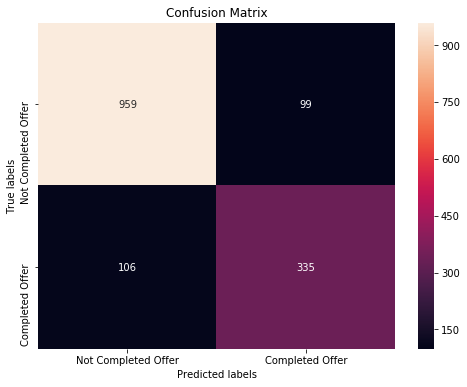

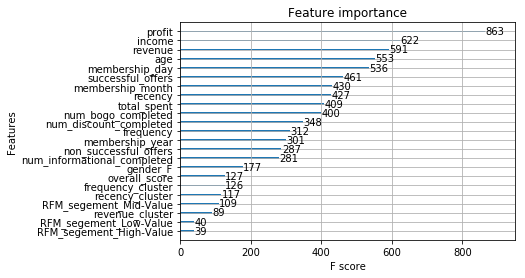

In [1033]:
# create target column
B3_5_7_5['response'] = B3_5_7_5.segment.apply(lambda x:1 if x== 0 else 0)
B3_5_7_5

B3_5_7_5_one_model = create_uplift_2model(B3_5_7_5, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, B3_5_7_5_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, B3_5_7_5_one_model, base=True))


**summary**




### B4_5_5_5
This is a BOGO offer that group is sent through 4 channels, difficulty 5, duration 5 days and a reward of 5. 

In [1015]:
B4_5_5_5.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
2   0009655768c64bdeb2e877511632db8f  408            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     528.0            1.0        414.0   0.0     0.0      0.0        1                     0.00               22.68                  17.68   22.68        1.0                 2.0                     2.0                          1           2.0                3                      1        127.60   1                18       3                8          1                  5              33.000000 2017-04-21        72000.000000  2017             4                 21              0         1         0                       1                       0                      
5   00116118485d4dfda04fdbaba9a87b5c  168            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     288.0            0.0        288.0   1.0     0.0      216.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                2                      2        4.09     0                240      1                3          0                  1              54.393524 2018-04-25        65404.991568  2018             4                 25              0         1         1                       0                       0                      
6   00116118485d4dfda04fdbaba9a87b5c  576            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     696.0            0.0        696.0   1.0     0.0      630.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                2                      2        4.09     0                240      1                3          0                  1              54.393524 2018-04-25        65404.991568  2018             4                 25              0         1         1                       0                       0                      
18  0020ccbbb6d84e358d3414a3ff76cffd  336            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     456.0            1.0        378.0   1.0     1.0      348.0      0                     54.30              0.00                   49.30   54.30        2.0                 1.0                     1.0                          1           4.0                0                      0        154.05   1                42       3                12         2                  6              24.000000 2016-11-11        60000.000000  2016             11                11              1         0         0                       0                       1                      
32  004b041fbfe44859945daa2c7f79ee64  504            f19421c1d4aa40978ebb69ca19b0e20d  5.0         5.0       bogo       5.0     1.0    1.0  1.0     1.0     624.0            1.0        534.0   1.0     1.0      510.0      0                     27.92              0.00                   22.92   27.92        1.0                 1.0                     0.0                          1           2.0                1

In [1016]:
B4_5_5_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7387 entries, 2 to 74388
Data columns (total 47 columns):
customer_id                    7387 non-null object
time_received                  7387 non-null int64
offer_id                       7387 non-null object
difficulty                     7387 non-null float64
duration                       7387 non-null float64
offer_type                     7387 non-null object
reward                         7387 non-null float64
email                          7387 non-null float64
web                            7387 non-null float64
mobile                         7387 non-null float64
social                         7387 non-null float64
expected_finish                7387 non-null float64
completed                      7387 non-null float64
finish                         7387 non-null float64
viewed                         7387 non-null float64
success                        7387 non-null float64
view_time                      7387 non-null floa

Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3545) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2093)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3545) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2093)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3545) in class 2 will be larger than the number of samples in the majority class (class #0 -> 2093)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3545) in class 3 will be larger than the number of samples in the majority class (class #0 -> 2093)

/home/nisreen/an

Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.87      0.92      0.89       718
          CR       0.45      0.34      0.38       145
          TN       0.94      0.98      0.96       579
          CN       0.18      0.06      0.09        36

    accuracy                           0.86      1478
   macro avg       0.61      0.57      0.58      1478
weighted avg       0.84      0.86      0.85      1478
 accuracy
Your irr with this strategy is -0.05.

Your nir with this strategy is 15506.61.
(-0.051377194234337176, 15506.609999999999) using the uplift forumla strategy results
Your irr with this strategy is -0.06.

Your nir with this strategy is 15522.65.
(-0.05827170817110461, 15522.650000000001) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.249

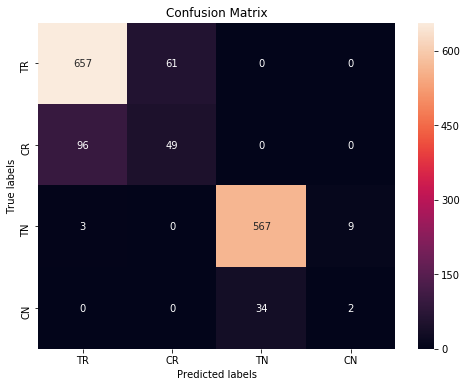

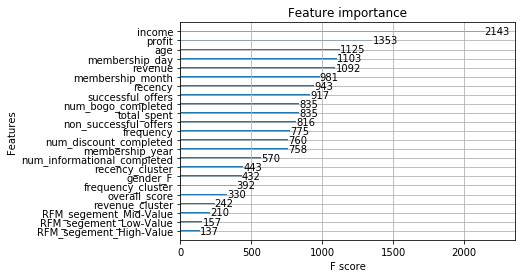

In [1017]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
B4_5_5_5_model = create_uplift_model_4quad_tuned(B4_5_5_5, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, B4_5_5_5_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, B4_5_5_5_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, B4_5_5_5_model, base =True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (751) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 456)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (751) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 456)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 0.8
gamma: 0.5
learning_rate: 0.05
max_depth: 10
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00        35
    Completed Offer       1.00      1.00      1.00       153

           accuracy                           1.00       188
          macro avg       1.00      1.00      1.00       188
       weighted avg       1.00      1.00      1.00       188
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3545) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 2135)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3545) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 2135)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       591
    Completed Offer       1.00      1.00      1.00       699

           accuracy                           1.00      1290
          macro avg       1.00      1.00      1.00      1290
       weighted avg       1.00      1.00      1.00      1290
 accuracy
Your irr with this strategy is -0.34.

Your nir with this strategy is 79.42.
(-0.34285714285714286, 79.42000000000002) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


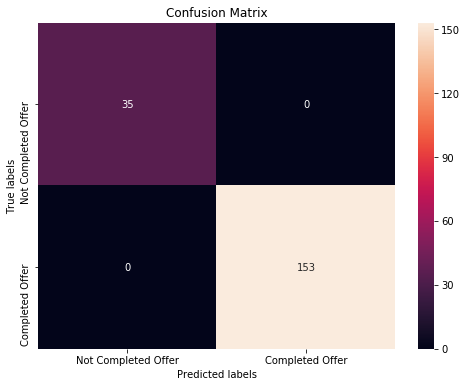

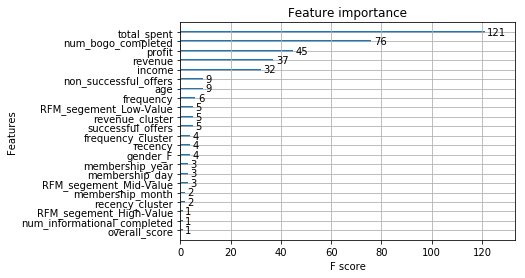

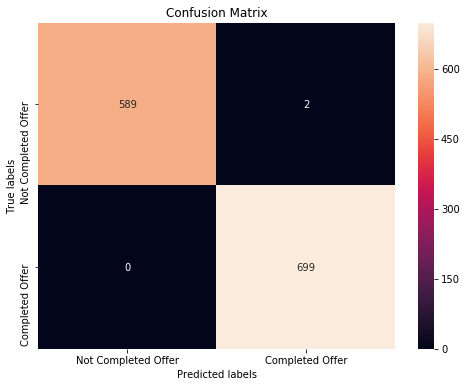

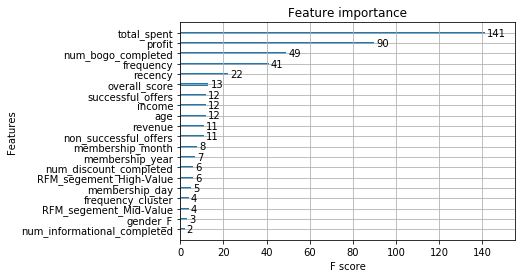

In [1034]:
#2 model approach 
B4_5_5_5_control = B4_5_5_5[B4_5_5_5.segment.isin([1,3])]
B4_5_5_5_treatment = B4_5_5_5[B4_5_5_5.segment.isin([0,2])]



B4_5_5_5_control_model = create_uplift_2model(B4_5_5_5_control, model_features, target_column='completed')

B4_5_5_5_treatment_model = create_uplift_2model(B4_5_5_5_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, B4_5_5_5_control_model, B4_5_5_5_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, B4_5_5_5_control_model, B4_5_5_5_treatment_model, base= True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3842) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2338)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3842) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2338)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.91      0.88      0.89       760
    Completed Offer       0.88      0.91      0.89       718

           accuracy                           0.89      1478
          macro avg       0.89      0.89      0.89      1478
       weighted avg       0.89      0.89      0.89      1478
 accuracy
Your irr with this strategy is -0.06.

Your nir with this strategy is 14178.76.
(-0.06122962005314947, 14178.760000000002) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


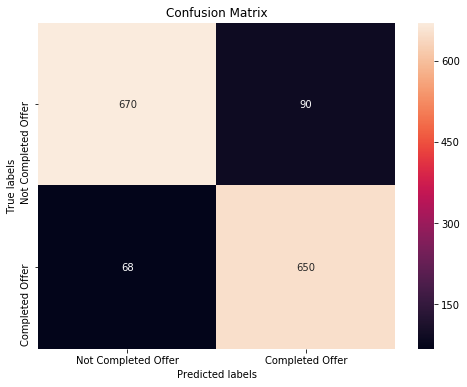

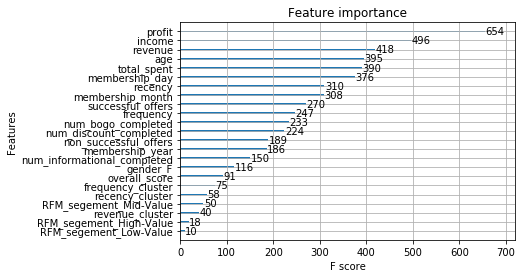

In [1035]:
# ## One model approach 

# create target column
B4_5_5_5['response'] = B4_5_5_5.segment.apply(lambda x:1 if x== 0 else 0)
B4_5_5_5

B4_5_5_5_one_model = create_uplift_2model(B4_5_5_5, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, B4_5_5_5_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, B4_5_5_5_one_model, base=True))

**Summary**


### D2_20_10_5
This is a Discount offer that is sent through 2 channels, difficulty 20, duration 10 days and a reward of 5. 

In [1021]:
D2_20_10_5.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
10  0011e0d4e6b944f998e987f904e8c1e5  408            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     648.0            1.0        576.0   1.0     1.0      432.0      0                     45.08              0.00                   40.08   45.08        1.0                 2.0                     0.0                          1           3.0                2                      0        79.46    0                60       2                5          0                  2              40.000000 2018-01-09        57000.000000  2018             1                 9               0         1         1                       0                       0                      
25  003d66b6608740288d6cc97a6903f4f0  504            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     744.0            1.0        696.0   0.0     0.0      0.0        1                     0.00               20.95                  15.95   20.95        0.0                 3.0                     2.0                          1           4.0                1                      1        48.34    0                18       3                18         3                  6              26.000000 2017-06-21        73000.000000  2017             6                 21              1         0         0                       0                       1                      
28  00426fe3ffde4c6b9cb9ad6d077a13ea  336            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               6.62                   6.62    6.62         0.0                 1.0                     1.0                          1           2.0                3                      3        68.51    0                18       3                17         3                  6              19.000000 2016-08-09        65000.000000  2016             8                 9               1         0         0                       0                       1                      
45  0056df74b63b4298809f0b375a304cf4  408            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     648.0            1.0        414.0   0.0     0.0      0.0        1                     0.00               86.39                  81.39   86.39        1.0                 2.0                     1.0                          1           2.0                2                      1        144.14   1                42       3                5          0                  4              54.000000 2016-08-21        91000.000000  2016             8                 21              0         1         0                       1                       0                      
52  0063def0f9c14bc4805322a488839b32  576            0b1e1539f2cc45b7b9fa7c272da2e1d7  20.0        10.0      discount   5.0     1.0    1.0  0.0     0.0     816.0            0.0        816.0   1.0     0.0      576.0      0                     0.00               0.00                   0.00    0.00         0.0                 0.0                     0.0                          0           0.0                5

In [1022]:
D2_20_10_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7455 entries, 10 to 74391
Data columns (total 47 columns):
customer_id                    7455 non-null object
time_received                  7455 non-null int64
offer_id                       7455 non-null object
difficulty                     7455 non-null float64
duration                       7455 non-null float64
offer_type                     7455 non-null object
reward                         7455 non-null float64
email                          7455 non-null float64
web                            7455 non-null float64
mobile                         7455 non-null float64
social                         7455 non-null float64
expected_finish                7455 non-null float64
completed                      7455 non-null float64
finish                         7455 non-null float64
viewed                         7455 non-null float64
success                        7455 non-null float64
view_time                      7455 non-null flo

Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3021) in class 0 will be larger than the number of samples in the majority class (class #3 -> 1810)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3021) in class 1 will be larger than the number of samples in the majority class (class #3 -> 1810)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3021) in class 2 will be larger than the number of samples in the majority class (class #3 -> 1810)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3021) in class 3 will be larger than the number of samples in the majority class (class #3 -> 1810)

/home/nisreen/an

Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.79      0.67      0.72       260
          CR       0.81      0.88      0.84       410
          TN       0.66      0.51      0.58       205
          CN       0.85      0.91      0.88       616

    accuracy                           0.81      1491
   macro avg       0.78      0.74      0.76      1491
weighted avg       0.80      0.81      0.80      1491
 accuracy
Your irr with this strategy is -0.03.

Your nir with this strategy is 12505.51.
(-0.03172413793103451, 12505.509999999998) using the uplift forumla strategy results
Your irr with this strategy is -0.03.

Your nir with this strategy is 10195.19.
(-0.02573529411764708, 10195.189999999999) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491

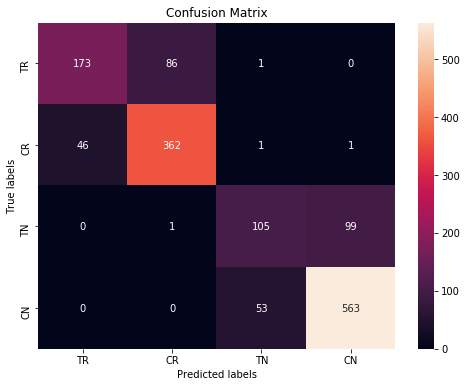

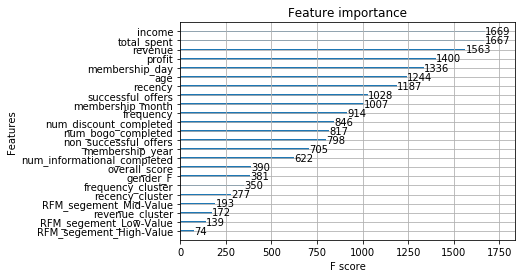

In [1023]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
D2_20_10_5_model = create_uplift_model_4quad_tuned(D2_20_10_5, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, D2_20_10_5_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D2_20_10_5_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D2_20_10_5_model, base =True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3021) in class 0 will be larger than the number of samples in the majority class (class #0.0 -> 1797)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3021) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 1797)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.01
learning_rate: 0.05
max_depth: 8
min_child_weight: 0.5
n_estimators: 100
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       0.99      1.00      1.00       622
    Completed Offer       1.00      0.99      0.99       402

           accuracy                           1.00      1024
          macro avg       1.00      0.99      0.99      1024
       weighted avg       1.00      1.00      1.00      1024
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (1343) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 792)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (1343) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 792)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 0.8
gamma: 0.01
learning_rate: 0.01
max_depth: 3
min_child_weight: 5.0
n_estimators: 50
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       0.99      1.00      1.00       189
    Completed Offer       1.00      1.00      1.00       279

           accuracy                           1.00       468
          macro avg       1.00      1.00      1.00       468
       weighted avg       1.00      1.00      1.00       468
 accuracy
Your irr with this strategy is 0.12.

Your nir with this strategy is 392.66.
(0.11904761904761904, 392.65999999999997) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


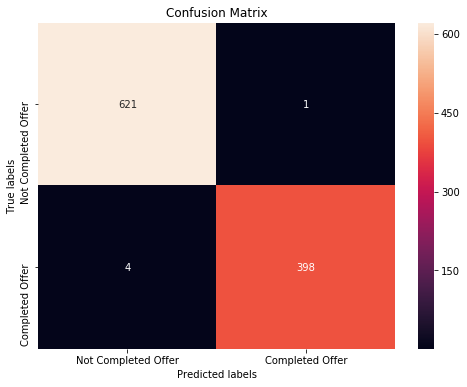

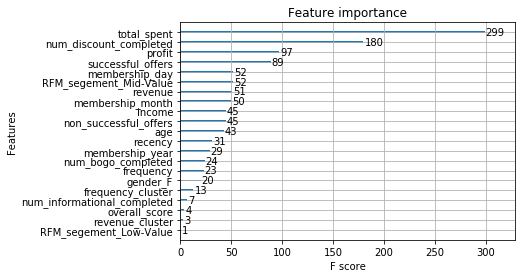

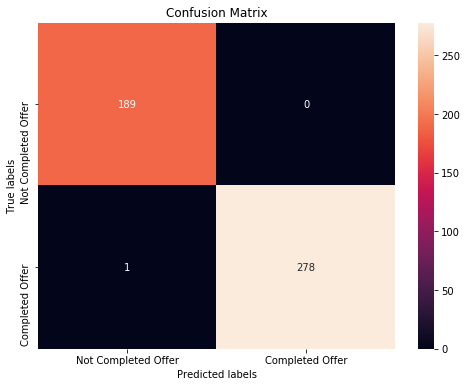

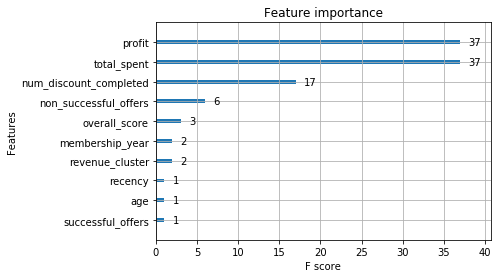

In [1036]:
#2 model approach 
D2_20_10_5_control = D2_20_10_5[D2_20_10_5.segment.isin([1,3])]
D2_20_10_5_treatment = D2_20_10_5[D2_20_10_5.segment.isin([0,2])]



D2_20_10_5_control_model = create_uplift_2model(D2_20_10_5_control, model_features, target_column='completed')

D2_20_10_5_treatment_model = create_uplift_2model(D2_20_10_5_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D2_20_10_5_control_model, D2_20_10_5_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D2_20_10_5_control_model, D2_20_10_5_treatment_model, base= True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (6112) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3660)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (6112) in class 1 will be larger than the number of samples in the majority class (class #0 -> 3660)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.93      0.95      0.94      1231
    Completed Offer       0.76      0.67      0.71       260

           accuracy                           0.91      1491
          macro avg       0.85      0.81      0.83      1491
       weighted avg       0.90      0.91      0.90      1491
 accuracy
Your irr with this strategy is -0.01.

Your nir with this strategy is 10197.94.
(-0.007751937984496138, 10197.94) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


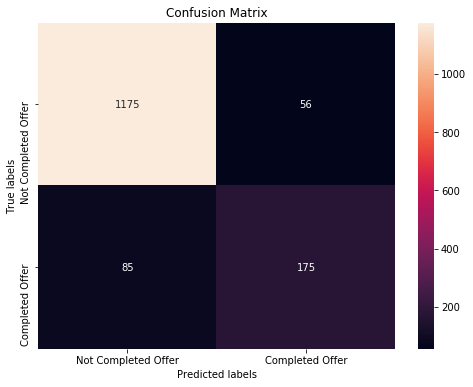

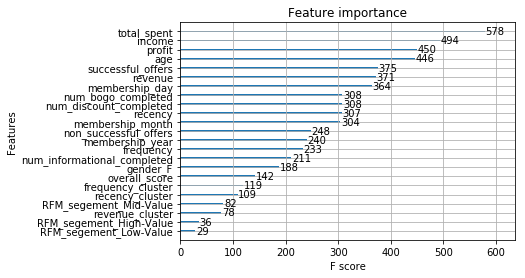

In [1037]:
## One model approach 

# create target column
D2_20_10_5['response'] = D2_20_10_5.segment.apply(lambda x:1 if x== 0 else 0)
D2_20_10_5

D2_20_10_5_one_model = create_uplift_2model(D2_20_10_5, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, D2_20_10_5_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, D2_20_10_5_one_model, base=True))

**summary**


### D4_7_7_3
This is a Discount offer that is sent through 4 channels, difficulty 7, duration 7 days and a reward of 3. 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7474 entries, 8 to 74332
Data columns (total 47 columns):
customer_id                    7474 non-null object
time_received                  7474 non-null int64
offer_id                       7474 non-null object
difficulty                     7474 non-null float64
duration                       7474 non-null float64
offer_type                     7474 non-null object
reward                         7474 non-null float64
email                          7474 non-null float64
web                            7474 non-null float64
mobile                         7474 non-null float64
social                         7474 non-null float64
expected_finish                7474 non-null float64
completed                      7474 non-null float64
finish                         7474 non-null float64
viewed                         7474 non-null float64
success                        7474 non-null float64
view_time                      7474 non-null floa

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2615)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2615)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 2 will be larger than the number of samples in the majority class (class #0 -> 2615)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 3 will be larger than the number of samples in the majority class (class #0 -> 2615)

/home/nisreen/an

Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.89      0.94      0.91       885
          CR       0.50      0.32      0.39       156
          TN       0.95      0.99      0.97       434
          CN       0.00      0.00      0.00        20

    accuracy                           0.88      1495
   macro avg       0.58      0.56      0.57      1495
weighted avg       0.85      0.88      0.86      1495
 accuracy
Your irr with this strategy is -0.16.

Your nir with this strategy is 15471.71.
(-0.16118352559030524, 15471.710000000001) using the uplift forumla strategy results
Your irr with this strategy is -0.15.

Your nir with this strategy is 15438.20.
(-0.15477504382263196, 15438.199999999999) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491

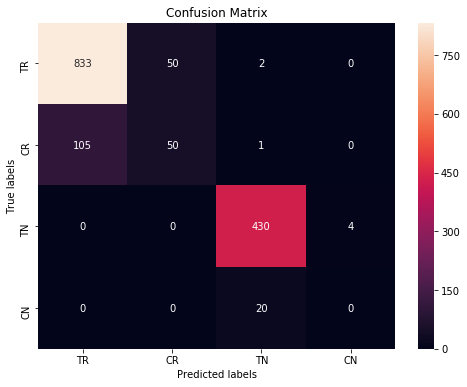

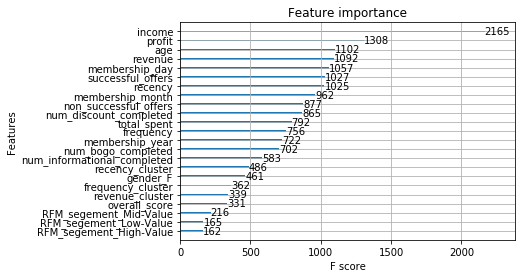

In [1025]:
D4_7_7_3.head()

D4_7_7_3.info()

# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
D4_7_7_3_model = create_uplift_model_4quad_tuned(D4_7_7_3, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, D4_7_7_3_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D4_7_7_3_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D4_7_7_3_model, base =True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (776) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 458)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (776) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 458)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 0.5
gamma: 0.5
learning_rate: 0.05
max_depth: 8
min_child_weight: 3.0
n_estimators: 50
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00        19
    Completed Offer       1.00      1.00      1.00       163

           accuracy                           1.00       182
          macro avg       1.00      1.00      1.00       182
       weighted avg       1.00      1.00      1.00       182
 accuracy


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 2590)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 2590)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 0.5
gamma: 6
learning_rate: 0.01
max_depth: 8
min_child_weight: 5.0
n_estimators: 25
silent: False
subsample: 0.5
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       402
    Completed Offer       1.00      1.00      1.00       912

           accuracy                           1.00      1314
          macro avg       1.00      1.00      1.00      1314
       weighted avg       1.00      1.00      1.00      1314
 accuracy
Your irr with this strategy is 0.00.

Your nir with this strategy is 100.29.
(0.0, 100.29) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


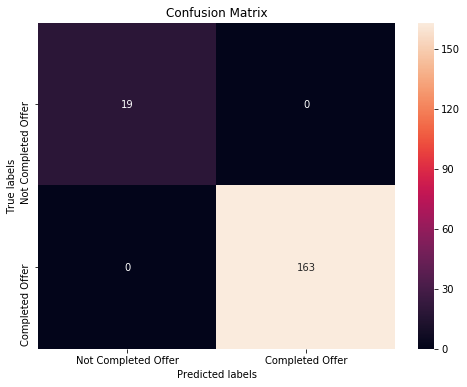

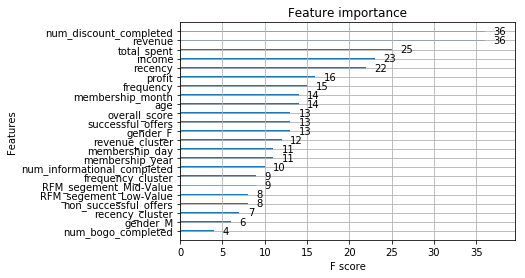

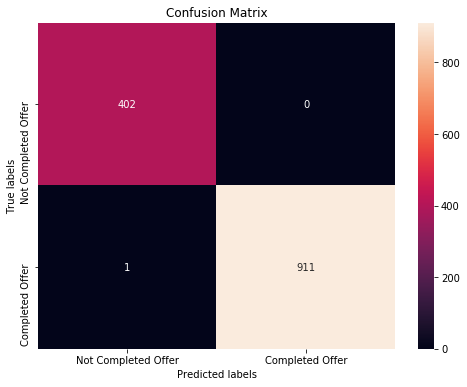

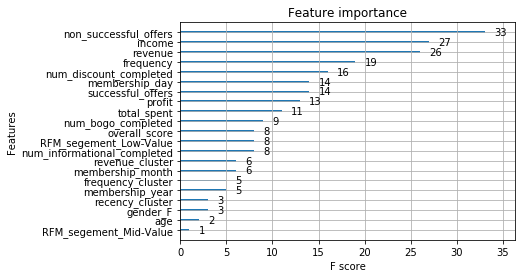

In [1038]:
#2 model approach 
D4_7_7_3_control = D4_7_7_3[D4_7_7_3.segment.isin([1,3])]
D4_7_7_3_treatment = D4_7_7_3[D4_7_7_3.segment.isin([0,2])]


D4_7_7_3_control_model = create_uplift_2model(D4_7_7_3_control, model_features, target_column='completed')

D4_7_7_3_treatment_model = create_uplift_2model(D4_7_7_3_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D4_7_7_3_control_model, D4_7_7_3_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D4_7_7_3_control_model, D4_7_7_3_treatment_model, base= True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 0 will be larger than the number of samples in the majority class (class #1 -> 2615)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4389) in class 1 will be larger than the number of samples in the majority class (class #1 -> 2615)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 0.8
gamma: 0.5
learning_rate: 0.05
max_depth: 10
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       0.91      0.82      0.86       610
    Completed Offer       0.88      0.94      0.91       885

           accuracy                           0.89      1495
          macro avg       0.90      0.88      0.89      1495
       weighted avg       0.89      0.89      0.89      1495
 accuracy
Your irr with this strategy is -0.11.

Your nir with this strategy is 14181.43.
(-0.10721745184497566, 14181.43) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


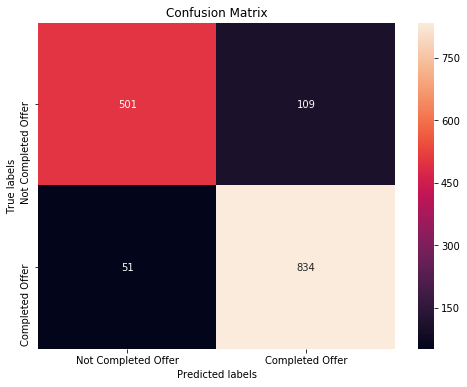

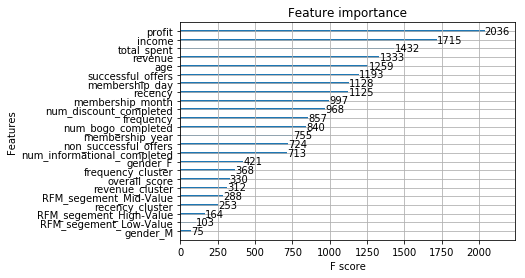

In [1039]:
## One model approach 
# create target column
D4_7_7_3['response'] = D4_7_7_3.segment.apply(lambda x:1 if x== 0 else 0)
D4_7_7_3

D4_7_7_3_one_model = create_uplift_2model(D4_7_7_3, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, D4_7_7_3_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, D4_7_7_3_one_model, base=True))

**summary**


### D4_10_10_2
This is a Discount offer that is sent through 4 channels, difficulty 10, duration 10 days and a reward of 2. 


In [1027]:
D4_10_10_2.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
3   0009655768c64bdeb2e877511632db8f  504            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     744.0            1.0        528.0   0.0     0.0      0.0        1                     0.00               96.87                  94.87   96.87        1.0                 2.0                     2.0                          1           2.0                3                      1        127.60   1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
12  0020c2b971eb4e9188eac86d93036a77  0              fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     240.0            1.0        54.0    1.0     1.0      12.0       0                     98.33              0.00                   96.33   98.33        1.0                 2.0                     0.0                          1           2.0                3                      0        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
14  0020c2b971eb4e9188eac86d93036a77  336            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     576.0            1.0        510.0   0.0     0.0      0.0        1                     0.00               51.10                  49.10   51.10        1.0                 2.0                     0.0                          1           2.0                3                      1        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
22  003d66b6608740288d6cc97a6903f4f0  168            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     408.0            1.0        384.0   1.0     1.0      300.0      0                     14.97              1.48                   12.97   16.45        0.0                 3.0                     2.0                          1           4.0                1                      0        48.34    0                18       3                18         3                  6              26.0 2017-06-21        73000.0  2017             6                 21              1         0         0                       0                       1                      
24  003d66b6608740288d6cc97a6903f4f0  408            fafdcd668e3743c1bb461111dcafc2a4  10.0        10.0      discount   2.0     1.0    1.0  1.0     1.0     648.0            1.0        504.0   1.0     1.0      420.0      0                     24.45              0.00                   22.45   24.45        0.0                 3.0                     2.0                          1           4.0                1                      0        48.34    0         

In [1028]:
D4_10_10_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7410 entries, 3 to 74390
Data columns (total 47 columns):
customer_id                    7410 non-null object
time_received                  7410 non-null int64
offer_id                       7410 non-null object
difficulty                     7410 non-null float64
duration                       7410 non-null float64
offer_type                     7410 non-null object
reward                         7410 non-null float64
email                          7410 non-null float64
web                            7410 non-null float64
mobile                         7410 non-null float64
social                         7410 non-null float64
expected_finish                7410 non-null float64
completed                      7410 non-null float64
finish                         7410 non-null float64
viewed                         7410 non-null float64
success                        7410 non-null float64
view_time                      7410 non-null floa

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2801)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2801)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 2 will be larger than the number of samples in the majority class (class #0 -> 2801)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 3 will be larger than the number of samples in the majority class (class #0 -> 2801)

/home/nisreen/an

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.91      0.95      0.93       942
          CR       0.56      0.39      0.46       145
          TN       0.95      0.98      0.96       378
          CN       0.00      0.00      0.00        17

    accuracy                           0.89      1482
   macro avg       0.60      0.58      0.59      1482
weighted avg       0.87      0.89      0.88      1482
 accuracy
Your irr with this strategy is -0.17.

Your nir with this strategy is 15694.24.
(-0.16860999081579675, 15694.24) using the uplift forumla strategy results
Your irr with this strategy is -0.16.

Your nir with this strategy is 15667.96.
(-0.1621447819696228, 15667.960000000001) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.

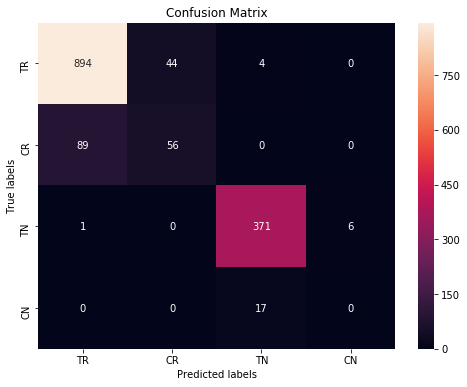

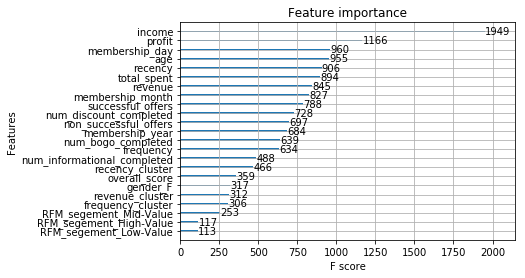

In [1040]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
D4_10_10_2_model = create_uplift_model_4quad_tuned(D4_10_10_2, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, D4_10_10_2_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D4_10_10_2_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D4_10_10_2_model, base =True),'base strategy results')


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (682) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 406)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (682) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 406)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 0.3
gamma: 0.01
learning_rate: 0.1
max_depth: 8
min_child_weight: 1.0
n_estimators: 50
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.90      0.90      0.90        20
    Completed Offer       0.99      0.99      0.99       137

           accuracy                           0.97       157
          macro avg       0.94      0.94      0.94       157
       weighted avg       0.97      0.97      0.97       157
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 2821)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 2821)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 0.8
gamma: 0.5
learning_rate: 0.05
max_depth: 10
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      0.99      1.00       423
    Completed Offer       1.00      1.00      1.00       903

           accuracy                           1.00      1326
          macro avg       1.00      1.00      1.00      1326
       weighted avg       1.00      1.00      1.00      1326
 accuracy
Your irr with this strategy is -0.34.

Your nir with this strategy is -4.33.
(-0.34375, -4.329999999999984) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


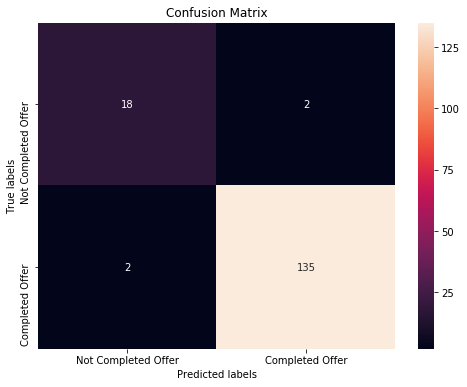

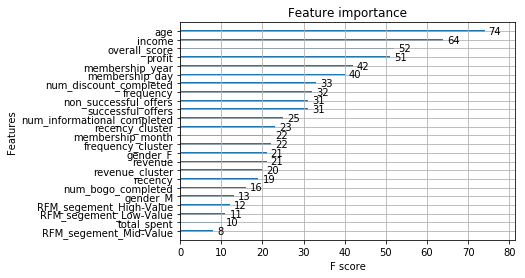

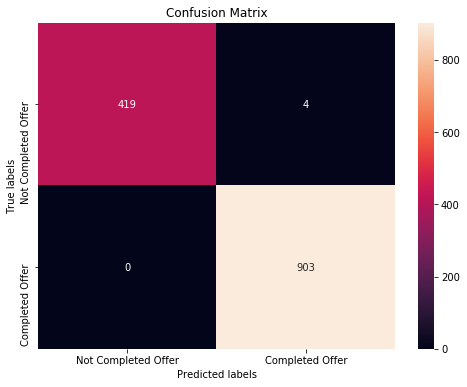

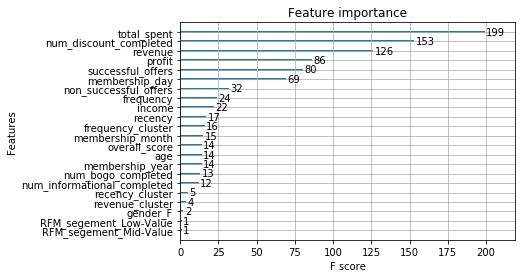

In [1042]:
#2 model approach 
D4_10_10_2_control = D4_10_10_2[D4_10_10_2.segment.isin([1,3])]
D4_10_10_2_treatment = D4_10_10_2[D4_10_10_2.segment.isin([0,2])]



D4_10_10_2_control_model = create_uplift_2model(D4_10_10_2_control, model_features, target_column='completed')

D4_10_10_2_treatment_model = create_uplift_2model(D4_10_10_2_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D4_10_10_2_control_model, D4_10_10_2_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D4_10_10_2_control_model, D4_10_10_2_treatment_model, base= True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 0 will be larger than the number of samples in the majority class (class #1 -> 2801)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (4650) in class 1 will be larger than the number of samples in the majority class (class #1 -> 2801)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.90      0.82      0.86       540
    Completed Offer       0.90      0.95      0.92       942

           accuracy                           0.90      1482
          macro avg       0.90      0.88      0.89      1482
       weighted avg       0.90      0.90      0.90      1482
 accuracy
Your irr with this strategy is -0.13.

Your nir with this strategy is 15021.66.
(-0.12880785002929118, 15021.660000000003) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


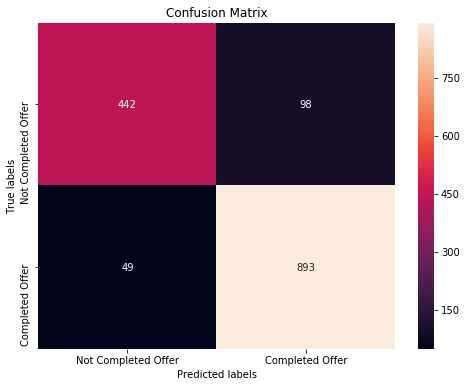

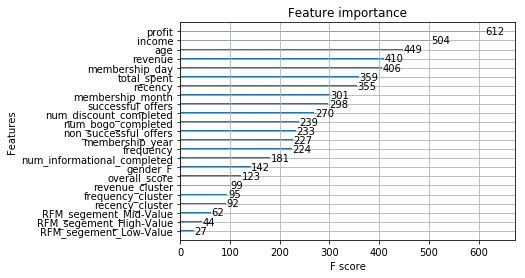

In [1043]:
# ## One model approach 

# create target column
D4_10_10_2['response'] = D4_10_10_2.segment.apply(lambda x:1 if x== 0 else 0)
D4_10_10_2

D4_10_10_2_one_model = create_uplift_2model(D4_10_10_2, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, D4_10_10_2_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, D4_10_10_2_one_model, base=True))

**summary**


### D3_10_7_2
This is a Discount offer that is sent through 3 channels, difficulty 10, duration 7 days and a reward of 2. 

In [1044]:
D3_10_7_2.head()

customer_id  time_received                          offer_id  difficulty  duration offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score        age became_member_on        income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
4   0009655768c64bdeb2e877511632db8f  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     744.0            1.0        576.0   0.0     0.0      0.0        1                     0.00               69.20                  67.20   69.20        1.0                 2.0                     2.0                          1           2.0                3                      1        127.60   1                18       3                8          1                  5              33.000000 2017-04-21        72000.000000  2017             4                 21              0         1         0                       1                       0                      
29  00426fe3ffde4c6b9cb9ad6d077a13ea  408            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               1.90                   1.90    1.90         0.0                 1.0                     1.0                          1           2.0                3                      3        68.51    0                18       3                17         3                  6              19.000000 2016-08-09        65000.000000  2016             8                 9               1         0         0                       0                       1                      
30  00426fe3ffde4c6b9cb9ad6d077a13ea  576            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     744.0            0.0        744.0   0.0     0.0      0.0        0                     0.00               5.94                   5.94    5.94         0.0                 1.0                     1.0                          1           2.0                3                      3        68.51    0                18       3                17         3                  6              19.000000 2016-08-09        65000.000000  2016             8                 9               1         0         0                       0                       1                      
41  005500a7188546ff8a767329a2f7c76a  408            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 0.0                     0.0                          0           0.0                5                      3        20.36    0                126      2                4          0                  2              56.000000 2017-12-09        47000.000000  2017             12                9               0         1         1                       0                       0                      
55  0069a50874d846438e58acff5e594725  504            2906b810c7d4411798c6938adc9daaa5  10.0        7.0       discount   2.0     1.0    1.0  1.0     0.0     672.0            0.0        672.0   1.0     0.0      552.0      0                     5.12               0.00                   5.12    5.12         0.0                 1.0                     0.0                          1           0.0                4

In [1045]:
D3_10_7_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7408 entries, 4 to 74395
Data columns (total 47 columns):
customer_id                    7408 non-null object
time_received                  7408 non-null int64
offer_id                       7408 non-null object
difficulty                     7408 non-null float64
duration                       7408 non-null float64
offer_type                     7408 non-null object
reward                         7408 non-null float64
email                          7408 non-null float64
web                            7408 non-null float64
mobile                         7408 non-null float64
social                         7408 non-null float64
expected_finish                7408 non-null float64
completed                      7408 non-null float64
finish                         7408 non-null float64
viewed                         7408 non-null float64
success                        7408 non-null float64
view_time                      7408 non-null floa

Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2131) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1273)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2131) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1273)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2131) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1273)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2131) in class 3 will be larger than the number of samples in the majority class (class #0 -> 1273)

/home/nisreen/an

Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.79      0.77      0.78       431
          CR       0.74      0.76      0.75       368
          TN       0.64      0.61      0.62       252
          CN       0.78      0.80      0.79       431

    accuracy                           0.75      1482
   macro avg       0.74      0.73      0.73      1482
weighted avg       0.75      0.75      0.75      1482
 accuracy
Your irr with this strategy is -0.03.

Your nir with this strategy is 14910.05.
(-0.0329902037822829, 14910.05) using the uplift forumla strategy results
Your irr with this strategy is -0.09.

Your nir with this strategy is 14000.50.
(-0.09073967889908252, 14000.500000000002) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.249107553492039

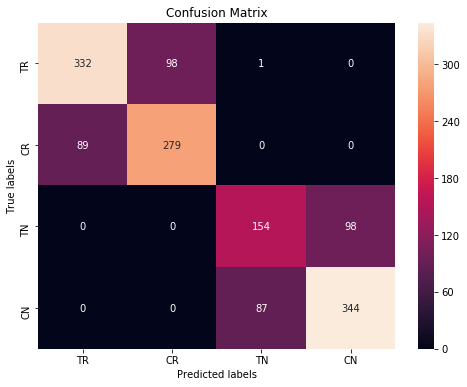

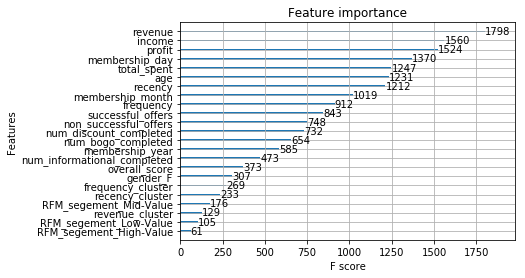

In [1046]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
D3_10_7_2_model = create_uplift_model_4quad_tuned(D3_10_7_2, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, D3_10_7_2_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D3_10_7_2_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, D3_10_7_2_model, base =True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2107) in class 0 will be larger than the number of samples in the majority class (class #0.0 -> 1239)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2107) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 1239)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 0.5
gamma: 0.5
learning_rate: 0.05
max_depth: 8
min_child_weight: 3.0
n_estimators: 50
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       433
    Completed Offer       1.00      0.99      1.00       367

           accuracy                           1.00       800
          macro avg       1.00      1.00      1.00       800
       weighted avg       1.00      1.00      1.00       800
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2131) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 1256)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2131) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 1256)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 0.8
gamma: 0.01
learning_rate: 0.01
max_depth: 3
min_child_weight: 5.0
n_estimators: 50
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       228
    Completed Offer       1.00      1.00      1.00       454

           accuracy                           1.00       682
          macro avg       1.00      1.00      1.00       682
       weighted avg       1.00      1.00      1.00       682
 accuracy
Your irr with this strategy is 0.00.

Your nir with this strategy is 234.34.
(0.0, 234.34000000000003) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


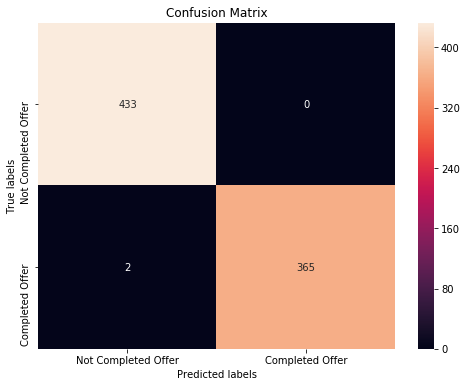

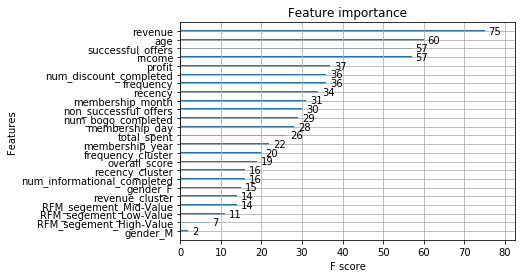

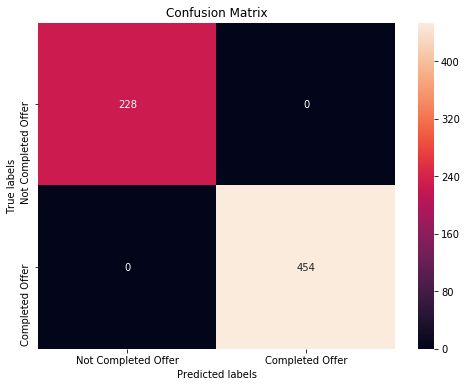

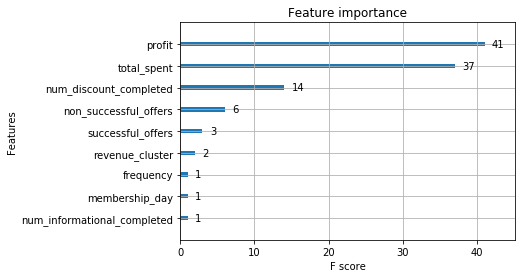

In [1048]:
#2 model approach 
D3_10_7_2_control = D3_10_7_2[D3_10_7_2.segment.isin([1,3])]
D3_10_7_2_treatment = D3_10_7_2[D3_10_7_2.segment.isin([0,2])]



D3_10_7_2_control_model = create_uplift_2model(D3_10_7_2_control, model_features, target_column='completed')

D3_10_7_2_treatment_model = create_uplift_2model(D3_10_7_2_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D3_10_7_2_control_model, D3_10_7_2_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, D3_10_7_2_control_model, D3_10_7_2_treatment_model, base= True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (5277) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3171)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (5277) in class 1 will be larger than the number of samples in the majority class (class #0 -> 3171)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.91      0.91      0.91      1051
    Completed Offer       0.78      0.77      0.77       431

           accuracy                           0.87      1482
          macro avg       0.84      0.84      0.84      1482
       weighted avg       0.87      0.87      0.87      1482
 accuracy
Your irr with this strategy is -0.09.

Your nir with this strategy is 12775.68.
(-0.09028898342379343, 12775.68) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


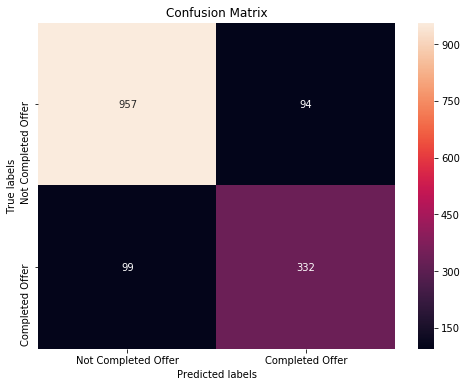

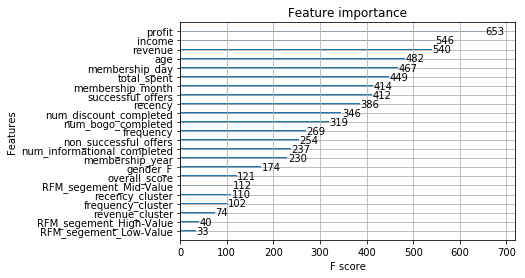

In [1047]:
## One model approach 

# create target column
D3_10_7_2['response'] = D3_10_7_2.segment.apply(lambda x:1 if x== 0 else 0)
D3_10_7_2

D3_10_7_2_one_model = create_uplift_2model(D3_10_7_2, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, D3_10_7_2_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, D4_10_10_2_one_model, base=True))

**summary**


### I3_0_4_0
This is a Informational offer that is sent through 3 channels, difficulty 0, duration 4 days and a reward of 0. 

**summary**


### I3_0_4_0
This is a Informational offer that is sent through 3 channels, difficulty 0, duration 4 days and a reward of 0. 

In [1019]:
I3_0_4_0.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
1   0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          1           2.0                3                      0        127.60   1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
7   0011e0d4e6b944f998e987f904e8c1e5  0              3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     96.0             0.0        96.0    1.0     0.0      6.0        0                     0.00               0.00                   0.00    0.00         1.0                 2.0                     0.0                          0           3.0                2                      2        79.46    0                60       2                5          0                  2              40.0 2018-01-09        57000.0  2018             1                 9               0         1         1                       0                       0                      
23  003d66b6608740288d6cc97a6903f4f0  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     432.0            1.0        432.0   1.0     1.0      372.0      0                     10.08              2.19                   10.08   12.27        0.0                 3.0                     2.0                          1           4.0                1                      0        48.34    0                18       3                18         3                  6              26.0 2017-06-21        73000.0  2017             6                 21              1         0         0                       0                       1                      
31  004b041fbfe44859945daa2c7f79ee64  168            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     264.0            0.0        264.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 1.0                     0.0                          0           2.0                1                      3        138.36   1                0        3                6          1                  5              55.0 2018-05-08        74000.0  2018             5                 8               1         0         0                       1                       0                      
46  0056df74b63b4298809f0b375a304cf4  504            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     600.0            1.0        600.0   1.0     1.0      528.0      0                     58.80              0.00                   58.80   58.80        1.0                 2.0                     1.0                          1           2.0                2                      0   

In [1049]:
I3_0_4_0.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
1   0009655768c64bdeb2e877511632db8f  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     432.0            1.0        432.0   1.0     1.0      372.0      0                     8.57               0.00                   8.57    8.57         1.0                 2.0                     2.0                          1           2.0                3                      0        127.60   1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
7   0011e0d4e6b944f998e987f904e8c1e5  0              3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     96.0             0.0        96.0    1.0     0.0      6.0        0                     0.00               0.00                   0.00    0.00         1.0                 2.0                     0.0                          0           3.0                2                      2        79.46    0                60       2                5          0                  2              40.0 2018-01-09        57000.0  2018             1                 9               0         1         1                       0                       0                      
23  003d66b6608740288d6cc97a6903f4f0  336            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     432.0            1.0        432.0   1.0     1.0      372.0      0                     10.08              2.19                   10.08   12.27        0.0                 3.0                     2.0                          1           4.0                1                      0        48.34    0                18       3                18         3                  6              26.0 2017-06-21        73000.0  2017             6                 21              1         0         0                       0                       1                      
31  004b041fbfe44859945daa2c7f79ee64  168            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     264.0            0.0        264.0   0.0     0.0      0.0        0                     0.00               0.00                   0.00    0.00         1.0                 1.0                     0.0                          0           2.0                1                      3        138.36   1                0        3                6          1                  5              55.0 2018-05-08        74000.0  2018             5                 8               1         0         0                       1                       0                      
46  0056df74b63b4298809f0b375a304cf4  504            3f207df678b143eea3cee63160fa8bed  0.0         4.0       informational  0.0     1.0    1.0  1.0     0.0     600.0            1.0        600.0   1.0     1.0      528.0      0                     58.80              0.00                   58.80   58.80        1.0                 2.0                     1.0                          1           2.0                2                      0   

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3735) in class 0 will be larger than the number of samples in the majority class (class #3 -> 2233)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3735) in class 1 will be larger than the number of samples in the majority class (class #3 -> 2233)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3735) in class 2 will be larger than the number of samples in the majority class (class #3 -> 2233)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3735) in class 3 will be larger than the number of samples in the majority class (class #3 -> 2233)

/home/nisreen/an

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.87      0.90      0.88       419
          CR       0.97      0.97      0.97        99
          TN       0.62      0.64      0.63       229
          CN       0.83      0.81      0.82       738

    accuracy                           0.82      1485
   macro avg       0.82      0.83      0.82      1485
weighted avg       0.82      0.82      0.82      1485
 accuracy
Your irr with this strategy is -0.26.

Your nir with this strategy is 17144.97.
(-0.2592236785682231, 17144.97) using the uplift forumla strategy results
Your irr with this strategy is -0.18.

Your nir with this strategy is 6710.20.
(-0.1770611702127659, 6710.2) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.249107553

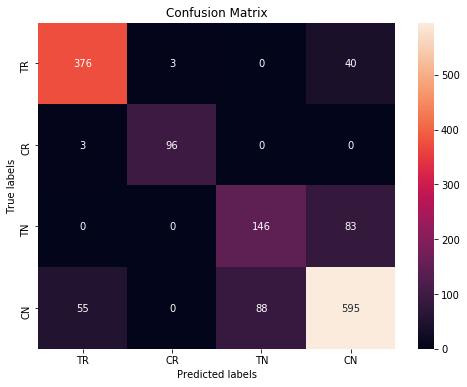

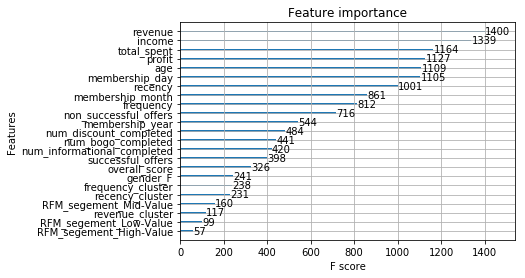

In [1050]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
I3_0_4_0_model = create_uplift_model_4quad_tuned(I3_0_4_0, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, I3_0_4_0_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, I3_0_4_0_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, I3_0_4_0_model, base =True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3735) in class 0 will be larger than the number of samples in the majority class (class #0.0 -> 2246)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3735) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 2246)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 0.8
gamma: 0.01
learning_rate: 0.1
max_depth: 8
min_child_weight: 1.0
n_estimators: 50
silent: False
subsample: 0.5
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       740
    Completed Offer       1.00      0.99      0.99        92

           accuracy                           1.00       832
          macro avg       1.00      0.99      1.00       832
       weighted avg       1.00      1.00      1.00       832
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2173) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 1299)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (2173) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 1299)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 0.5
gamma: 6
learning_rate: 0.01
max_depth: 8
min_child_weight: 5.0
n_estimators: 25
silent: False
subsample: 0.5
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       235
    Completed Offer       1.00      1.00      1.00       419

           accuracy                           1.00       654
          macro avg       1.00      1.00      1.00       654
       weighted avg       1.00      1.00      1.00       654
 accuracy
Your irr with this strategy is -0.22.

Your nir with this strategy is 1567.99.
(-0.22499999999999998, 1567.99) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


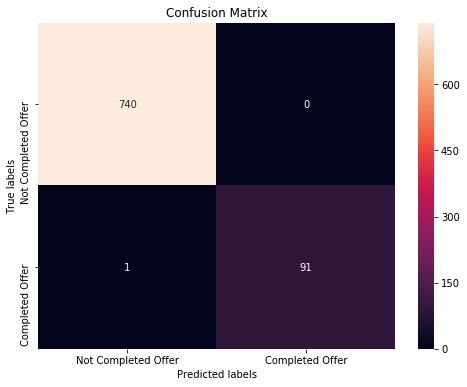

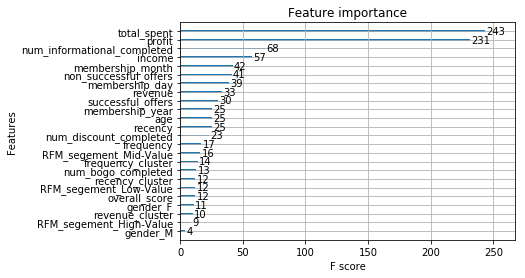

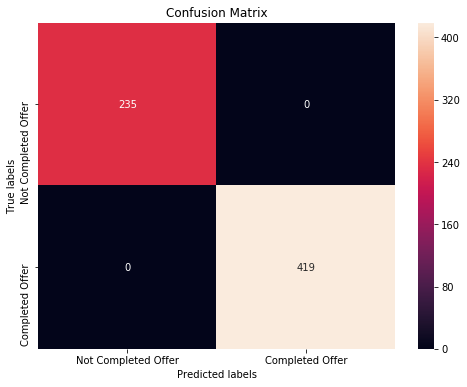

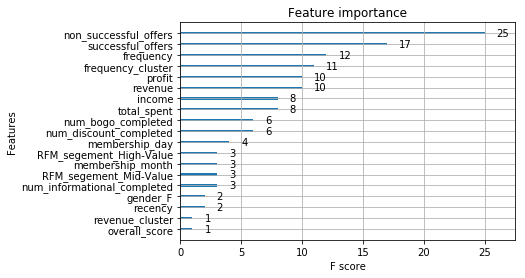

In [1051]:
#2 model approach 
I3_0_4_0_control = I3_0_4_0[I3_0_4_0.segment.isin([1,3])]
I3_0_4_0_treatment = I3_0_4_0[I3_0_4_0.segment.isin([0,2])]



I3_0_4_0_control_model = create_uplift_2model(I3_0_4_0_control, model_features, target_column='completed')

I3_0_4_0_treatment_model = create_uplift_2model(I3_0_4_0_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, I3_0_4_0_control_model, I3_0_4_0_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, I3_0_4_0_control_model, I3_0_4_0_treatment_model, base= True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (5253) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3117)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (5253) in class 1 will be larger than the number of samples in the majority class (class #0 -> 3117)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.01
learning_rate: 0.05
max_depth: 8
min_child_weight: 0.5
n_estimators: 100
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       0.97      0.92      0.94      1066
    Completed Offer       0.82      0.94      0.87       419

           accuracy                           0.92      1485
          macro avg       0.90      0.93      0.91      1485
       weighted avg       0.93      0.92      0.92      1485
 accuracy
Your irr with this strategy is -0.20.

Your nir with this strategy is 7055.95.
(-0.19818489967743702, 7055.950000000001) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


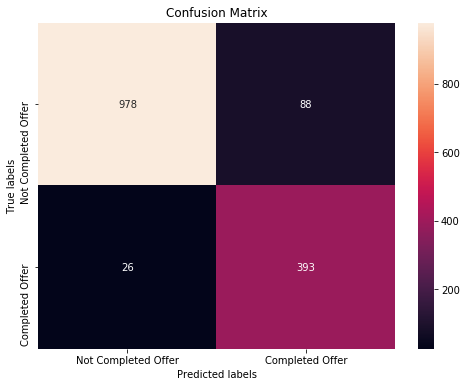

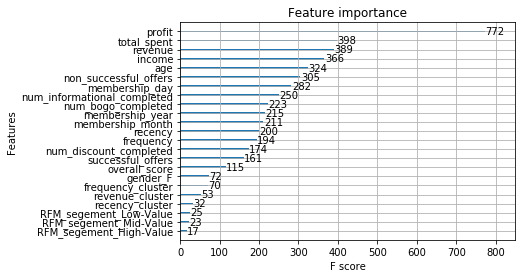

In [1052]:
## One model approach 

# create target column
I3_0_4_0['response'] = I3_0_4_0.segment.apply(lambda x:1 if x== 0 else 0)
I3_0_4_0

I3_0_4_0_one_model = create_uplift_2model(I3_0_4_0, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, I3_0_4_0_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, D4_10_10_2_one_model, base=True))

**summary**


### I3_0_3_0
This is a Informational offer that is sent through 3 channels, difficulty 0, duration 3 days and a reward of 0. 

In [1053]:
I3_0_3_0.head()

customer_id  time_received                          offer_id  difficulty  duration     offer_type  reward  email  web  mobile  social  expected_finish  completed  finish  viewed  success  view_time  completed_not_viewed  total_spent_offer  total_spent_non_offer  profit  total_spent  num_bogo_completed  num_discount_completed  num_informational_completed  has_profit  successful_offers  non_successful_offers  segment  revenue  revenue_cluster  recency  recency_cluster  frequency  frequency_cluster  overall_score   age became_member_on   income  membership_year  membership_month  membership_day  gender_F  gender_M  RFM_segement_Low-Value  RFM_segement_Mid-Value  RFM_segement_High-Value
0   0009655768c64bdeb2e877511632db8f  168            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     240.0            1.0        240.0   1.0     1.0      192.0      0                     22.16              0.0                    22.16   22.16        1.0                 2.0                     2.0                          1           2.0                3                      0        127.60   1                18       3                8          1                  5              33.0 2017-04-21        72000.0  2017             4                 21              0         1         0                       1                       0                      
9   0011e0d4e6b944f998e987f904e8c1e5  336            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     408.0            0.0        408.0   1.0     0.0      354.0      0                     0.00               0.0                    0.00    0.00         1.0                 2.0                     0.0                          0           3.0                2                      2        79.46    0                60       2                5          0                  2              40.0 2018-01-09        57000.0  2018             1                 9               0         1         1                       0                       0                      
16  0020c2b971eb4e9188eac86d93036a77  504            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     576.0            0.0        576.0   0.0     0.0      0.0        0                     0.00               51.1                   51.10   51.10        1.0                 2.0                     0.0                          1           2.0                3                      3        196.86   1                6        3                8          1                  5              59.0 2016-03-04        90000.0  2016             3                 4               1         0         0                       1                       0                      
19  0020ccbbb6d84e358d3414a3ff76cffd  408            5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     480.0            1.0        480.0   1.0     1.0      408.0      0                     58.87              0.0                    58.87   58.87        2.0                 1.0                     1.0                          1           4.0                0                      0        154.05   1                42       3                12         2                  6              24.0 2016-11-11        60000.0  2016             11                11              1         0         0                       0                       1                      
21  003d66b6608740288d6cc97a6903f4f0  0              5a8bc65990b245e5a138643cd4eb9837  0.0         3.0       informational  0.0     1.0    0.0  1.0     1.0     72.0             1.0        72.0    1.0     1.0      36.0       0                     2.51               0.0                    2.51    2.51         0.0                 3.0                     2.0                          1           4.0                1                      0   

In [1054]:
I3_0_3_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7460 entries, 0 to 74387
Data columns (total 47 columns):
customer_id                    7460 non-null object
time_received                  7460 non-null int64
offer_id                       7460 non-null object
difficulty                     7460 non-null float64
duration                       7460 non-null float64
offer_type                     7460 non-null object
reward                         7460 non-null float64
email                          7460 non-null float64
web                            7460 non-null float64
mobile                         7460 non-null float64
social                         7460 non-null float64
expected_finish                7460 non-null float64
completed                      7460 non-null float64
finish                         7460 non-null float64
viewed                         7460 non-null float64
success                        7460 non-null float64
view_time                      7460 non-null floa

Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3487) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2088)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3487) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2088)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3487) in class 2 will be larger than the number of samples in the majority class (class #0 -> 2088)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3487) in class 3 will be larger than the number of samples in the majority class (class #0 -> 2088)

/home/nisreen/an

Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
              precision    recall  f1-score   support

          TR       0.95      0.99      0.97       695
          CR       0.97      0.97      0.97       132
          TN       0.75      0.82      0.79       396
          CN       0.65      0.49      0.56       269

    accuracy                           0.86      1492
   macro avg       0.83      0.82      0.82      1492
weighted avg       0.85      0.86      0.85      1492
 accuracy
Your irr with this strategy is -0.28.

Your nir with this strategy is 17294.86.
(-0.275303291322876, 17294.86) using the uplift forumla strategy results
Your irr with this strategy is -0.22.

Your nir with this strategy is 7448.57.
(-0.22477458136539286, 7448.570000000001) sending the TR strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 

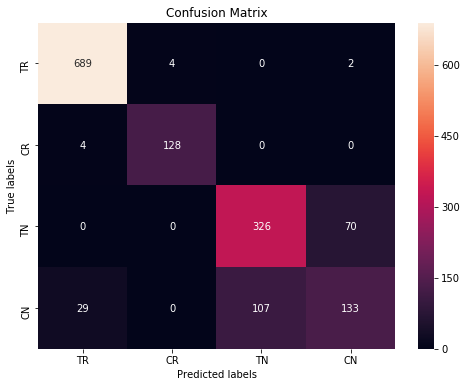

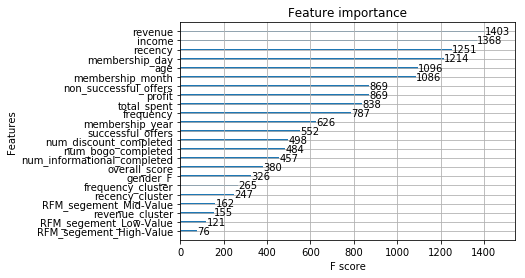

In [1055]:
# we will use the model for the model that provides the tuned parametes
model_features = ['email','web', 'mobile','social', 'profit', 'total_spent', 'num_bogo_completed',
     'num_discount_completed', 'num_informational_completed', 'successful_offers', 'non_successful_offers',
     'revenue', 'revenue_cluster',  'recency', 'recency_cluster', 'frequency', 'frequency_cluster',
     'overall_score', 'age', 'income', 'membership_year',  'membership_month', 'membership_day',
     'gender_F', 'gender_M', 'RFM_segement_Low-Value', 'RFM_segement_Mid-Value', 'RFM_segement_High-Value']
I3_0_3_0_model = create_uplift_model_4quad_tuned(I3_0_3_0, model_features)

print(test_results(promotion_strategy_4QD, X_test, y_test, I3_0_3_0_model), 'using the uplift forumla strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, I3_0_3_0_model), 'sending the TR strategy results')
print(test_results(promotion_strategy_simple_4QD, X_test, y_test, I3_0_3_0_model, base =True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (1426) in class 0 will be larger than the number of samples in the majority class (class #0.0 -> 845)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (1426) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 845)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Randomized search..
Best params: 
colsample_bytree: 0.8
gamma: 0.5
learning_rate: 0.05
max_depth: 10
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 1.0
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       295
    Completed Offer       0.99      0.99      0.99       119

           accuracy                           1.00       414
          macro avg       0.99      0.99      0.99       414
       weighted avg       1.00      1.00      1.00       414
 accuracy
Randomized search..


/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3487) in class 0 will be larger than the number of samples in the majority class (class #1.0 -> 2070)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3487) in class 1 will be larger than the number of samples in the majority class (class #1.0 -> 2070)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best params: 
colsample_bytree: 0.5
gamma: 6
learning_rate: 0.01
max_depth: 8
min_child_weight: 5.0
n_estimators: 25
silent: False
subsample: 0.5
                     precision    recall  f1-score   support

Not Completed Offer       1.00      1.00      1.00       377
    Completed Offer       1.00      1.00      1.00       701

           accuracy                           1.00      1078
          macro avg       1.00      1.00      1.00      1078
       weighted avg       1.00      1.00      1.00      1078
 accuracy
Your irr with this strategy is 0.00.

Your nir with this strategy is 252.31.
(0.0, 252.30999999999997) using the uplift forumla strategy results
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002) base strategy results


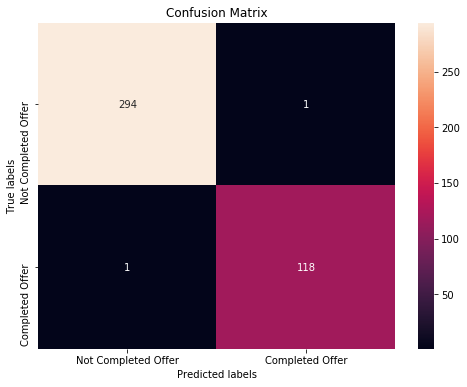

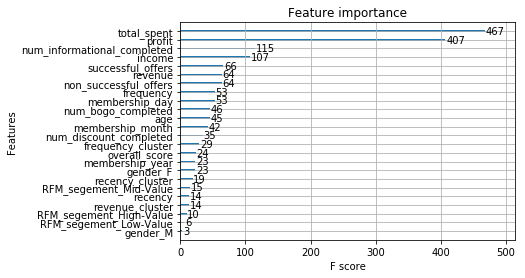

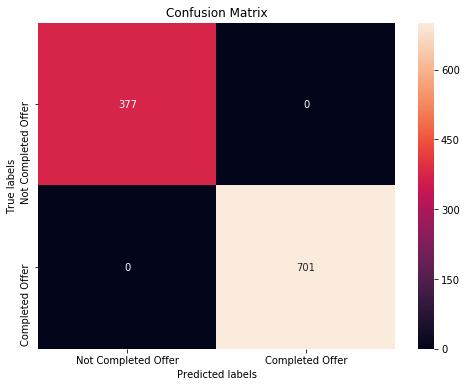

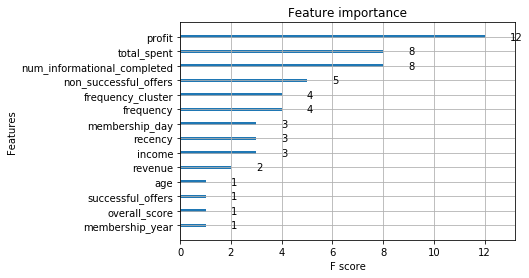

In [1056]:
#2 model approach 
I3_0_3_0_control = I3_0_3_0[I3_0_3_0.segment.isin([1,3])]
I3_0_3_0_treatment = I3_0_3_0[I3_0_3_0.segment.isin([0,2])]



I3_0_3_0_control_model = create_uplift_2model(I3_0_3_0_control, model_features, target_column='completed')

I3_0_3_0_treatment_model = create_uplift_2model(I3_0_3_0_treatment, model_features, target_column='completed')

print(test_results_2(promotion_strategy_2models, X_test, y_test, I3_0_3_0_control_model, I3_0_3_0_treatment_model), 'using the uplift forumla strategy results')

print(test_results_2(promotion_strategy_2models, X_test, y_test, I3_0_3_0_control_model, I3_0_3_0_treatment_model, base= True),'base strategy results')

/home/nisreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3973) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2388)

/home/nisreen/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (3973) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2388)

/home/nisreen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in

Randomized search..
Best params: 
colsample_bytree: 1.0
gamma: 0.5
learning_rate: 0.2
max_depth: 8
min_child_weight: 3.0
n_estimators: 500
silent: False
subsample: 0.8
                     precision    recall  f1-score   support

Not Completed Offer       0.99      0.95      0.97       797
    Completed Offer       0.95      0.99      0.97       695

           accuracy                           0.97      1492
          macro avg       0.97      0.97      0.97      1492
       weighted avg       0.97      0.97      0.97      1492
 accuracy
Your irr with this strategy is -0.23.

Your nir with this strategy is 7372.10.
(-0.2335716717739189, 7372.1) using one model strategy
Your irr with this strategy is -0.25.

Your nir with this strategy is 17256.69.
(-0.2491075534920391, 17256.690000000002)


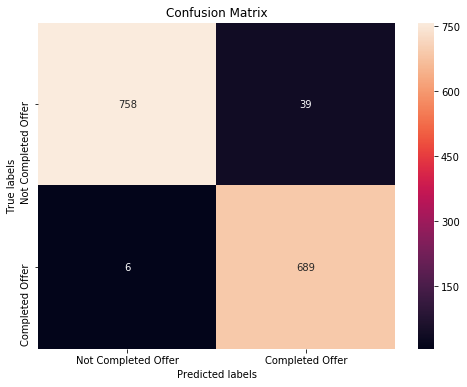

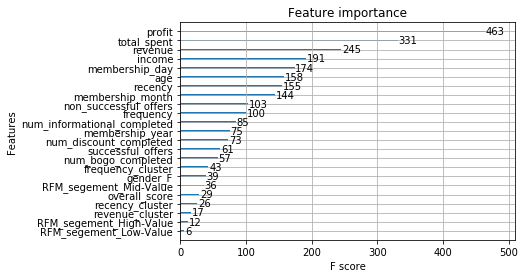

In [1057]:
# ## One model approach 

# create target column
I3_0_3_0['response'] = I3_0_3_0.segment.apply(lambda x:1 if x== 0 else 0)
I3_0_3_0

I3_0_3_0_one_model = create_uplift_2model(I3_0_3_0, model_features, target_column='response')

# promotion strategy

print(test_results(promotion_strategy_1D, X_test, y_test, I3_0_3_0_one_model), 'using one model strategy')

print(test_results(promotion_strategy_1D, X_test, y_test, D4_10_10_2_one_model, base=True))